In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : True,
    'right'         : True,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'normalized','im':'t1','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'normalized',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'diffusion_fa',
    'balance_data'  : True,
    'balance_bins'  : 40,
    'balance_ratio' : 1,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : True,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'MSE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_MSE_7_40_1_1_0_0_0_1_t1t2_normalized_e_n_e_0_1_e_1_0_diffusion_fa_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1_1_42_n_normalized_08_05_n


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(734160, 828)
(734160, 1)
validation
(101248, 828)
(101248, 1)
test
(100432, 828)
(100432, 1)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 828)]             0         


 dense (Dense)               (None, 1024)              848896    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 1)                 129       


Total params: 1538049 (5.87 MB)


Trainable params: 1538049 (5.87 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


 1/74 [..............................] - ETA: 1:26 - loss: 0.3460 - STD: 1.3380e-04 - MAE: 0.5800

 4/74 [>.............................] - ETA: 1s - loss: 0.1289 - STD: 6.1847e-04 - MAE: 0.2881  

 5/74 [=>............................] - ETA: 2s - loss: 0.1061 - STD: 5.5029e-04 - MAE: 0.2483

 6/74 [=>............................] - ETA: 2s - loss: 0.0919 - STD: 4.8304e-04 - MAE: 0.2259

 7/74 [=>............................] - ETA: 2s - loss: 0.0824 - STD: 4.2573e-04 - MAE: 0.2122

 8/74 [==>...........................] - ETA: 2s - loss: 0.0757 - STD: 3.7845e-04 - MAE: 0.2033

 9/74 [==>...........................] - ETA: 2s - loss: 0.0706 - STD: 3.3973e-04 - MAE: 0.1968

10/74 [===>..........................] - ETA: 3s - loss: 0.0668 - STD: 3.0754e-04 - MAE: 0.1923

11/74 [===>..........................] - ETA: 3s - loss: 0.0637 - STD: 2.8055e-04 - MAE: 0.1890

12/74 [===>..........................] - ETA: 3s - loss: 0.0612 - STD: 2.5783e-04 - MAE: 0.1861

13/74 [====>.........................] - ETA: 3s - loss: 0.0591 - STD: 2.3862e-04 - MAE: 0.1838

14/74 [====>.........................] - ETA: 3s - loss: 0.0573 - STD: 2.2229e-04 - MAE: 0.1819

15/74 [=====>........................] - ETA: 3s - loss: 0.0557 - STD: 2.0829e-04 - MAE: 0.1802

16/74 [=====>........................] - ETA: 3s - loss: 0.0543 - STD: 1.9619e-04 - MAE: 0.1787

17/74 [=====>........................] - ETA: 3s - loss: 0.0530 - STD: 1.8567e-04 - MAE: 0.1772

18/74 [======>.......................] - ETA: 2s - loss: 0.0519 - STD: 1.7641e-04 - MAE: 0.1758

19/74 [======>.......................] - ETA: 2s - loss: 0.0508 - STD: 1.6820e-04 - MAE: 0.1743

20/74 [=======>......................] - ETA: 2s - loss: 0.0497 - STD: 1.6086e-04 - MAE: 0.1728

21/74 [=======>......................] - ETA: 2s - loss: 0.0487 - STD: 1.5429e-04 - MAE: 0.1713

22/74 [=======>......................] - ETA: 2s - loss: 0.0478 - STD: 1.4840e-04 - MAE: 0.1697

23/74 [========>.....................] - ETA: 2s - loss: 0.0468 - STD: 1.4305e-04 - MAE: 0.1681

24/74 [========>.....................] - ETA: 2s - loss: 0.0459 - STD: 1.3822e-04 - MAE: 0.1662

25/74 [=========>....................] - ETA: 2s - loss: 0.0450 - STD: 1.3382e-04 - MAE: 0.1644

26/74 [=========>....................] - ETA: 2s - loss: 0.0440 - STD: 1.2983e-04 - MAE: 0.1623

27/74 [=========>....................] - ETA: 2s - loss: 0.0430 - STD: 1.2619e-04 - MAE: 0.1600

28/74 [==========>...................] - ETA: 2s - loss: 0.0421 - STD: 1.2290e-04 - MAE: 0.1577

29/74 [==========>...................] - ETA: 2s - loss: 0.0411 - STD: 1.1987e-04 - MAE: 0.1551

30/74 [===========>..................] - ETA: 2s - loss: 0.0401 - STD: 1.1708e-04 - MAE: 0.1526

31/74 [===========>..................] - ETA: 2s - loss: 0.0392 - STD: 1.1456e-04 - MAE: 0.1501

32/74 [===========>..................] - ETA: 2s - loss: 0.0382 - STD: 1.1220e-04 - MAE: 0.1477

33/74 [============>.................] - ETA: 2s - loss: 0.0374 - STD: 1.1001e-04 - MAE: 0.1455

34/74 [============>.................] - ETA: 2s - loss: 0.0365 - STD: 1.0792e-04 - MAE: 0.1436

35/74 [=============>................] - ETA: 2s - loss: 0.0358 - STD: 1.0592e-04 - MAE: 0.1419

36/74 [=============>................] - ETA: 2s - loss: 0.0351 - STD: 1.0398e-04 - MAE: 0.1404

37/74 [==============>...............] - ETA: 2s - loss: 0.0345 - STD: 1.0212e-04 - MAE: 0.1391

38/74 [==============>...............] - ETA: 2s - loss: 0.0339 - STD: 1.0038e-04 - MAE: 0.1380

39/74 [==============>...............] - ETA: 1s - loss: 0.0333 - STD: 9.8633e-05 - MAE: 0.1369

40/74 [===============>..............] - ETA: 1s - loss: 0.0328 - STD: 9.6896e-05 - MAE: 0.1358

41/74 [===============>..............] - ETA: 1s - loss: 0.0323 - STD: 9.5239e-05 - MAE: 0.1347

42/74 [================>.............] - ETA: 1s - loss: 0.0318 - STD: 9.3592e-05 - MAE: 0.1335

43/74 [================>.............] - ETA: 1s - loss: 0.0313 - STD: 9.1909e-05 - MAE: 0.1323

44/74 [================>.............] - ETA: 1s - loss: 0.0308 - STD: 9.0295e-05 - MAE: 0.1311

45/74 [=================>............] - ETA: 1s - loss: 0.0303 - STD: 8.8693e-05 - MAE: 0.1300

46/74 [=================>............] - ETA: 1s - loss: 0.0298 - STD: 8.7194e-05 - MAE: 0.1288

47/74 [==================>...........] - ETA: 1s - loss: 0.0294 - STD: 8.5654e-05 - MAE: 0.1276

48/74 [==================>...........] - ETA: 1s - loss: 0.0290 - STD: 8.4133e-05 - MAE: 0.1265

49/74 [==================>...........] - ETA: 1s - loss: 0.0286 - STD: 8.2704e-05 - MAE: 0.1254

50/74 [===================>..........] - ETA: 1s - loss: 0.0282 - STD: 8.1360e-05 - MAE: 0.1243

51/74 [===================>..........] - ETA: 1s - loss: 0.0279 - STD: 8.0012e-05 - MAE: 0.1234

52/74 [====================>.........] - ETA: 1s - loss: 0.0275 - STD: 7.8718e-05 - MAE: 0.1224

53/74 [====================>.........] - ETA: 1s - loss: 0.0272 - STD: 7.7521e-05 - MAE: 0.1215

54/74 [====================>.........] - ETA: 1s - loss: 0.0269 - STD: 7.6314e-05 - MAE: 0.1206

55/74 [=====================>........] - ETA: 1s - loss: 0.0265 - STD: 7.5151e-05 - MAE: 0.1198

56/74 [=====================>........] - ETA: 1s - loss: 0.0264 - STD: 7.4038e-05 - MAE: 0.1189

60/74 [=======================>......] - ETA: 0s - loss: 0.0253 - STD: 7.0078e-05 - MAE: 0.1160

61/74 [=======================>......] - ETA: 0s - loss: 0.0250 - STD: 6.9179e-05 - MAE: 0.1153

62/74 [========================>.....] - ETA: 0s - loss: 0.0248 - STD: 6.8269e-05 - MAE: 0.1147

63/74 [========================>.....] - ETA: 0s - loss: 0.0245 - STD: 6.7426e-05 - MAE: 0.1141

64/74 [========================>.....] - ETA: 0s - loss: 0.0243 - STD: 6.6561e-05 - MAE: 0.1135

65/74 [=========================>....] - ETA: 0s - loss: 0.0240 - STD: 6.5778e-05 - MAE: 0.1130

66/74 [=========================>....] - ETA: 0s - loss: 0.0238 - STD: 6.5024e-05 - MAE: 0.1125

67/74 [==========================>...] - ETA: 0s - loss: 0.0236 - STD: 6.4258e-05 - MAE: 0.1119

68/74 [==========================>...] - ETA: 0s - loss: 0.0234 - STD: 6.3488e-05 - MAE: 0.1115

69/74 [==========================>...] - ETA: 0s - loss: 0.0232 - STD: 6.2767e-05 - MAE: 0.1110

70/74 [===========================>..] - ETA: 0s - loss: 0.0230 - STD: 6.2034e-05 - MAE: 0.1105

71/74 [===========================>..] - ETA: 0s - loss: 0.0228 - STD: 6.1332e-05 - MAE: 0.1100

72/74 [============================>.] - ETA: 0s - loss: 0.0226 - STD: 6.0656e-05 - MAE: 0.1095

73/74 [============================>.] - ETA: 0s - loss: 0.0224 - STD: 6.0023e-05 - MAE: 0.1090

74/74 [==============================] - ETA: 0s - loss: 0.0222 - STD: 5.9377e-05 - MAE: 0.1086

74/74 [==============================] - 6s 71ms/step - loss: 0.0222 - STD: 5.9377e-05 - MAE: 0.1086 - val_loss: 0.0086 - val_STD: 7.6013e-06 - val_MAE: 0.0712


Epoch 2/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0094 - STD: 1.4261e-05 - MAE: 0.0754

 2/74 [..............................] - ETA: 4s - loss: 0.0094 - STD: 1.3550e-05 - MAE: 0.0753

 3/74 [>.............................] - ETA: 4s - loss: 0.0094 - STD: 1.3468e-05 - MAE: 0.0752

 4/74 [>.............................] - ETA: 4s - loss: 0.0093 - STD: 1.3119e-05 - MAE: 0.0749

 5/74 [=>............................] - ETA: 4s - loss: 0.0093 - STD: 1.3271e-05 - MAE: 0.0749

 6/74 [=>............................] - ETA: 4s - loss: 0.0093 - STD: 1.3240e-05 - MAE: 0.0747

 7/74 [=>............................] - ETA: 3s - loss: 0.0093 - STD: 1.3123e-05 - MAE: 0.0747

 8/74 [==>...........................] - ETA: 3s - loss: 0.0093 - STD: 1.3132e-05 - MAE: 0.0747

 9/74 [==>...........................] - ETA: 3s - loss: 0.0093 - STD: 1.3090e-05 - MAE: 0.0746

10/74 [===>..........................] - ETA: 3s - loss: 0.0093 - STD: 1.2983e-05 - MAE: 0.0746

11/74 [===>..........................] - ETA: 3s - loss: 0.0093 - STD: 1.3221e-05 - MAE: 0.0747

12/74 [===>..........................] - ETA: 3s - loss: 0.0093 - STD: 1.3308e-05 - MAE: 0.0748

13/74 [====>.........................] - ETA: 3s - loss: 0.0093 - STD: 1.3350e-05 - MAE: 0.0749

14/74 [====>.........................] - ETA: 3s - loss: 0.0093 - STD: 1.3183e-05 - MAE: 0.0750

15/74 [=====>........................] - ETA: 3s - loss: 0.0093 - STD: 1.3106e-05 - MAE: 0.0751

16/74 [=====>........................] - ETA: 3s - loss: 0.0093 - STD: 1.3041e-05 - MAE: 0.0751

17/74 [=====>........................] - ETA: 3s - loss: 0.0093 - STD: 1.2961e-05 - MAE: 0.0752

18/74 [======>.......................] - ETA: 3s - loss: 0.0093 - STD: 1.2889e-05 - MAE: 0.0752

19/74 [======>.......................] - ETA: 3s - loss: 0.0093 - STD: 1.2812e-05 - MAE: 0.0752

20/74 [=======>......................] - ETA: 3s - loss: 0.0093 - STD: 1.2752e-05 - MAE: 0.0753

21/74 [=======>......................] - ETA: 3s - loss: 0.0093 - STD: 1.2732e-05 - MAE: 0.0753

22/74 [=======>......................] - ETA: 3s - loss: 0.0093 - STD: 1.2734e-05 - MAE: 0.0754

23/74 [========>.....................] - ETA: 3s - loss: 0.0093 - STD: 1.2737e-05 - MAE: 0.0754

24/74 [========>.....................] - ETA: 2s - loss: 0.0093 - STD: 1.2709e-05 - MAE: 0.0754

25/74 [=========>....................] - ETA: 2s - loss: 0.0093 - STD: 1.2837e-05 - MAE: 0.0754

26/74 [=========>....................] - ETA: 2s - loss: 0.0093 - STD: 1.2925e-05 - MAE: 0.0754

27/74 [=========>....................] - ETA: 2s - loss: 0.0093 - STD: 1.2915e-05 - MAE: 0.0754

28/74 [==========>...................] - ETA: 2s - loss: 0.0093 - STD: 1.2947e-05 - MAE: 0.0754

29/74 [==========>...................] - ETA: 2s - loss: 0.0093 - STD: 1.2963e-05 - MAE: 0.0754

30/74 [===========>..................] - ETA: 2s - loss: 0.0093 - STD: 1.2976e-05 - MAE: 0.0753

31/74 [===========>..................] - ETA: 2s - loss: 0.0093 - STD: 1.3009e-05 - MAE: 0.0753

32/74 [===========>..................] - ETA: 2s - loss: 0.0093 - STD: 1.3001e-05 - MAE: 0.0753

33/74 [============>.................] - ETA: 2s - loss: 0.0093 - STD: 1.3085e-05 - MAE: 0.0753

34/74 [============>.................] - ETA: 2s - loss: 0.0093 - STD: 1.3114e-05 - MAE: 0.0753

35/74 [=============>................] - ETA: 2s - loss: 0.0093 - STD: 1.3051e-05 - MAE: 0.0753

36/74 [=============>................] - ETA: 2s - loss: 0.0093 - STD: 1.3013e-05 - MAE: 0.0754

37/74 [==============>...............] - ETA: 2s - loss: 0.0093 - STD: 1.3049e-05 - MAE: 0.0754

38/74 [==============>...............] - ETA: 2s - loss: 0.0093 - STD: 1.2990e-05 - MAE: 0.0754

39/74 [==============>...............] - ETA: 2s - loss: 0.0093 - STD: 1.2954e-05 - MAE: 0.0754

40/74 [===============>..............] - ETA: 2s - loss: 0.0093 - STD: 1.2944e-05 - MAE: 0.0754

41/74 [===============>..............] - ETA: 1s - loss: 0.0093 - STD: 1.2921e-05 - MAE: 0.0755

42/74 [================>.............] - ETA: 1s - loss: 0.0093 - STD: 1.2897e-05 - MAE: 0.0755

43/74 [================>.............] - ETA: 1s - loss: 0.0093 - STD: 1.2874e-05 - MAE: 0.0755

44/74 [================>.............] - ETA: 1s - loss: 0.0093 - STD: 1.2818e-05 - MAE: 0.0755

45/74 [=================>............] - ETA: 1s - loss: 0.0093 - STD: 1.2809e-05 - MAE: 0.0755

46/74 [=================>............] - ETA: 1s - loss: 0.0093 - STD: 1.2802e-05 - MAE: 0.0755

47/74 [==================>...........] - ETA: 1s - loss: 0.0093 - STD: 1.2774e-05 - MAE: 0.0755

48/74 [==================>...........] - ETA: 1s - loss: 0.0093 - STD: 1.2790e-05 - MAE: 0.0755

49/74 [==================>...........] - ETA: 1s - loss: 0.0093 - STD: 1.2807e-05 - MAE: 0.0755

50/74 [===================>..........] - ETA: 1s - loss: 0.0093 - STD: 1.2808e-05 - MAE: 0.0755

51/74 [===================>..........] - ETA: 1s - loss: 0.0093 - STD: 1.2811e-05 - MAE: 0.0755

52/74 [====================>.........] - ETA: 1s - loss: 0.0093 - STD: 1.2816e-05 - MAE: 0.0755

53/74 [====================>.........] - ETA: 1s - loss: 0.0093 - STD: 1.2815e-05 - MAE: 0.0755

54/74 [====================>.........] - ETA: 1s - loss: 0.0093 - STD: 1.2816e-05 - MAE: 0.0754

55/74 [=====================>........] - ETA: 1s - loss: 0.0093 - STD: 1.2823e-05 - MAE: 0.0754

56/74 [=====================>........] - ETA: 1s - loss: 0.0093 - STD: 1.2832e-05 - MAE: 0.0754

57/74 [======================>.......] - ETA: 1s - loss: 0.0092 - STD: 1.2838e-05 - MAE: 0.0754

58/74 [======================>.......] - ETA: 0s - loss: 0.0092 - STD: 1.2839e-05 - MAE: 0.0754

59/74 [======================>.......] - ETA: 0s - loss: 0.0092 - STD: 1.2847e-05 - MAE: 0.0754

60/74 [=======================>......] - ETA: 0s - loss: 0.0092 - STD: 1.2851e-05 - MAE: 0.0754

61/74 [=======================>......] - ETA: 0s - loss: 0.0092 - STD: 1.2860e-05 - MAE: 0.0754

62/74 [========================>.....] - ETA: 0s - loss: 0.0092 - STD: 1.2845e-05 - MAE: 0.0754

63/74 [========================>.....] - ETA: 0s - loss: 0.0092 - STD: 1.2839e-05 - MAE: 0.0754

64/74 [========================>.....] - ETA: 0s - loss: 0.0092 - STD: 1.2821e-05 - MAE: 0.0754

65/74 [=========================>....] - ETA: 0s - loss: 0.0092 - STD: 1.2810e-05 - MAE: 0.0754

66/74 [=========================>....] - ETA: 0s - loss: 0.0092 - STD: 1.2803e-05 - MAE: 0.0754

67/74 [==========================>...] - ETA: 0s - loss: 0.0092 - STD: 1.2814e-05 - MAE: 0.0754

68/74 [==========================>...] - ETA: 0s - loss: 0.0092 - STD: 1.2817e-05 - MAE: 0.0754

69/74 [==========================>...] - ETA: 0s - loss: 0.0092 - STD: 1.2816e-05 - MAE: 0.0754

70/74 [===========================>..] - ETA: 0s - loss: 0.0092 - STD: 1.2810e-05 - MAE: 0.0754

71/74 [===========================>..] - ETA: 0s - loss: 0.0092 - STD: 1.2813e-05 - MAE: 0.0754

72/74 [============================>.] - ETA: 0s - loss: 0.0092 - STD: 1.2831e-05 - MAE: 0.0754

74/74 [==============================] - ETA: 0s - loss: 0.0092 - STD: 1.2877e-05 - MAE: 0.0754

74/74 [==============================] - 5s 63ms/step - loss: 0.0092 - STD: 1.2877e-05 - MAE: 0.0754 - val_loss: 0.0086 - val_STD: 6.2637e-06 - val_MAE: 0.0715


Epoch 3/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0090 - STD: 1.4076e-05 - MAE: 0.0743

 2/74 [..............................] - ETA: 4s - loss: 0.0091 - STD: 1.4191e-05 - MAE: 0.0749

 3/74 [>.............................] - ETA: 4s - loss: 0.0091 - STD: 1.4495e-05 - MAE: 0.0750

 4/74 [>.............................] - ETA: 4s - loss: 0.0091 - STD: 1.4584e-05 - MAE: 0.0750

 5/74 [=>............................] - ETA: 4s - loss: 0.0092 - STD: 1.4538e-05 - MAE: 0.0752

 6/74 [=>............................] - ETA: 4s - loss: 0.0092 - STD: 1.4794e-05 - MAE: 0.0751

 7/74 [=>............................] - ETA: 3s - loss: 0.0092 - STD: 1.4827e-05 - MAE: 0.0753

 8/74 [==>...........................] - ETA: 3s - loss: 0.0092 - STD: 1.4727e-05 - MAE: 0.0753

10/74 [===>..........................] - ETA: 3s - loss: 0.0092 - STD: 1.4501e-05 - MAE: 0.0754

11/74 [===>..........................] - ETA: 3s - loss: 0.0092 - STD: 1.4402e-05 - MAE: 0.0754

12/74 [===>..........................] - ETA: 3s - loss: 0.0092 - STD: 1.4242e-05 - MAE: 0.0753

13/74 [====>.........................] - ETA: 3s - loss: 0.0092 - STD: 1.4092e-05 - MAE: 0.0753

14/74 [====>.........................] - ETA: 3s - loss: 0.0092 - STD: 1.3967e-05 - MAE: 0.0753

15/74 [=====>........................] - ETA: 3s - loss: 0.0092 - STD: 1.3863e-05 - MAE: 0.0753

16/74 [=====>........................] - ETA: 3s - loss: 0.0092 - STD: 1.3778e-05 - MAE: 0.0753

17/74 [=====>........................] - ETA: 3s - loss: 0.0092 - STD: 1.3730e-05 - MAE: 0.0753

18/74 [======>.......................] - ETA: 3s - loss: 0.0092 - STD: 1.3682e-05 - MAE: 0.0754

19/74 [======>.......................] - ETA: 3s - loss: 0.0092 - STD: 1.3668e-05 - MAE: 0.0754

20/74 [=======>......................] - ETA: 3s - loss: 0.0092 - STD: 1.3674e-05 - MAE: 0.0754

21/74 [=======>......................] - ETA: 3s - loss: 0.0092 - STD: 1.3707e-05 - MAE: 0.0755

22/74 [=======>......................] - ETA: 2s - loss: 0.0093 - STD: 1.3743e-05 - MAE: 0.0755

23/74 [========>.....................] - ETA: 2s - loss: 0.0093 - STD: 1.3768e-05 - MAE: 0.0756

24/74 [========>.....................] - ETA: 2s - loss: 0.0093 - STD: 1.3790e-05 - MAE: 0.0755

25/74 [=========>....................] - ETA: 2s - loss: 0.0093 - STD: 1.3780e-05 - MAE: 0.0756

26/74 [=========>....................] - ETA: 2s - loss: 0.0093 - STD: 1.3821e-05 - MAE: 0.0756

27/74 [=========>....................] - ETA: 2s - loss: 0.0093 - STD: 1.3858e-05 - MAE: 0.0756

28/74 [==========>...................] - ETA: 2s - loss: 0.0093 - STD: 1.3905e-05 - MAE: 0.0756

29/74 [==========>...................] - ETA: 2s - loss: 0.0092 - STD: 1.3958e-05 - MAE: 0.0755

30/74 [===========>..................] - ETA: 2s - loss: 0.0092 - STD: 1.3998e-05 - MAE: 0.0755

31/74 [===========>..................] - ETA: 2s - loss: 0.0092 - STD: 1.4069e-05 - MAE: 0.0755

32/74 [===========>..................] - ETA: 2s - loss: 0.0092 - STD: 1.4125e-05 - MAE: 0.0755

33/74 [============>.................] - ETA: 2s - loss: 0.0092 - STD: 1.4129e-05 - MAE: 0.0755

34/74 [============>.................] - ETA: 2s - loss: 0.0092 - STD: 1.4134e-05 - MAE: 0.0755

35/74 [=============>................] - ETA: 2s - loss: 0.0092 - STD: 1.4156e-05 - MAE: 0.0755

36/74 [=============>................] - ETA: 2s - loss: 0.0092 - STD: 1.4223e-05 - MAE: 0.0755

37/74 [==============>...............] - ETA: 2s - loss: 0.0092 - STD: 1.4315e-05 - MAE: 0.0755

38/74 [==============>...............] - ETA: 2s - loss: 0.0092 - STD: 1.4400e-05 - MAE: 0.0754

39/74 [==============>...............] - ETA: 2s - loss: 0.0092 - STD: 1.4491e-05 - MAE: 0.0754

40/74 [===============>..............] - ETA: 1s - loss: 0.0092 - STD: 1.4574e-05 - MAE: 0.0754

41/74 [===============>..............] - ETA: 1s - loss: 0.0092 - STD: 1.4639e-05 - MAE: 0.0754

42/74 [================>.............] - ETA: 1s - loss: 0.0092 - STD: 1.4703e-05 - MAE: 0.0754

43/74 [================>.............] - ETA: 1s - loss: 0.0092 - STD: 1.4763e-05 - MAE: 0.0754

44/74 [================>.............] - ETA: 1s - loss: 0.0092 - STD: 1.4825e-05 - MAE: 0.0754

45/74 [=================>............] - ETA: 1s - loss: 0.0092 - STD: 1.4882e-05 - MAE: 0.0754

46/74 [=================>............] - ETA: 1s - loss: 0.0092 - STD: 1.4944e-05 - MAE: 0.0754

47/74 [==================>...........] - ETA: 1s - loss: 0.0092 - STD: 1.5003e-05 - MAE: 0.0754

48/74 [==================>...........] - ETA: 1s - loss: 0.0092 - STD: 1.5070e-05 - MAE: 0.0754

49/74 [==================>...........] - ETA: 1s - loss: 0.0092 - STD: 1.5170e-05 - MAE: 0.0754

50/74 [===================>..........] - ETA: 1s - loss: 0.0092 - STD: 1.5265e-05 - MAE: 0.0754

51/74 [===================>..........] - ETA: 1s - loss: 0.0092 - STD: 1.5373e-05 - MAE: 0.0754

52/74 [====================>.........] - ETA: 1s - loss: 0.0092 - STD: 1.5457e-05 - MAE: 0.0754

53/74 [====================>.........] - ETA: 1s - loss: 0.0092 - STD: 1.5528e-05 - MAE: 0.0754

54/74 [====================>.........] - ETA: 1s - loss: 0.0092 - STD: 1.5596e-05 - MAE: 0.0754

55/74 [=====================>........] - ETA: 1s - loss: 0.0092 - STD: 1.5669e-05 - MAE: 0.0754

56/74 [=====================>........] - ETA: 1s - loss: 0.0092 - STD: 1.5738e-05 - MAE: 0.0754

57/74 [======================>.......] - ETA: 0s - loss: 0.0092 - STD: 1.5800e-05 - MAE: 0.0754

58/74 [======================>.......] - ETA: 0s - loss: 0.0092 - STD: 1.5859e-05 - MAE: 0.0754

59/74 [======================>.......] - ETA: 0s - loss: 0.0092 - STD: 1.5921e-05 - MAE: 0.0754

60/74 [=======================>......] - ETA: 0s - loss: 0.0092 - STD: 1.5988e-05 - MAE: 0.0754

61/74 [=======================>......] - ETA: 0s - loss: 0.0092 - STD: 1.6067e-05 - MAE: 0.0754

62/74 [========================>.....] - ETA: 0s - loss: 0.0092 - STD: 1.6145e-05 - MAE: 0.0754

63/74 [========================>.....] - ETA: 0s - loss: 0.0092 - STD: 1.6235e-05 - MAE: 0.0754

64/74 [========================>.....] - ETA: 0s - loss: 0.0092 - STD: 1.6331e-05 - MAE: 0.0754

65/74 [=========================>....] - ETA: 0s - loss: 0.0092 - STD: 1.6431e-05 - MAE: 0.0754

66/74 [=========================>....] - ETA: 0s - loss: 0.0092 - STD: 1.6531e-05 - MAE: 0.0754

67/74 [==========================>...] - ETA: 0s - loss: 0.0092 - STD: 1.6629e-05 - MAE: 0.0754

68/74 [==========================>...] - ETA: 0s - loss: 0.0092 - STD: 1.6728e-05 - MAE: 0.0754

69/74 [==========================>...] - ETA: 0s - loss: 0.0092 - STD: 1.6837e-05 - MAE: 0.0754

70/74 [===========================>..] - ETA: 0s - loss: 0.0092 - STD: 1.6955e-05 - MAE: 0.0754

71/74 [===========================>..] - ETA: 0s - loss: 0.0092 - STD: 1.7060e-05 - MAE: 0.0754

72/74 [============================>.] - ETA: 0s - loss: 0.0092 - STD: 1.7157e-05 - MAE: 0.0754

73/74 [============================>.] - ETA: 0s - loss: 0.0092 - STD: 1.7255e-05 - MAE: 0.0754

74/74 [==============================] - ETA: 0s - loss: 0.0092 - STD: 1.7361e-05 - MAE: 0.0754

74/74 [==============================] - 5s 61ms/step - loss: 0.0092 - STD: 1.7361e-05 - MAE: 0.0754 - val_loss: 0.0086 - val_STD: 1.7135e-05 - val_MAE: 0.0716


Epoch 4/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0091 - STD: 2.6371e-05 - MAE: 0.0751

 2/74 [..............................] - ETA: 4s - loss: 0.0091 - STD: 2.6866e-05 - MAE: 0.0749

 3/74 [>.............................] - ETA: 4s - loss: 0.0092 - STD: 2.7601e-05 - MAE: 0.0752

 4/74 [>.............................] - ETA: 4s - loss: 0.0093 - STD: 2.8306e-05 - MAE: 0.0756

 6/74 [=>............................] - ETA: 3s - loss: 0.0093 - STD: 2.9537e-05 - MAE: 0.0758

 7/74 [=>............................] - ETA: 3s - loss: 0.0093 - STD: 2.9966e-05 - MAE: 0.0758

 8/74 [==>...........................] - ETA: 3s - loss: 0.0093 - STD: 3.0349e-05 - MAE: 0.0758

 9/74 [==>...........................] - ETA: 3s - loss: 0.0093 - STD: 3.0735e-05 - MAE: 0.0758

10/74 [===>..........................] - ETA: 3s - loss: 0.0093 - STD: 3.1106e-05 - MAE: 0.0757

11/74 [===>..........................] - ETA: 3s - loss: 0.0093 - STD: 3.1384e-05 - MAE: 0.0757

12/74 [===>..........................] - ETA: 3s - loss: 0.0093 - STD: 3.1755e-05 - MAE: 0.0756

13/74 [====>.........................] - ETA: 3s - loss: 0.0092 - STD: 3.2120e-05 - MAE: 0.0756

14/74 [====>.........................] - ETA: 3s - loss: 0.0092 - STD: 3.2533e-05 - MAE: 0.0755

15/74 [=====>........................] - ETA: 3s - loss: 0.0092 - STD: 3.2980e-05 - MAE: 0.0755

16/74 [=====>........................] - ETA: 3s - loss: 0.0092 - STD: 3.3397e-05 - MAE: 0.0755

17/74 [=====>........................] - ETA: 3s - loss: 0.0092 - STD: 3.3813e-05 - MAE: 0.0755

18/74 [======>.......................] - ETA: 3s - loss: 0.0092 - STD: 3.4264e-05 - MAE: 0.0755

19/74 [======>.......................] - ETA: 3s - loss: 0.0092 - STD: 3.4736e-05 - MAE: 0.0755

20/74 [=======>......................] - ETA: 3s - loss: 0.0092 - STD: 3.5237e-05 - MAE: 0.0755

21/74 [=======>......................] - ETA: 2s - loss: 0.0093 - STD: 3.5785e-05 - MAE: 0.0755

22/74 [=======>......................] - ETA: 2s - loss: 0.0092 - STD: 3.6340e-05 - MAE: 0.0755

23/74 [========>.....................] - ETA: 2s - loss: 0.0093 - STD: 3.6905e-05 - MAE: 0.0755

24/74 [========>.....................] - ETA: 2s - loss: 0.0092 - STD: 3.7451e-05 - MAE: 0.0755

25/74 [=========>....................] - ETA: 2s - loss: 0.0092 - STD: 3.7964e-05 - MAE: 0.0755

26/74 [=========>....................] - ETA: 2s - loss: 0.0092 - STD: 3.8487e-05 - MAE: 0.0755

27/74 [=========>....................] - ETA: 2s - loss: 0.0092 - STD: 3.9024e-05 - MAE: 0.0755

28/74 [==========>...................] - ETA: 2s - loss: 0.0092 - STD: 3.9574e-05 - MAE: 0.0755

29/74 [==========>...................] - ETA: 2s - loss: 0.0092 - STD: 4.0162e-05 - MAE: 0.0755

30/74 [===========>..................] - ETA: 2s - loss: 0.0092 - STD: 4.0745e-05 - MAE: 0.0755

31/74 [===========>..................] - ETA: 2s - loss: 0.0092 - STD: 4.1370e-05 - MAE: 0.0755

32/74 [===========>..................] - ETA: 2s - loss: 0.0092 - STD: 4.1983e-05 - MAE: 0.0755

33/74 [============>.................] - ETA: 2s - loss: 0.0092 - STD: 4.2616e-05 - MAE: 0.0755

34/74 [============>.................] - ETA: 2s - loss: 0.0092 - STD: 4.3263e-05 - MAE: 0.0754

35/74 [=============>................] - ETA: 2s - loss: 0.0092 - STD: 4.3919e-05 - MAE: 0.0754

36/74 [=============>................] - ETA: 2s - loss: 0.0092 - STD: 4.4547e-05 - MAE: 0.0754

37/74 [==============>...............] - ETA: 2s - loss: 0.0092 - STD: 4.5174e-05 - MAE: 0.0754

38/74 [==============>...............] - ETA: 2s - loss: 0.0092 - STD: 4.5787e-05 - MAE: 0.0754

39/74 [==============>...............] - ETA: 2s - loss: 0.0092 - STD: 4.6413e-05 - MAE: 0.0754

40/74 [===============>..............] - ETA: 1s - loss: 0.0092 - STD: 4.7061e-05 - MAE: 0.0754

41/74 [===============>..............] - ETA: 1s - loss: 0.0092 - STD: 4.7686e-05 - MAE: 0.0754

42/74 [================>.............] - ETA: 1s - loss: 0.0092 - STD: 4.8314e-05 - MAE: 0.0753

43/74 [================>.............] - ETA: 1s - loss: 0.0092 - STD: 4.8995e-05 - MAE: 0.0753

44/74 [================>.............] - ETA: 1s - loss: 0.0092 - STD: 4.9688e-05 - MAE: 0.0753

45/74 [=================>............] - ETA: 1s - loss: 0.0092 - STD: 5.0415e-05 - MAE: 0.0753

46/74 [=================>............] - ETA: 1s - loss: 0.0092 - STD: 5.1174e-05 - MAE: 0.0753

47/74 [==================>...........] - ETA: 1s - loss: 0.0092 - STD: 5.1952e-05 - MAE: 0.0753

48/74 [==================>...........] - ETA: 1s - loss: 0.0092 - STD: 5.2751e-05 - MAE: 0.0753

49/74 [==================>...........] - ETA: 1s - loss: 0.0092 - STD: 5.3574e-05 - MAE: 0.0754

50/74 [===================>..........] - ETA: 1s - loss: 0.0092 - STD: 5.4395e-05 - MAE: 0.0754

51/74 [===================>..........] - ETA: 1s - loss: 0.0092 - STD: 5.5272e-05 - MAE: 0.0754

52/74 [====================>.........] - ETA: 1s - loss: 0.0092 - STD: 5.6140e-05 - MAE: 0.0754

53/74 [====================>.........] - ETA: 1s - loss: 0.0092 - STD: 5.7040e-05 - MAE: 0.0754

54/74 [====================>.........] - ETA: 1s - loss: 0.0092 - STD: 5.7952e-05 - MAE: 0.0754

55/74 [=====================>........] - ETA: 1s - loss: 0.0092 - STD: 5.8906e-05 - MAE: 0.0754

56/74 [=====================>........] - ETA: 1s - loss: 0.0092 - STD: 5.9871e-05 - MAE: 0.0754

57/74 [======================>.......] - ETA: 0s - loss: 0.0092 - STD: 6.0874e-05 - MAE: 0.0754

58/74 [======================>.......] - ETA: 0s - loss: 0.0092 - STD: 6.1910e-05 - MAE: 0.0754

59/74 [======================>.......] - ETA: 0s - loss: 0.0092 - STD: 6.2964e-05 - MAE: 0.0754

60/74 [=======================>......] - ETA: 0s - loss: 0.0092 - STD: 6.4048e-05 - MAE: 0.0754

61/74 [=======================>......] - ETA: 0s - loss: 0.0092 - STD: 6.5172e-05 - MAE: 0.0754

62/74 [========================>.....] - ETA: 0s - loss: 0.0092 - STD: 6.6278e-05 - MAE: 0.0754

63/74 [========================>.....] - ETA: 0s - loss: 0.0092 - STD: 6.7442e-05 - MAE: 0.0754

64/74 [========================>.....] - ETA: 0s - loss: 0.0092 - STD: 6.8679e-05 - MAE: 0.0754

65/74 [=========================>....] - ETA: 0s - loss: 0.0092 - STD: 6.9934e-05 - MAE: 0.0754

66/74 [=========================>....] - ETA: 0s - loss: 0.0092 - STD: 7.1228e-05 - MAE: 0.0754

67/74 [==========================>...] - ETA: 0s - loss: 0.0092 - STD: 7.2589e-05 - MAE: 0.0754

68/74 [==========================>...] - ETA: 0s - loss: 0.0092 - STD: 7.3937e-05 - MAE: 0.0754

69/74 [==========================>...] - ETA: 0s - loss: 0.0092 - STD: 7.5327e-05 - MAE: 0.0754

70/74 [===========================>..] - ETA: 0s - loss: 0.0092 - STD: 7.6764e-05 - MAE: 0.0754

71/74 [===========================>..] - ETA: 0s - loss: 0.0092 - STD: 7.8242e-05 - MAE: 0.0754

72/74 [============================>.] - ETA: 0s - loss: 0.0092 - STD: 7.9776e-05 - MAE: 0.0754

73/74 [============================>.] - ETA: 0s - loss: 0.0092 - STD: 8.1371e-05 - MAE: 0.0754

74/74 [==============================] - ETA: 0s - loss: 0.0092 - STD: 8.3018e-05 - MAE: 0.0754

74/74 [==============================] - 5s 61ms/step - loss: 0.0092 - STD: 8.3018e-05 - MAE: 0.0754 - val_loss: 0.0086 - val_STD: 1.4208e-04 - val_MAE: 0.0715


Epoch 5/10000


 1/74 [..............................] - ETA: 5s - loss: 0.0090 - STD: 2.1089e-04 - MAE: 0.0746

 2/74 [..............................] - ETA: 4s - loss: 0.0091 - STD: 2.1351e-04 - MAE: 0.0749

 3/74 [>.............................] - ETA: 4s - loss: 0.0092 - STD: 2.1684e-04 - MAE: 0.0752

 4/74 [>.............................] - ETA: 4s - loss: 0.0092 - STD: 2.2080e-04 - MAE: 0.0752

 5/74 [=>............................] - ETA: 4s - loss: 0.0092 - STD: 2.2503e-04 - MAE: 0.0753

 6/74 [=>............................] - ETA: 4s - loss: 0.0092 - STD: 2.2918e-04 - MAE: 0.0754

 7/74 [=>............................] - ETA: 3s - loss: 0.0093 - STD: 2.3343e-04 - MAE: 0.0755

 8/74 [==>...........................] - ETA: 3s - loss: 0.0092 - STD: 2.3761e-04 - MAE: 0.0755

 9/74 [==>...........................] - ETA: 3s - loss: 0.0092 - STD: 2.4192e-04 - MAE: 0.0755

10/74 [===>..........................] - ETA: 3s - loss: 0.0092 - STD: 2.4625e-04 - MAE: 0.0755

11/74 [===>..........................] - ETA: 3s - loss: 0.0092 - STD: 2.5071e-04 - MAE: 0.0755

12/74 [===>..........................] - ETA: 3s - loss: 0.0092 - STD: 2.5531e-04 - MAE: 0.0755

13/74 [====>.........................] - ETA: 3s - loss: 0.0092 - STD: 2.6011e-04 - MAE: 0.0755

14/74 [====>.........................] - ETA: 3s - loss: 0.0092 - STD: 2.6486e-04 - MAE: 0.0754

15/74 [=====>........................] - ETA: 3s - loss: 0.0092 - STD: 2.7007e-04 - MAE: 0.0754

16/74 [=====>........................] - ETA: 3s - loss: 0.0092 - STD: 2.7526e-04 - MAE: 0.0754

17/74 [=====>........................] - ETA: 3s - loss: 0.0092 - STD: 2.8041e-04 - MAE: 0.0754

18/74 [======>.......................] - ETA: 3s - loss: 0.0092 - STD: 2.8623e-04 - MAE: 0.0754

19/74 [======>.......................] - ETA: 3s - loss: 0.0092 - STD: 2.9197e-04 - MAE: 0.0753

20/74 [=======>......................] - ETA: 3s - loss: 0.0092 - STD: 2.9788e-04 - MAE: 0.0753

21/74 [=======>......................] - ETA: 3s - loss: 0.0092 - STD: 3.0389e-04 - MAE: 0.0753

22/74 [=======>......................] - ETA: 3s - loss: 0.0092 - STD: 3.1011e-04 - MAE: 0.0753

23/74 [========>.....................] - ETA: 2s - loss: 0.0092 - STD: 3.1642e-04 - MAE: 0.0753

24/74 [========>.....................] - ETA: 2s - loss: 0.0092 - STD: 3.2292e-04 - MAE: 0.0753

25/74 [=========>....................] - ETA: 2s - loss: 0.0092 - STD: 3.2984e-04 - MAE: 0.0753

26/74 [=========>....................] - ETA: 2s - loss: 0.0092 - STD: 3.3713e-04 - MAE: 0.0753

27/74 [=========>....................] - ETA: 2s - loss: 0.0092 - STD: 3.4471e-04 - MAE: 0.0753

28/74 [==========>...................] - ETA: 2s - loss: 0.0092 - STD: 3.5240e-04 - MAE: 0.0753

29/74 [==========>...................] - ETA: 2s - loss: 0.0092 - STD: 3.6015e-04 - MAE: 0.0753

30/74 [===========>..................] - ETA: 2s - loss: 0.0092 - STD: 3.6847e-04 - MAE: 0.0753

31/74 [===========>..................] - ETA: 2s - loss: 0.0092 - STD: 3.7692e-04 - MAE: 0.0754

32/74 [===========>..................] - ETA: 2s - loss: 0.0092 - STD: 3.8583e-04 - MAE: 0.0753

33/74 [============>.................] - ETA: 2s - loss: 0.0092 - STD: 3.9504e-04 - MAE: 0.0754

34/74 [============>.................] - ETA: 2s - loss: 0.0092 - STD: 4.0428e-04 - MAE: 0.0754

35/74 [=============>................] - ETA: 2s - loss: 0.0092 - STD: 4.1415e-04 - MAE: 0.0754

36/74 [=============>................] - ETA: 2s - loss: 0.0092 - STD: 4.2432e-04 - MAE: 0.0754

37/74 [==============>...............] - ETA: 2s - loss: 0.0092 - STD: 4.3487e-04 - MAE: 0.0754

38/74 [==============>...............] - ETA: 2s - loss: 0.0092 - STD: 4.4556e-04 - MAE: 0.0754

39/74 [==============>...............] - ETA: 2s - loss: 0.0092 - STD: 4.5668e-04 - MAE: 0.0753

40/74 [===============>..............] - ETA: 1s - loss: 0.0092 - STD: 4.6815e-04 - MAE: 0.0753

41/74 [===============>..............] - ETA: 1s - loss: 0.0092 - STD: 4.8017e-04 - MAE: 0.0753

42/74 [================>.............] - ETA: 1s - loss: 0.0092 - STD: 4.9289e-04 - MAE: 0.0753

43/74 [================>.............] - ETA: 1s - loss: 0.0092 - STD: 5.0558e-04 - MAE: 0.0753

44/74 [================>.............] - ETA: 1s - loss: 0.0092 - STD: 5.1876e-04 - MAE: 0.0753

45/74 [=================>............] - ETA: 1s - loss: 0.0092 - STD: 5.3248e-04 - MAE: 0.0753

46/74 [=================>............] - ETA: 1s - loss: 0.0092 - STD: 5.4665e-04 - MAE: 0.0753

47/74 [==================>...........] - ETA: 1s - loss: 0.0092 - STD: 5.6122e-04 - MAE: 0.0753

48/74 [==================>...........] - ETA: 1s - loss: 0.0092 - STD: 5.7681e-04 - MAE: 0.0753

50/74 [===================>..........] - ETA: 1s - loss: 0.0092 - STD: 6.0934e-04 - MAE: 0.0752

51/74 [===================>..........] - ETA: 1s - loss: 0.0092 - STD: 6.2658e-04 - MAE: 0.0752

52/74 [====================>.........] - ETA: 1s - loss: 0.0092 - STD: 6.4457e-04 - MAE: 0.0752

53/74 [====================>.........] - ETA: 1s - loss: 0.0092 - STD: 6.6305e-04 - MAE: 0.0752

54/74 [====================>.........] - ETA: 1s - loss: 0.0092 - STD: 6.8223e-04 - MAE: 0.0752

55/74 [=====================>........] - ETA: 1s - loss: 0.0092 - STD: 7.0184e-04 - MAE: 0.0752

56/74 [=====================>........] - ETA: 1s - loss: 0.0092 - STD: 7.2234e-04 - MAE: 0.0752

57/74 [======================>.......] - ETA: 0s - loss: 0.0092 - STD: 7.4365e-04 - MAE: 0.0752

58/74 [======================>.......] - ETA: 0s - loss: 0.0092 - STD: 7.6599e-04 - MAE: 0.0752

59/74 [======================>.......] - ETA: 0s - loss: 0.0092 - STD: 7.8928e-04 - MAE: 0.0752

60/74 [=======================>......] - ETA: 0s - loss: 0.0092 - STD: 8.1353e-04 - MAE: 0.0752

61/74 [=======================>......] - ETA: 0s - loss: 0.0092 - STD: 8.3841e-04 - MAE: 0.0752

62/74 [========================>.....] - ETA: 0s - loss: 0.0092 - STD: 8.6454e-04 - MAE: 0.0752

63/74 [========================>.....] - ETA: 0s - loss: 0.0092 - STD: 8.9118e-04 - MAE: 0.0752

64/74 [========================>.....] - ETA: 0s - loss: 0.0091 - STD: 9.1982e-04 - MAE: 0.0752

65/74 [=========================>....] - ETA: 0s - loss: 0.0091 - STD: 9.4875e-04 - MAE: 0.0752

66/74 [=========================>....] - ETA: 0s - loss: 0.0091 - STD: 9.7882e-04 - MAE: 0.0751

67/74 [==========================>...] - ETA: 0s - loss: 0.0091 - STD: 0.0010 - MAE: 0.0751    

68/74 [==========================>...] - ETA: 0s - loss: 0.0091 - STD: 0.0010 - MAE: 0.0751

69/74 [==========================>...] - ETA: 0s - loss: 0.0091 - STD: 0.0011 - MAE: 0.0751

70/74 [===========================>..] - ETA: 0s - loss: 0.0091 - STD: 0.0011 - MAE: 0.0751

71/74 [===========================>..] - ETA: 0s - loss: 0.0091 - STD: 0.0011 - MAE: 0.0751

72/74 [============================>.] - ETA: 0s - loss: 0.0091 - STD: 0.0012 - MAE: 0.0750

73/74 [============================>.] - ETA: 0s - loss: 0.0091 - STD: 0.0012 - MAE: 0.0750

74/74 [==============================] - ETA: 0s - loss: 0.0091 - STD: 0.0013 - MAE: 0.0750

74/74 [==============================] - 5s 62ms/step - loss: 0.0091 - STD: 0.0013 - MAE: 0.0750 - val_loss: 0.0083 - val_STD: 0.0029 - val_MAE: 0.0702


Epoch 6/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0088 - STD: 0.0043 - MAE: 0.0740

 2/74 [..............................] - ETA: 4s - loss: 0.0089 - STD: 0.0044 - MAE: 0.0743

 3/74 [>.............................] - ETA: 4s - loss: 0.0089 - STD: 0.0046 - MAE: 0.0744

 4/74 [>.............................] - ETA: 4s - loss: 0.0089 - STD: 0.0047 - MAE: 0.0744

 5/74 [=>............................] - ETA: 3s - loss: 0.0088 - STD: 0.0048 - MAE: 0.0743

 6/74 [=>............................] - ETA: 3s - loss: 0.0088 - STD: 0.0049 - MAE: 0.0743

 7/74 [=>............................] - ETA: 3s - loss: 0.0089 - STD: 0.0050 - MAE: 0.0744

 8/74 [==>...........................] - ETA: 3s - loss: 0.0088 - STD: 0.0052 - MAE: 0.0743

 9/74 [==>...........................] - ETA: 3s - loss: 0.0088 - STD: 0.0053 - MAE: 0.0742

10/74 [===>..........................] - ETA: 3s - loss: 0.0088 - STD: 0.0054 - MAE: 0.0741

11/74 [===>..........................] - ETA: 3s - loss: 0.0088 - STD: 0.0056 - MAE: 0.0740

12/74 [===>..........................] - ETA: 3s - loss: 0.0088 - STD: 0.0057 - MAE: 0.0739

13/74 [====>.........................] - ETA: 3s - loss: 0.0087 - STD: 0.0058 - MAE: 0.0738

14/74 [====>.........................] - ETA: 3s - loss: 0.0087 - STD: 0.0060 - MAE: 0.0737

15/74 [=====>........................] - ETA: 3s - loss: 0.0087 - STD: 0.0061 - MAE: 0.0736

16/74 [=====>........................] - ETA: 3s - loss: 0.0087 - STD: 0.0063 - MAE: 0.0735

17/74 [=====>........................] - ETA: 3s - loss: 0.0087 - STD: 0.0064 - MAE: 0.0735

18/74 [======>.......................] - ETA: 3s - loss: 0.0087 - STD: 0.0066 - MAE: 0.0734

19/74 [======>.......................] - ETA: 3s - loss: 0.0087 - STD: 0.0067 - MAE: 0.0734

20/74 [=======>......................] - ETA: 3s - loss: 0.0087 - STD: 0.0069 - MAE: 0.0734

21/74 [=======>......................] - ETA: 3s - loss: 0.0086 - STD: 0.0070 - MAE: 0.0733

22/74 [=======>......................] - ETA: 3s - loss: 0.0086 - STD: 0.0072 - MAE: 0.0733

23/74 [========>.....................] - ETA: 2s - loss: 0.0086 - STD: 0.0074 - MAE: 0.0732

24/74 [========>.....................] - ETA: 2s - loss: 0.0086 - STD: 0.0076 - MAE: 0.0732

25/74 [=========>....................] - ETA: 2s - loss: 0.0086 - STD: 0.0078 - MAE: 0.0732

26/74 [=========>....................] - ETA: 2s - loss: 0.0086 - STD: 0.0080 - MAE: 0.0732

27/74 [=========>....................] - ETA: 2s - loss: 0.0086 - STD: 0.0082 - MAE: 0.0731

28/74 [==========>...................] - ETA: 2s - loss: 0.0086 - STD: 0.0084 - MAE: 0.0730

29/74 [==========>...................] - ETA: 2s - loss: 0.0086 - STD: 0.0086 - MAE: 0.0730

30/74 [===========>..................] - ETA: 2s - loss: 0.0085 - STD: 0.0088 - MAE: 0.0730

31/74 [===========>..................] - ETA: 2s - loss: 0.0085 - STD: 0.0090 - MAE: 0.0729

32/74 [===========>..................] - ETA: 2s - loss: 0.0085 - STD: 0.0092 - MAE: 0.0728

33/74 [============>.................] - ETA: 2s - loss: 0.0085 - STD: 0.0094 - MAE: 0.0728

34/74 [============>.................] - ETA: 2s - loss: 0.0085 - STD: 0.0097 - MAE: 0.0728

35/74 [=============>................] - ETA: 2s - loss: 0.0085 - STD: 0.0099 - MAE: 0.0727

36/74 [=============>................] - ETA: 2s - loss: 0.0085 - STD: 0.0101 - MAE: 0.0727

37/74 [==============>...............] - ETA: 2s - loss: 0.0085 - STD: 0.0103 - MAE: 0.0726

38/74 [==============>...............] - ETA: 2s - loss: 0.0085 - STD: 0.0106 - MAE: 0.0726

39/74 [==============>...............] - ETA: 2s - loss: 0.0084 - STD: 0.0108 - MAE: 0.0725

40/74 [===============>..............] - ETA: 2s - loss: 0.0084 - STD: 0.0111 - MAE: 0.0725

41/74 [===============>..............] - ETA: 1s - loss: 0.0084 - STD: 0.0113 - MAE: 0.0724

42/74 [================>.............] - ETA: 1s - loss: 0.0084 - STD: 0.0116 - MAE: 0.0724

43/74 [================>.............] - ETA: 1s - loss: 0.0084 - STD: 0.0118 - MAE: 0.0723

44/74 [================>.............] - ETA: 1s - loss: 0.0084 - STD: 0.0121 - MAE: 0.0723

45/74 [=================>............] - ETA: 1s - loss: 0.0084 - STD: 0.0123 - MAE: 0.0722

46/74 [=================>............] - ETA: 1s - loss: 0.0084 - STD: 0.0126 - MAE: 0.0722

47/74 [==================>...........] - ETA: 1s - loss: 0.0083 - STD: 0.0129 - MAE: 0.0721

48/74 [==================>...........] - ETA: 1s - loss: 0.0083 - STD: 0.0131 - MAE: 0.0721

49/74 [==================>...........] - ETA: 1s - loss: 0.0083 - STD: 0.0134 - MAE: 0.0720

50/74 [===================>..........] - ETA: 1s - loss: 0.0083 - STD: 0.0137 - MAE: 0.0719

51/74 [===================>..........] - ETA: 1s - loss: 0.0083 - STD: 0.0139 - MAE: 0.0719

52/74 [====================>.........] - ETA: 1s - loss: 0.0083 - STD: 0.0142 - MAE: 0.0718

53/74 [====================>.........] - ETA: 1s - loss: 0.0083 - STD: 0.0144 - MAE: 0.0718

54/74 [====================>.........] - ETA: 1s - loss: 0.0082 - STD: 0.0147 - MAE: 0.0717

55/74 [=====================>........] - ETA: 1s - loss: 0.0082 - STD: 0.0149 - MAE: 0.0716

56/74 [=====================>........] - ETA: 1s - loss: 0.0082 - STD: 0.0152 - MAE: 0.0716

57/74 [======================>.......] - ETA: 1s - loss: 0.0082 - STD: 0.0155 - MAE: 0.0715

58/74 [======================>.......] - ETA: 0s - loss: 0.0082 - STD: 0.0157 - MAE: 0.0715

59/74 [======================>.......] - ETA: 0s - loss: 0.0082 - STD: 0.0160 - MAE: 0.0714

60/74 [=======================>......] - ETA: 0s - loss: 0.0082 - STD: 0.0163 - MAE: 0.0714

61/74 [=======================>......] - ETA: 0s - loss: 0.0082 - STD: 0.0166 - MAE: 0.0713

62/74 [========================>.....] - ETA: 0s - loss: 0.0081 - STD: 0.0168 - MAE: 0.0713

63/74 [========================>.....] - ETA: 0s - loss: 0.0081 - STD: 0.0171 - MAE: 0.0712

64/74 [========================>.....] - ETA: 0s - loss: 0.0081 - STD: 0.0174 - MAE: 0.0711

66/74 [=========================>....] - ETA: 0s - loss: 0.0081 - STD: 0.0179 - MAE: 0.0710

67/74 [==========================>...] - ETA: 0s - loss: 0.0081 - STD: 0.0182 - MAE: 0.0710

68/74 [==========================>...] - ETA: 0s - loss: 0.0081 - STD: 0.0184 - MAE: 0.0709

69/74 [==========================>...] - ETA: 0s - loss: 0.0081 - STD: 0.0186 - MAE: 0.0709

70/74 [===========================>..] - ETA: 0s - loss: 0.0081 - STD: 0.0189 - MAE: 0.0708

71/74 [===========================>..] - ETA: 0s - loss: 0.0081 - STD: 0.0191 - MAE: 0.0708

72/74 [============================>.] - ETA: 0s - loss: 0.0080 - STD: 0.0193 - MAE: 0.0707

73/74 [============================>.] - ETA: 0s - loss: 0.0080 - STD: 0.0195 - MAE: 0.0707

74/74 [==============================] - ETA: 0s - loss: 0.0080 - STD: 0.0198 - MAE: 0.0706

74/74 [==============================] - 5s 62ms/step - loss: 0.0080 - STD: 0.0198 - MAE: 0.0706 - val_loss: 0.0067 - val_STD: 0.0237 - val_MAE: 0.0621


Epoch 7/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0072 - STD: 0.0364 - MAE: 0.0665

 2/74 [..............................] - ETA: 4s - loss: 0.0073 - STD: 0.0364 - MAE: 0.0669

 3/74 [>.............................] - ETA: 4s - loss: 0.0073 - STD: 0.0366 - MAE: 0.0669

 4/74 [>.............................] - ETA: 3s - loss: 0.0073 - STD: 0.0367 - MAE: 0.0669

 5/74 [=>............................] - ETA: 3s - loss: 0.0072 - STD: 0.0368 - MAE: 0.0667

 6/74 [=>............................] - ETA: 3s - loss: 0.0072 - STD: 0.0368 - MAE: 0.0666

 7/74 [=>............................] - ETA: 3s - loss: 0.0072 - STD: 0.0367 - MAE: 0.0666

 8/74 [==>...........................] - ETA: 3s - loss: 0.0072 - STD: 0.0366 - MAE: 0.0666

 9/74 [==>...........................] - ETA: 3s - loss: 0.0072 - STD: 0.0366 - MAE: 0.0665

10/74 [===>..........................] - ETA: 3s - loss: 0.0072 - STD: 0.0365 - MAE: 0.0666

11/74 [===>..........................] - ETA: 3s - loss: 0.0072 - STD: 0.0366 - MAE: 0.0666

13/74 [====>.........................] - ETA: 3s - loss: 0.0072 - STD: 0.0368 - MAE: 0.0664

14/74 [====>.........................] - ETA: 3s - loss: 0.0072 - STD: 0.0369 - MAE: 0.0663

15/74 [=====>........................] - ETA: 3s - loss: 0.0072 - STD: 0.0370 - MAE: 0.0663

16/74 [=====>........................] - ETA: 3s - loss: 0.0072 - STD: 0.0372 - MAE: 0.0662

17/74 [=====>........................] - ETA: 3s - loss: 0.0072 - STD: 0.0372 - MAE: 0.0662

18/74 [======>.......................] - ETA: 3s - loss: 0.0071 - STD: 0.0373 - MAE: 0.0662

19/74 [======>.......................] - ETA: 3s - loss: 0.0071 - STD: 0.0373 - MAE: 0.0661

20/74 [=======>......................] - ETA: 2s - loss: 0.0071 - STD: 0.0373 - MAE: 0.0661

21/74 [=======>......................] - ETA: 2s - loss: 0.0071 - STD: 0.0373 - MAE: 0.0660

22/74 [=======>......................] - ETA: 2s - loss: 0.0071 - STD: 0.0373 - MAE: 0.0660

23/74 [========>.....................] - ETA: 2s - loss: 0.0071 - STD: 0.0373 - MAE: 0.0659

24/74 [========>.....................] - ETA: 2s - loss: 0.0071 - STD: 0.0374 - MAE: 0.0659

25/74 [=========>....................] - ETA: 2s - loss: 0.0071 - STD: 0.0375 - MAE: 0.0658

26/74 [=========>....................] - ETA: 2s - loss: 0.0071 - STD: 0.0377 - MAE: 0.0657

27/74 [=========>....................] - ETA: 2s - loss: 0.0070 - STD: 0.0378 - MAE: 0.0656

28/74 [==========>...................] - ETA: 2s - loss: 0.0070 - STD: 0.0380 - MAE: 0.0655

29/74 [==========>...................] - ETA: 2s - loss: 0.0070 - STD: 0.0381 - MAE: 0.0655

30/74 [===========>..................] - ETA: 2s - loss: 0.0070 - STD: 0.0382 - MAE: 0.0654

31/74 [===========>..................] - ETA: 2s - loss: 0.0070 - STD: 0.0383 - MAE: 0.0654

32/74 [===========>..................] - ETA: 2s - loss: 0.0070 - STD: 0.0383 - MAE: 0.0653

33/74 [============>.................] - ETA: 2s - loss: 0.0070 - STD: 0.0384 - MAE: 0.0652

34/74 [============>.................] - ETA: 2s - loss: 0.0069 - STD: 0.0385 - MAE: 0.0651

35/74 [=============>................] - ETA: 2s - loss: 0.0069 - STD: 0.0385 - MAE: 0.0650

36/74 [=============>................] - ETA: 2s - loss: 0.0069 - STD: 0.0386 - MAE: 0.0649

37/74 [==============>...............] - ETA: 2s - loss: 0.0069 - STD: 0.0387 - MAE: 0.0648

38/74 [==============>...............] - ETA: 1s - loss: 0.0069 - STD: 0.0389 - MAE: 0.0648

39/74 [==============>...............] - ETA: 1s - loss: 0.0069 - STD: 0.0390 - MAE: 0.0647

40/74 [===============>..............] - ETA: 1s - loss: 0.0069 - STD: 0.0391 - MAE: 0.0646

41/74 [===============>..............] - ETA: 1s - loss: 0.0068 - STD: 0.0392 - MAE: 0.0645

42/74 [================>.............] - ETA: 1s - loss: 0.0068 - STD: 0.0391 - MAE: 0.0644

43/74 [================>.............] - ETA: 1s - loss: 0.0068 - STD: 0.0393 - MAE: 0.0644

44/74 [================>.............] - ETA: 1s - loss: 0.0068 - STD: 0.0394 - MAE: 0.0643

45/74 [=================>............] - ETA: 1s - loss: 0.0068 - STD: 0.0394 - MAE: 0.0642

46/74 [=================>............] - ETA: 1s - loss: 0.0068 - STD: 0.0396 - MAE: 0.0642

47/74 [==================>...........] - ETA: 1s - loss: 0.0068 - STD: 0.0398 - MAE: 0.0641

48/74 [==================>...........] - ETA: 1s - loss: 0.0067 - STD: 0.0398 - MAE: 0.0640

49/74 [==================>...........] - ETA: 1s - loss: 0.0067 - STD: 0.0400 - MAE: 0.0639

50/74 [===================>..........] - ETA: 1s - loss: 0.0067 - STD: 0.0403 - MAE: 0.0639

51/74 [===================>..........] - ETA: 1s - loss: 0.0067 - STD: 0.0404 - MAE: 0.0637

52/74 [====================>.........] - ETA: 1s - loss: 0.0067 - STD: 0.0405 - MAE: 0.0636

53/74 [====================>.........] - ETA: 1s - loss: 0.0067 - STD: 0.0407 - MAE: 0.0636

54/74 [====================>.........] - ETA: 1s - loss: 0.0066 - STD: 0.0409 - MAE: 0.0635

55/74 [=====================>........] - ETA: 1s - loss: 0.0066 - STD: 0.0410 - MAE: 0.0634

56/74 [=====================>........] - ETA: 1s - loss: 0.0066 - STD: 0.0412 - MAE: 0.0633

57/74 [======================>.......] - ETA: 0s - loss: 0.0066 - STD: 0.0414 - MAE: 0.0632

58/74 [======================>.......] - ETA: 0s - loss: 0.0066 - STD: 0.0415 - MAE: 0.0631

59/74 [======================>.......] - ETA: 0s - loss: 0.0066 - STD: 0.0417 - MAE: 0.0630

60/74 [=======================>......] - ETA: 0s - loss: 0.0066 - STD: 0.0419 - MAE: 0.0630

61/74 [=======================>......] - ETA: 0s - loss: 0.0065 - STD: 0.0420 - MAE: 0.0629

62/74 [========================>.....] - ETA: 0s - loss: 0.0065 - STD: 0.0422 - MAE: 0.0628

63/74 [========================>.....] - ETA: 0s - loss: 0.0065 - STD: 0.0424 - MAE: 0.0627

64/74 [========================>.....] - ETA: 0s - loss: 0.0065 - STD: 0.0425 - MAE: 0.0626

65/74 [=========================>....] - ETA: 0s - loss: 0.0065 - STD: 0.0427 - MAE: 0.0625

66/74 [=========================>....] - ETA: 0s - loss: 0.0065 - STD: 0.0429 - MAE: 0.0625

67/74 [==========================>...] - ETA: 0s - loss: 0.0065 - STD: 0.0431 - MAE: 0.0624

68/74 [==========================>...] - ETA: 0s - loss: 0.0064 - STD: 0.0432 - MAE: 0.0623

69/74 [==========================>...] - ETA: 0s - loss: 0.0064 - STD: 0.0434 - MAE: 0.0622

70/74 [===========================>..] - ETA: 0s - loss: 0.0064 - STD: 0.0436 - MAE: 0.0622

71/74 [===========================>..] - ETA: 0s - loss: 0.0064 - STD: 0.0437 - MAE: 0.0621

72/74 [============================>.] - ETA: 0s - loss: 0.0064 - STD: 0.0439 - MAE: 0.0620

73/74 [============================>.] - ETA: 0s - loss: 0.0064 - STD: 0.0441 - MAE: 0.0619

74/74 [==============================] - ETA: 0s - loss: 0.0064 - STD: 0.0442 - MAE: 0.0618

74/74 [==============================] - 4s 59ms/step - loss: 0.0064 - STD: 0.0442 - MAE: 0.0618 - val_loss: 0.0050 - val_STD: 0.0417 - val_MAE: 0.0522


Epoch 8/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0054 - STD: 0.0553 - MAE: 0.0559

 2/74 [..............................] - ETA: 4s - loss: 0.0054 - STD: 0.0565 - MAE: 0.0562

 3/74 [>.............................] - ETA: 4s - loss: 0.0054 - STD: 0.0562 - MAE: 0.0560

 4/74 [>.............................] - ETA: 4s - loss: 0.0054 - STD: 0.0560 - MAE: 0.0559

 5/74 [=>............................] - ETA: 4s - loss: 0.0054 - STD: 0.0566 - MAE: 0.0561

 6/74 [=>............................] - ETA: 4s - loss: 0.0053 - STD: 0.0561 - MAE: 0.0559

 7/74 [=>............................] - ETA: 3s - loss: 0.0053 - STD: 0.0562 - MAE: 0.0557

 8/74 [==>...........................] - ETA: 3s - loss: 0.0053 - STD: 0.0563 - MAE: 0.0557

 9/74 [==>...........................] - ETA: 3s - loss: 0.0053 - STD: 0.0564 - MAE: 0.0557

10/74 [===>..........................] - ETA: 3s - loss: 0.0053 - STD: 0.0566 - MAE: 0.0557

11/74 [===>..........................] - ETA: 3s - loss: 0.0053 - STD: 0.0566 - MAE: 0.0557

12/74 [===>..........................] - ETA: 3s - loss: 0.0053 - STD: 0.0566 - MAE: 0.0556

13/74 [====>.........................] - ETA: 3s - loss: 0.0053 - STD: 0.0568 - MAE: 0.0556

14/74 [====>.........................] - ETA: 3s - loss: 0.0053 - STD: 0.0569 - MAE: 0.0555

15/74 [=====>........................] - ETA: 3s - loss: 0.0053 - STD: 0.0569 - MAE: 0.0555

16/74 [=====>........................] - ETA: 3s - loss: 0.0053 - STD: 0.0572 - MAE: 0.0555

17/74 [=====>........................] - ETA: 3s - loss: 0.0053 - STD: 0.0570 - MAE: 0.0555

18/74 [======>.......................] - ETA: 3s - loss: 0.0053 - STD: 0.0572 - MAE: 0.0554

19/74 [======>.......................] - ETA: 3s - loss: 0.0052 - STD: 0.0574 - MAE: 0.0554

20/74 [=======>......................] - ETA: 3s - loss: 0.0052 - STD: 0.0572 - MAE: 0.0553

21/74 [=======>......................] - ETA: 3s - loss: 0.0052 - STD: 0.0574 - MAE: 0.0553

22/74 [=======>......................] - ETA: 3s - loss: 0.0052 - STD: 0.0576 - MAE: 0.0553

23/74 [========>.....................] - ETA: 2s - loss: 0.0052 - STD: 0.0574 - MAE: 0.0553

24/74 [========>.....................] - ETA: 2s - loss: 0.0052 - STD: 0.0576 - MAE: 0.0554

25/74 [=========>....................] - ETA: 2s - loss: 0.0052 - STD: 0.0577 - MAE: 0.0553

26/74 [=========>....................] - ETA: 2s - loss: 0.0052 - STD: 0.0576 - MAE: 0.0552

27/74 [=========>....................] - ETA: 2s - loss: 0.0052 - STD: 0.0577 - MAE: 0.0552

28/74 [==========>...................] - ETA: 2s - loss: 0.0052 - STD: 0.0578 - MAE: 0.0551

29/74 [==========>...................] - ETA: 2s - loss: 0.0052 - STD: 0.0577 - MAE: 0.0550

30/74 [===========>..................] - ETA: 2s - loss: 0.0052 - STD: 0.0578 - MAE: 0.0550

31/74 [===========>..................] - ETA: 2s - loss: 0.0052 - STD: 0.0579 - MAE: 0.0550

32/74 [===========>..................] - ETA: 2s - loss: 0.0052 - STD: 0.0578 - MAE: 0.0549

33/74 [============>.................] - ETA: 2s - loss: 0.0052 - STD: 0.0579 - MAE: 0.0549

34/74 [============>.................] - ETA: 2s - loss: 0.0052 - STD: 0.0580 - MAE: 0.0549

35/74 [=============>................] - ETA: 2s - loss: 0.0051 - STD: 0.0580 - MAE: 0.0548

36/74 [=============>................] - ETA: 2s - loss: 0.0051 - STD: 0.0581 - MAE: 0.0548

37/74 [==============>...............] - ETA: 2s - loss: 0.0051 - STD: 0.0581 - MAE: 0.0547

38/74 [==============>...............] - ETA: 2s - loss: 0.0051 - STD: 0.0582 - MAE: 0.0546

39/74 [==============>...............] - ETA: 2s - loss: 0.0051 - STD: 0.0583 - MAE: 0.0546

41/74 [===============>..............] - ETA: 1s - loss: 0.0051 - STD: 0.0584 - MAE: 0.0545

42/74 [================>.............] - ETA: 1s - loss: 0.0051 - STD: 0.0585 - MAE: 0.0545

43/74 [================>.............] - ETA: 1s - loss: 0.0051 - STD: 0.0585 - MAE: 0.0544

44/74 [================>.............] - ETA: 1s - loss: 0.0051 - STD: 0.0586 - MAE: 0.0544

45/74 [=================>............] - ETA: 1s - loss: 0.0051 - STD: 0.0586 - MAE: 0.0544

46/74 [=================>............] - ETA: 1s - loss: 0.0051 - STD: 0.0587 - MAE: 0.0543

47/74 [==================>...........] - ETA: 1s - loss: 0.0051 - STD: 0.0588 - MAE: 0.0543

48/74 [==================>...........] - ETA: 1s - loss: 0.0051 - STD: 0.0588 - MAE: 0.0543

49/74 [==================>...........] - ETA: 1s - loss: 0.0051 - STD: 0.0589 - MAE: 0.0543

50/74 [===================>..........] - ETA: 1s - loss: 0.0051 - STD: 0.0590 - MAE: 0.0542

51/74 [===================>..........] - ETA: 1s - loss: 0.0051 - STD: 0.0590 - MAE: 0.0542

52/74 [====================>.........] - ETA: 1s - loss: 0.0050 - STD: 0.0591 - MAE: 0.0542

53/74 [====================>.........] - ETA: 1s - loss: 0.0050 - STD: 0.0591 - MAE: 0.0541

54/74 [====================>.........] - ETA: 1s - loss: 0.0050 - STD: 0.0592 - MAE: 0.0541

55/74 [=====================>........] - ETA: 1s - loss: 0.0050 - STD: 0.0592 - MAE: 0.0541

56/74 [=====================>........] - ETA: 1s - loss: 0.0050 - STD: 0.0593 - MAE: 0.0540

57/74 [======================>.......] - ETA: 0s - loss: 0.0050 - STD: 0.0594 - MAE: 0.0540

58/74 [======================>.......] - ETA: 0s - loss: 0.0050 - STD: 0.0594 - MAE: 0.0540

59/74 [======================>.......] - ETA: 0s - loss: 0.0050 - STD: 0.0595 - MAE: 0.0539

60/74 [=======================>......] - ETA: 0s - loss: 0.0050 - STD: 0.0595 - MAE: 0.0539

61/74 [=======================>......] - ETA: 0s - loss: 0.0050 - STD: 0.0596 - MAE: 0.0538

62/74 [========================>.....] - ETA: 0s - loss: 0.0050 - STD: 0.0596 - MAE: 0.0538

63/74 [========================>.....] - ETA: 0s - loss: 0.0050 - STD: 0.0597 - MAE: 0.0538

64/74 [========================>.....] - ETA: 0s - loss: 0.0050 - STD: 0.0596 - MAE: 0.0538

65/74 [=========================>....] - ETA: 0s - loss: 0.0050 - STD: 0.0598 - MAE: 0.0539

66/74 [=========================>....] - ETA: 0s - loss: 0.0050 - STD: 0.0597 - MAE: 0.0539

67/74 [==========================>...] - ETA: 0s - loss: 0.0050 - STD: 0.0597 - MAE: 0.0538

68/74 [==========================>...] - ETA: 0s - loss: 0.0050 - STD: 0.0599 - MAE: 0.0539

69/74 [==========================>...] - ETA: 0s - loss: 0.0050 - STD: 0.0597 - MAE: 0.0539

70/74 [===========================>..] - ETA: 0s - loss: 0.0050 - STD: 0.0597 - MAE: 0.0539

71/74 [===========================>..] - ETA: 0s - loss: 0.0050 - STD: 0.0599 - MAE: 0.0540

72/74 [============================>.] - ETA: 0s - loss: 0.0050 - STD: 0.0597 - MAE: 0.0540

73/74 [============================>.] - ETA: 0s - loss: 0.0050 - STD: 0.0597 - MAE: 0.0540

74/74 [==============================] - ETA: 0s - loss: 0.0050 - STD: 0.0598 - MAE: 0.0541

74/74 [==============================] - 5s 62ms/step - loss: 0.0050 - STD: 0.0598 - MAE: 0.0541 - val_loss: 0.0045 - val_STD: 0.0439 - val_MAE: 0.0487


Epoch 9/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0047 - STD: 0.0555 - MAE: 0.0507

 2/74 [..............................] - ETA: 4s - loss: 0.0052 - STD: 0.0517 - MAE: 0.0523

 3/74 [>.............................] - ETA: 4s - loss: 0.0050 - STD: 0.0543 - MAE: 0.0523

 4/74 [>.............................] - ETA: 4s - loss: 0.0051 - STD: 0.0570 - MAE: 0.0542

 5/74 [=>............................] - ETA: 4s - loss: 0.0050 - STD: 0.0566 - MAE: 0.0536

 6/74 [=>............................] - ETA: 3s - loss: 0.0050 - STD: 0.0557 - MAE: 0.0534

 7/74 [=>............................] - ETA: 3s - loss: 0.0050 - STD: 0.0562 - MAE: 0.0533

 8/74 [==>...........................] - ETA: 3s - loss: 0.0050 - STD: 0.0575 - MAE: 0.0538

 9/74 [==>...........................] - ETA: 3s - loss: 0.0050 - STD: 0.0575 - MAE: 0.0535

10/74 [===>..........................] - ETA: 3s - loss: 0.0050 - STD: 0.0572 - MAE: 0.0533

11/74 [===>..........................] - ETA: 3s - loss: 0.0049 - STD: 0.0577 - MAE: 0.0532

12/74 [===>..........................] - ETA: 3s - loss: 0.0049 - STD: 0.0585 - MAE: 0.0534

13/74 [====>.........................] - ETA: 3s - loss: 0.0049 - STD: 0.0588 - MAE: 0.0533

14/74 [====>.........................] - ETA: 3s - loss: 0.0049 - STD: 0.0588 - MAE: 0.0531

15/74 [=====>........................] - ETA: 3s - loss: 0.0049 - STD: 0.0591 - MAE: 0.0529

16/74 [=====>........................] - ETA: 3s - loss: 0.0049 - STD: 0.0596 - MAE: 0.0529

17/74 [=====>........................] - ETA: 3s - loss: 0.0048 - STD: 0.0597 - MAE: 0.0528

18/74 [======>.......................] - ETA: 3s - loss: 0.0048 - STD: 0.0597 - MAE: 0.0527

19/74 [======>.......................] - ETA: 3s - loss: 0.0048 - STD: 0.0601 - MAE: 0.0527

20/74 [=======>......................] - ETA: 3s - loss: 0.0048 - STD: 0.0604 - MAE: 0.0526

21/74 [=======>......................] - ETA: 3s - loss: 0.0048 - STD: 0.0604 - MAE: 0.0525

22/74 [=======>......................] - ETA: 3s - loss: 0.0048 - STD: 0.0606 - MAE: 0.0524

23/74 [========>.....................] - ETA: 2s - loss: 0.0048 - STD: 0.0609 - MAE: 0.0524

24/74 [========>.....................] - ETA: 2s - loss: 0.0048 - STD: 0.0610 - MAE: 0.0523

25/74 [=========>....................] - ETA: 2s - loss: 0.0048 - STD: 0.0610 - MAE: 0.0522

26/74 [=========>....................] - ETA: 2s - loss: 0.0047 - STD: 0.0613 - MAE: 0.0522

27/74 [=========>....................] - ETA: 2s - loss: 0.0047 - STD: 0.0615 - MAE: 0.0521

28/74 [==========>...................] - ETA: 2s - loss: 0.0047 - STD: 0.0615 - MAE: 0.0521

29/74 [==========>...................] - ETA: 2s - loss: 0.0047 - STD: 0.0616 - MAE: 0.0520

30/74 [===========>..................] - ETA: 2s - loss: 0.0047 - STD: 0.0618 - MAE: 0.0520

31/74 [===========>..................] - ETA: 2s - loss: 0.0047 - STD: 0.0619 - MAE: 0.0519

32/74 [===========>..................] - ETA: 2s - loss: 0.0047 - STD: 0.0620 - MAE: 0.0519

33/74 [============>.................] - ETA: 2s - loss: 0.0047 - STD: 0.0621 - MAE: 0.0519

34/74 [============>.................] - ETA: 2s - loss: 0.0047 - STD: 0.0622 - MAE: 0.0518

35/74 [=============>................] - ETA: 2s - loss: 0.0047 - STD: 0.0622 - MAE: 0.0517

36/74 [=============>................] - ETA: 2s - loss: 0.0047 - STD: 0.0623 - MAE: 0.0517

37/74 [==============>...............] - ETA: 2s - loss: 0.0047 - STD: 0.0625 - MAE: 0.0517

38/74 [==============>...............] - ETA: 2s - loss: 0.0046 - STD: 0.0625 - MAE: 0.0516

39/74 [==============>...............] - ETA: 2s - loss: 0.0046 - STD: 0.0625 - MAE: 0.0516

40/74 [===============>..............] - ETA: 1s - loss: 0.0046 - STD: 0.0626 - MAE: 0.0515

41/74 [===============>..............] - ETA: 1s - loss: 0.0046 - STD: 0.0626 - MAE: 0.0515

42/74 [================>.............] - ETA: 1s - loss: 0.0046 - STD: 0.0627 - MAE: 0.0515

43/74 [================>.............] - ETA: 1s - loss: 0.0046 - STD: 0.0627 - MAE: 0.0514

44/74 [================>.............] - ETA: 1s - loss: 0.0046 - STD: 0.0628 - MAE: 0.0514

45/74 [=================>............] - ETA: 1s - loss: 0.0046 - STD: 0.0629 - MAE: 0.0514

46/74 [=================>............] - ETA: 1s - loss: 0.0046 - STD: 0.0629 - MAE: 0.0513

47/74 [==================>...........] - ETA: 1s - loss: 0.0046 - STD: 0.0630 - MAE: 0.0513

48/74 [==================>...........] - ETA: 1s - loss: 0.0046 - STD: 0.0631 - MAE: 0.0513

49/74 [==================>...........] - ETA: 1s - loss: 0.0046 - STD: 0.0631 - MAE: 0.0512

50/74 [===================>..........] - ETA: 1s - loss: 0.0046 - STD: 0.0632 - MAE: 0.0512

51/74 [===================>..........] - ETA: 1s - loss: 0.0046 - STD: 0.0633 - MAE: 0.0512

52/74 [====================>.........] - ETA: 1s - loss: 0.0046 - STD: 0.0633 - MAE: 0.0512

53/74 [====================>.........] - ETA: 1s - loss: 0.0046 - STD: 0.0634 - MAE: 0.0511

54/74 [====================>.........] - ETA: 1s - loss: 0.0046 - STD: 0.0635 - MAE: 0.0511

55/74 [=====================>........] - ETA: 1s - loss: 0.0046 - STD: 0.0635 - MAE: 0.0511

57/74 [======================>.......] - ETA: 0s - loss: 0.0046 - STD: 0.0636 - MAE: 0.0511

58/74 [======================>.......] - ETA: 0s - loss: 0.0045 - STD: 0.0636 - MAE: 0.0510

59/74 [======================>.......] - ETA: 0s - loss: 0.0045 - STD: 0.0636 - MAE: 0.0510

60/74 [=======================>......] - ETA: 0s - loss: 0.0045 - STD: 0.0638 - MAE: 0.0510

61/74 [=======================>......] - ETA: 0s - loss: 0.0045 - STD: 0.0637 - MAE: 0.0509

62/74 [========================>.....] - ETA: 0s - loss: 0.0045 - STD: 0.0637 - MAE: 0.0509

63/74 [========================>.....] - ETA: 0s - loss: 0.0045 - STD: 0.0639 - MAE: 0.0510

64/74 [========================>.....] - ETA: 0s - loss: 0.0045 - STD: 0.0638 - MAE: 0.0509

65/74 [=========================>....] - ETA: 0s - loss: 0.0045 - STD: 0.0639 - MAE: 0.0509

66/74 [=========================>....] - ETA: 0s - loss: 0.0045 - STD: 0.0640 - MAE: 0.0509

67/74 [==========================>...] - ETA: 0s - loss: 0.0045 - STD: 0.0639 - MAE: 0.0509

68/74 [==========================>...] - ETA: 0s - loss: 0.0045 - STD: 0.0640 - MAE: 0.0509

69/74 [==========================>...] - ETA: 0s - loss: 0.0045 - STD: 0.0641 - MAE: 0.0509

70/74 [===========================>..] - ETA: 0s - loss: 0.0045 - STD: 0.0640 - MAE: 0.0508

71/74 [===========================>..] - ETA: 0s - loss: 0.0045 - STD: 0.0640 - MAE: 0.0508

72/74 [============================>.] - ETA: 0s - loss: 0.0045 - STD: 0.0641 - MAE: 0.0509

73/74 [============================>.] - ETA: 0s - loss: 0.0045 - STD: 0.0641 - MAE: 0.0509

74/74 [==============================] - ETA: 0s - loss: 0.0045 - STD: 0.0641 - MAE: 0.0508

74/74 [==============================] - 5s 61ms/step - loss: 0.0045 - STD: 0.0641 - MAE: 0.0508 - val_loss: 0.0040 - val_STD: 0.0588 - val_MAE: 0.0493


Epoch 10/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0045 - STD: 0.0720 - MAE: 0.0532

 2/74 [..............................] - ETA: 4s - loss: 0.0045 - STD: 0.0648 - MAE: 0.0511

 3/74 [>.............................] - ETA: 4s - loss: 0.0044 - STD: 0.0643 - MAE: 0.0504

 4/74 [>.............................] - ETA: 4s - loss: 0.0046 - STD: 0.0665 - MAE: 0.0518

 5/74 [=>............................] - ETA: 4s - loss: 0.0046 - STD: 0.0650 - MAE: 0.0515

 6/74 [=>............................] - ETA: 3s - loss: 0.0045 - STD: 0.0644 - MAE: 0.0510

 7/74 [=>............................] - ETA: 3s - loss: 0.0046 - STD: 0.0657 - MAE: 0.0517

 8/74 [==>...........................] - ETA: 3s - loss: 0.0046 - STD: 0.0650 - MAE: 0.0513

 9/74 [==>...........................] - ETA: 3s - loss: 0.0046 - STD: 0.0644 - MAE: 0.0510

10/74 [===>..........................] - ETA: 3s - loss: 0.0046 - STD: 0.0651 - MAE: 0.0513

11/74 [===>..........................] - ETA: 3s - loss: 0.0045 - STD: 0.0652 - MAE: 0.0510

12/74 [===>..........................] - ETA: 3s - loss: 0.0045 - STD: 0.0648 - MAE: 0.0509

13/74 [====>.........................] - ETA: 3s - loss: 0.0045 - STD: 0.0650 - MAE: 0.0508

14/74 [====>.........................] - ETA: 3s - loss: 0.0045 - STD: 0.0653 - MAE: 0.0508

15/74 [=====>........................] - ETA: 3s - loss: 0.0045 - STD: 0.0651 - MAE: 0.0507

16/74 [=====>........................] - ETA: 3s - loss: 0.0045 - STD: 0.0651 - MAE: 0.0505

17/74 [=====>........................] - ETA: 3s - loss: 0.0045 - STD: 0.0654 - MAE: 0.0506

18/74 [======>.......................] - ETA: 3s - loss: 0.0044 - STD: 0.0654 - MAE: 0.0504

19/74 [======>.......................] - ETA: 3s - loss: 0.0044 - STD: 0.0653 - MAE: 0.0503

20/74 [=======>......................] - ETA: 3s - loss: 0.0044 - STD: 0.0656 - MAE: 0.0503

21/74 [=======>......................] - ETA: 3s - loss: 0.0044 - STD: 0.0658 - MAE: 0.0503

22/74 [=======>......................] - ETA: 3s - loss: 0.0044 - STD: 0.0657 - MAE: 0.0502

23/74 [========>.....................] - ETA: 2s - loss: 0.0044 - STD: 0.0660 - MAE: 0.0501

24/74 [========>.....................] - ETA: 2s - loss: 0.0044 - STD: 0.0662 - MAE: 0.0501

25/74 [=========>....................] - ETA: 2s - loss: 0.0044 - STD: 0.0661 - MAE: 0.0501

26/74 [=========>....................] - ETA: 2s - loss: 0.0044 - STD: 0.0663 - MAE: 0.0500

27/74 [=========>....................] - ETA: 2s - loss: 0.0044 - STD: 0.0664 - MAE: 0.0500

28/74 [==========>...................] - ETA: 2s - loss: 0.0044 - STD: 0.0663 - MAE: 0.0499

29/74 [==========>...................] - ETA: 2s - loss: 0.0044 - STD: 0.0664 - MAE: 0.0499

30/74 [===========>..................] - ETA: 2s - loss: 0.0044 - STD: 0.0666 - MAE: 0.0499

31/74 [===========>..................] - ETA: 2s - loss: 0.0044 - STD: 0.0665 - MAE: 0.0498

32/74 [===========>..................] - ETA: 2s - loss: 0.0043 - STD: 0.0665 - MAE: 0.0498

33/74 [============>.................] - ETA: 2s - loss: 0.0043 - STD: 0.0666 - MAE: 0.0498

34/74 [============>.................] - ETA: 2s - loss: 0.0043 - STD: 0.0666 - MAE: 0.0497

35/74 [=============>................] - ETA: 2s - loss: 0.0043 - STD: 0.0666 - MAE: 0.0497

36/74 [=============>................] - ETA: 2s - loss: 0.0043 - STD: 0.0667 - MAE: 0.0497

37/74 [==============>...............] - ETA: 2s - loss: 0.0043 - STD: 0.0667 - MAE: 0.0496

38/74 [==============>...............] - ETA: 2s - loss: 0.0043 - STD: 0.0667 - MAE: 0.0496

39/74 [==============>...............] - ETA: 2s - loss: 0.0043 - STD: 0.0667 - MAE: 0.0496

40/74 [===============>..............] - ETA: 1s - loss: 0.0043 - STD: 0.0668 - MAE: 0.0496

41/74 [===============>..............] - ETA: 1s - loss: 0.0043 - STD: 0.0668 - MAE: 0.0495

42/74 [================>.............] - ETA: 1s - loss: 0.0043 - STD: 0.0668 - MAE: 0.0495

44/74 [================>.............] - ETA: 1s - loss: 0.0043 - STD: 0.0668 - MAE: 0.0494

45/74 [=================>............] - ETA: 1s - loss: 0.0043 - STD: 0.0669 - MAE: 0.0494

46/74 [=================>............] - ETA: 1s - loss: 0.0043 - STD: 0.0670 - MAE: 0.0494

47/74 [==================>...........] - ETA: 1s - loss: 0.0043 - STD: 0.0670 - MAE: 0.0493

48/74 [==================>...........] - ETA: 1s - loss: 0.0043 - STD: 0.0670 - MAE: 0.0493

49/74 [==================>...........] - ETA: 1s - loss: 0.0043 - STD: 0.0671 - MAE: 0.0493

50/74 [===================>..........] - ETA: 1s - loss: 0.0043 - STD: 0.0671 - MAE: 0.0493

51/74 [===================>..........] - ETA: 1s - loss: 0.0043 - STD: 0.0671 - MAE: 0.0492

52/74 [====================>.........] - ETA: 1s - loss: 0.0043 - STD: 0.0672 - MAE: 0.0492

53/74 [====================>.........] - ETA: 1s - loss: 0.0043 - STD: 0.0672 - MAE: 0.0492

54/74 [====================>.........] - ETA: 1s - loss: 0.0043 - STD: 0.0672 - MAE: 0.0492

55/74 [=====================>........] - ETA: 1s - loss: 0.0043 - STD: 0.0672 - MAE: 0.0492

56/74 [=====================>........] - ETA: 1s - loss: 0.0043 - STD: 0.0672 - MAE: 0.0491

57/74 [======================>.......] - ETA: 0s - loss: 0.0042 - STD: 0.0673 - MAE: 0.0491

58/74 [======================>.......] - ETA: 0s - loss: 0.0042 - STD: 0.0673 - MAE: 0.0491

59/74 [======================>.......] - ETA: 0s - loss: 0.0042 - STD: 0.0673 - MAE: 0.0490

60/74 [=======================>......] - ETA: 0s - loss: 0.0042 - STD: 0.0673 - MAE: 0.0490

61/74 [=======================>......] - ETA: 0s - loss: 0.0042 - STD: 0.0674 - MAE: 0.0490

62/74 [========================>.....] - ETA: 0s - loss: 0.0042 - STD: 0.0674 - MAE: 0.0490

63/74 [========================>.....] - ETA: 0s - loss: 0.0042 - STD: 0.0675 - MAE: 0.0490

64/74 [========================>.....] - ETA: 0s - loss: 0.0042 - STD: 0.0674 - MAE: 0.0489

65/74 [=========================>....] - ETA: 0s - loss: 0.0042 - STD: 0.0675 - MAE: 0.0489

66/74 [=========================>....] - ETA: 0s - loss: 0.0042 - STD: 0.0675 - MAE: 0.0489

67/74 [==========================>...] - ETA: 0s - loss: 0.0042 - STD: 0.0675 - MAE: 0.0489

68/74 [==========================>...] - ETA: 0s - loss: 0.0042 - STD: 0.0676 - MAE: 0.0489

69/74 [==========================>...] - ETA: 0s - loss: 0.0042 - STD: 0.0676 - MAE: 0.0489

70/74 [===========================>..] - ETA: 0s - loss: 0.0042 - STD: 0.0676 - MAE: 0.0488

71/74 [===========================>..] - ETA: 0s - loss: 0.0042 - STD: 0.0676 - MAE: 0.0488

72/74 [============================>.] - ETA: 0s - loss: 0.0042 - STD: 0.0677 - MAE: 0.0488

73/74 [============================>.] - ETA: 0s - loss: 0.0042 - STD: 0.0677 - MAE: 0.0488

74/74 [==============================] - ETA: 0s - loss: 0.0042 - STD: 0.0677 - MAE: 0.0488

74/74 [==============================] - 5s 61ms/step - loss: 0.0042 - STD: 0.0677 - MAE: 0.0488 - val_loss: 0.0038 - val_STD: 0.0557 - val_MAE: 0.0449


Epoch 11/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0041 - STD: 0.0668 - MAE: 0.0474

 2/74 [..............................] - ETA: 4s - loss: 0.0041 - STD: 0.0693 - MAE: 0.0478

 3/74 [>.............................] - ETA: 4s - loss: 0.0041 - STD: 0.0698 - MAE: 0.0478

 4/74 [>.............................] - ETA: 4s - loss: 0.0040 - STD: 0.0692 - MAE: 0.0475

 5/74 [=>............................] - ETA: 4s - loss: 0.0040 - STD: 0.0695 - MAE: 0.0476

 6/74 [=>............................] - ETA: 4s - loss: 0.0040 - STD: 0.0697 - MAE: 0.0476

 7/74 [=>............................] - ETA: 4s - loss: 0.0040 - STD: 0.0692 - MAE: 0.0475

 8/74 [==>...........................] - ETA: 3s - loss: 0.0040 - STD: 0.0697 - MAE: 0.0478

 9/74 [==>...........................] - ETA: 3s - loss: 0.0040 - STD: 0.0695 - MAE: 0.0476

10/74 [===>..........................] - ETA: 3s - loss: 0.0040 - STD: 0.0695 - MAE: 0.0476

11/74 [===>..........................] - ETA: 3s - loss: 0.0040 - STD: 0.0698 - MAE: 0.0476

12/74 [===>..........................] - ETA: 3s - loss: 0.0040 - STD: 0.0696 - MAE: 0.0475

13/74 [====>.........................] - ETA: 3s - loss: 0.0040 - STD: 0.0698 - MAE: 0.0475

14/74 [====>.........................] - ETA: 3s - loss: 0.0040 - STD: 0.0696 - MAE: 0.0474

15/74 [=====>........................] - ETA: 3s - loss: 0.0040 - STD: 0.0696 - MAE: 0.0474

16/74 [=====>........................] - ETA: 3s - loss: 0.0040 - STD: 0.0697 - MAE: 0.0474

17/74 [=====>........................] - ETA: 3s - loss: 0.0040 - STD: 0.0697 - MAE: 0.0474

18/74 [======>.......................] - ETA: 3s - loss: 0.0040 - STD: 0.0698 - MAE: 0.0474

19/74 [======>.......................] - ETA: 3s - loss: 0.0040 - STD: 0.0698 - MAE: 0.0473

20/74 [=======>......................] - ETA: 3s - loss: 0.0040 - STD: 0.0698 - MAE: 0.0473

21/74 [=======>......................] - ETA: 3s - loss: 0.0040 - STD: 0.0699 - MAE: 0.0473

22/74 [=======>......................] - ETA: 3s - loss: 0.0040 - STD: 0.0697 - MAE: 0.0473

23/74 [========>.....................] - ETA: 3s - loss: 0.0040 - STD: 0.0699 - MAE: 0.0474

24/74 [========>.....................] - ETA: 2s - loss: 0.0040 - STD: 0.0698 - MAE: 0.0474

25/74 [=========>....................] - ETA: 2s - loss: 0.0040 - STD: 0.0698 - MAE: 0.0473

26/74 [=========>....................] - ETA: 2s - loss: 0.0040 - STD: 0.0699 - MAE: 0.0473

28/74 [==========>...................] - ETA: 2s - loss: 0.0040 - STD: 0.0699 - MAE: 0.0474

29/74 [==========>...................] - ETA: 2s - loss: 0.0040 - STD: 0.0697 - MAE: 0.0474

30/74 [===========>..................] - ETA: 2s - loss: 0.0040 - STD: 0.0699 - MAE: 0.0475

31/74 [===========>..................] - ETA: 2s - loss: 0.0040 - STD: 0.0698 - MAE: 0.0474

32/74 [===========>..................] - ETA: 2s - loss: 0.0040 - STD: 0.0698 - MAE: 0.0474

33/74 [============>.................] - ETA: 2s - loss: 0.0040 - STD: 0.0699 - MAE: 0.0474

34/74 [============>.................] - ETA: 2s - loss: 0.0040 - STD: 0.0698 - MAE: 0.0474

35/74 [=============>................] - ETA: 2s - loss: 0.0040 - STD: 0.0699 - MAE: 0.0474

36/74 [=============>................] - ETA: 2s - loss: 0.0040 - STD: 0.0699 - MAE: 0.0474

37/74 [==============>...............] - ETA: 2s - loss: 0.0040 - STD: 0.0700 - MAE: 0.0474

38/74 [==============>...............] - ETA: 2s - loss: 0.0040 - STD: 0.0700 - MAE: 0.0473

39/74 [==============>...............] - ETA: 2s - loss: 0.0040 - STD: 0.0700 - MAE: 0.0473

40/74 [===============>..............] - ETA: 1s - loss: 0.0040 - STD: 0.0700 - MAE: 0.0473

41/74 [===============>..............] - ETA: 1s - loss: 0.0040 - STD: 0.0701 - MAE: 0.0473

42/74 [================>.............] - ETA: 1s - loss: 0.0040 - STD: 0.0700 - MAE: 0.0473

43/74 [================>.............] - ETA: 1s - loss: 0.0040 - STD: 0.0701 - MAE: 0.0473

44/74 [================>.............] - ETA: 1s - loss: 0.0040 - STD: 0.0701 - MAE: 0.0473

45/74 [=================>............] - ETA: 1s - loss: 0.0040 - STD: 0.0701 - MAE: 0.0473

46/74 [=================>............] - ETA: 1s - loss: 0.0040 - STD: 0.0701 - MAE: 0.0473

47/74 [==================>...........] - ETA: 1s - loss: 0.0040 - STD: 0.0701 - MAE: 0.0473

48/74 [==================>...........] - ETA: 1s - loss: 0.0040 - STD: 0.0702 - MAE: 0.0473

49/74 [==================>...........] - ETA: 1s - loss: 0.0040 - STD: 0.0700 - MAE: 0.0473

50/74 [===================>..........] - ETA: 1s - loss: 0.0040 - STD: 0.0702 - MAE: 0.0473

51/74 [===================>..........] - ETA: 1s - loss: 0.0040 - STD: 0.0701 - MAE: 0.0473

52/74 [====================>.........] - ETA: 1s - loss: 0.0040 - STD: 0.0701 - MAE: 0.0473

53/74 [====================>.........] - ETA: 1s - loss: 0.0040 - STD: 0.0702 - MAE: 0.0473

54/74 [====================>.........] - ETA: 1s - loss: 0.0040 - STD: 0.0700 - MAE: 0.0474

55/74 [=====================>........] - ETA: 1s - loss: 0.0040 - STD: 0.0701 - MAE: 0.0474

56/74 [=====================>........] - ETA: 1s - loss: 0.0040 - STD: 0.0701 - MAE: 0.0474

57/74 [======================>.......] - ETA: 1s - loss: 0.0040 - STD: 0.0700 - MAE: 0.0473

58/74 [======================>.......] - ETA: 0s - loss: 0.0040 - STD: 0.0700 - MAE: 0.0473

59/74 [======================>.......] - ETA: 0s - loss: 0.0040 - STD: 0.0700 - MAE: 0.0473

60/74 [=======================>......] - ETA: 0s - loss: 0.0040 - STD: 0.0700 - MAE: 0.0473

61/74 [=======================>......] - ETA: 0s - loss: 0.0040 - STD: 0.0700 - MAE: 0.0473

62/74 [========================>.....] - ETA: 0s - loss: 0.0040 - STD: 0.0700 - MAE: 0.0473

63/74 [========================>.....] - ETA: 0s - loss: 0.0040 - STD: 0.0701 - MAE: 0.0473

64/74 [========================>.....] - ETA: 0s - loss: 0.0040 - STD: 0.0701 - MAE: 0.0473

65/74 [=========================>....] - ETA: 0s - loss: 0.0040 - STD: 0.0701 - MAE: 0.0473

66/74 [=========================>....] - ETA: 0s - loss: 0.0040 - STD: 0.0702 - MAE: 0.0473

67/74 [==========================>...] - ETA: 0s - loss: 0.0040 - STD: 0.0701 - MAE: 0.0472

68/74 [==========================>...] - ETA: 0s - loss: 0.0040 - STD: 0.0702 - MAE: 0.0473

69/74 [==========================>...] - ETA: 0s - loss: 0.0040 - STD: 0.0702 - MAE: 0.0472

70/74 [===========================>..] - ETA: 0s - loss: 0.0040 - STD: 0.0702 - MAE: 0.0472

71/74 [===========================>..] - ETA: 0s - loss: 0.0040 - STD: 0.0702 - MAE: 0.0472

72/74 [============================>.] - ETA: 0s - loss: 0.0040 - STD: 0.0702 - MAE: 0.0472

73/74 [============================>.] - ETA: 0s - loss: 0.0040 - STD: 0.0702 - MAE: 0.0472

74/74 [==============================] - ETA: 0s - loss: 0.0040 - STD: 0.0702 - MAE: 0.0472

74/74 [==============================] - 5s 62ms/step - loss: 0.0040 - STD: 0.0702 - MAE: 0.0472 - val_loss: 0.0035 - val_STD: 0.0577 - val_MAE: 0.0435


Epoch 12/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0038 - STD: 0.0683 - MAE: 0.0459

 2/74 [..............................] - ETA: 4s - loss: 0.0038 - STD: 0.0710 - MAE: 0.0468

 3/74 [>.............................] - ETA: 4s - loss: 0.0038 - STD: 0.0701 - MAE: 0.0464

 4/74 [>.............................] - ETA: 4s - loss: 0.0038 - STD: 0.0699 - MAE: 0.0463

 5/74 [=>............................] - ETA: 4s - loss: 0.0038 - STD: 0.0707 - MAE: 0.0468

 6/74 [=>............................] - ETA: 3s - loss: 0.0039 - STD: 0.0696 - MAE: 0.0467

 7/74 [=>............................] - ETA: 3s - loss: 0.0039 - STD: 0.0703 - MAE: 0.0468

 8/74 [==>...........................] - ETA: 3s - loss: 0.0039 - STD: 0.0703 - MAE: 0.0468

 9/74 [==>...........................] - ETA: 3s - loss: 0.0039 - STD: 0.0702 - MAE: 0.0466

10/74 [===>..........................] - ETA: 3s - loss: 0.0039 - STD: 0.0706 - MAE: 0.0468

11/74 [===>..........................] - ETA: 3s - loss: 0.0039 - STD: 0.0702 - MAE: 0.0467

12/74 [===>..........................] - ETA: 3s - loss: 0.0039 - STD: 0.0705 - MAE: 0.0467

13/74 [====>.........................] - ETA: 3s - loss: 0.0039 - STD: 0.0706 - MAE: 0.0466

14/74 [====>.........................] - ETA: 3s - loss: 0.0039 - STD: 0.0706 - MAE: 0.0466

15/74 [=====>........................] - ETA: 3s - loss: 0.0039 - STD: 0.0708 - MAE: 0.0466

16/74 [=====>........................] - ETA: 3s - loss: 0.0039 - STD: 0.0709 - MAE: 0.0466

17/74 [=====>........................] - ETA: 3s - loss: 0.0039 - STD: 0.0709 - MAE: 0.0465

18/74 [======>.......................] - ETA: 3s - loss: 0.0039 - STD: 0.0711 - MAE: 0.0466

19/74 [======>.......................] - ETA: 3s - loss: 0.0039 - STD: 0.0709 - MAE: 0.0466

20/74 [=======>......................] - ETA: 3s - loss: 0.0039 - STD: 0.0711 - MAE: 0.0467

21/74 [=======>......................] - ETA: 3s - loss: 0.0039 - STD: 0.0710 - MAE: 0.0467

22/74 [=======>......................] - ETA: 3s - loss: 0.0039 - STD: 0.0711 - MAE: 0.0467

23/74 [========>.....................] - ETA: 2s - loss: 0.0039 - STD: 0.0711 - MAE: 0.0466

24/74 [========>.....................] - ETA: 2s - loss: 0.0039 - STD: 0.0709 - MAE: 0.0466

25/74 [=========>....................] - ETA: 2s - loss: 0.0039 - STD: 0.0711 - MAE: 0.0467

26/74 [=========>....................] - ETA: 2s - loss: 0.0039 - STD: 0.0709 - MAE: 0.0466

27/74 [=========>....................] - ETA: 2s - loss: 0.0039 - STD: 0.0711 - MAE: 0.0467

28/74 [==========>...................] - ETA: 2s - loss: 0.0039 - STD: 0.0710 - MAE: 0.0467

29/74 [==========>...................] - ETA: 2s - loss: 0.0039 - STD: 0.0709 - MAE: 0.0466

30/74 [===========>..................] - ETA: 2s - loss: 0.0039 - STD: 0.0711 - MAE: 0.0467

31/74 [===========>..................] - ETA: 2s - loss: 0.0039 - STD: 0.0709 - MAE: 0.0466

32/74 [===========>..................] - ETA: 2s - loss: 0.0039 - STD: 0.0711 - MAE: 0.0467

33/74 [============>.................] - ETA: 2s - loss: 0.0039 - STD: 0.0710 - MAE: 0.0467

34/74 [============>.................] - ETA: 2s - loss: 0.0039 - STD: 0.0710 - MAE: 0.0466

35/74 [=============>................] - ETA: 2s - loss: 0.0039 - STD: 0.0710 - MAE: 0.0467

36/74 [=============>................] - ETA: 2s - loss: 0.0039 - STD: 0.0710 - MAE: 0.0466

37/74 [==============>...............] - ETA: 2s - loss: 0.0039 - STD: 0.0711 - MAE: 0.0466

38/74 [==============>...............] - ETA: 2s - loss: 0.0039 - STD: 0.0711 - MAE: 0.0466

39/74 [==============>...............] - ETA: 2s - loss: 0.0039 - STD: 0.0711 - MAE: 0.0465

40/74 [===============>..............] - ETA: 2s - loss: 0.0039 - STD: 0.0713 - MAE: 0.0466

41/74 [===============>..............] - ETA: 1s - loss: 0.0039 - STD: 0.0713 - MAE: 0.0465

42/74 [================>.............] - ETA: 1s - loss: 0.0039 - STD: 0.0713 - MAE: 0.0465

43/74 [================>.............] - ETA: 1s - loss: 0.0039 - STD: 0.0713 - MAE: 0.0465

44/74 [================>.............] - ETA: 1s - loss: 0.0039 - STD: 0.0713 - MAE: 0.0465

45/74 [=================>............] - ETA: 1s - loss: 0.0039 - STD: 0.0713 - MAE: 0.0465

46/74 [=================>............] - ETA: 1s - loss: 0.0038 - STD: 0.0713 - MAE: 0.0464

47/74 [==================>...........] - ETA: 1s - loss: 0.0038 - STD: 0.0713 - MAE: 0.0464

48/74 [==================>...........] - ETA: 1s - loss: 0.0038 - STD: 0.0713 - MAE: 0.0464

49/74 [==================>...........] - ETA: 1s - loss: 0.0038 - STD: 0.0713 - MAE: 0.0464

50/74 [===================>..........] - ETA: 1s - loss: 0.0038 - STD: 0.0714 - MAE: 0.0464

51/74 [===================>..........] - ETA: 1s - loss: 0.0038 - STD: 0.0714 - MAE: 0.0463

52/74 [====================>.........] - ETA: 1s - loss: 0.0038 - STD: 0.0714 - MAE: 0.0463

53/74 [====================>.........] - ETA: 1s - loss: 0.0038 - STD: 0.0715 - MAE: 0.0463

54/74 [====================>.........] - ETA: 1s - loss: 0.0038 - STD: 0.0714 - MAE: 0.0463

55/74 [=====================>........] - ETA: 1s - loss: 0.0038 - STD: 0.0715 - MAE: 0.0463

56/74 [=====================>........] - ETA: 1s - loss: 0.0038 - STD: 0.0714 - MAE: 0.0463

57/74 [======================>.......] - ETA: 1s - loss: 0.0038 - STD: 0.0715 - MAE: 0.0463

58/74 [======================>.......] - ETA: 0s - loss: 0.0038 - STD: 0.0714 - MAE: 0.0463

59/74 [======================>.......] - ETA: 0s - loss: 0.0038 - STD: 0.0714 - MAE: 0.0463

60/74 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0714 - MAE: 0.0463

61/74 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0715 - MAE: 0.0463

62/74 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0715 - MAE: 0.0463

63/74 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0715 - MAE: 0.0463

65/74 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0715 - MAE: 0.0462

66/74 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0716 - MAE: 0.0462

67/74 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0715 - MAE: 0.0462

68/74 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0716 - MAE: 0.0462

69/74 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0716 - MAE: 0.0462

70/74 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0716 - MAE: 0.0462

71/74 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0716 - MAE: 0.0462

72/74 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0716 - MAE: 0.0462

73/74 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0716 - MAE: 0.0462

74/74 [==============================] - ETA: 0s - loss: 0.0038 - STD: 0.0716 - MAE: 0.0462

74/74 [==============================] - 5s 62ms/step - loss: 0.0038 - STD: 0.0716 - MAE: 0.0462 - val_loss: 0.0035 - val_STD: 0.0644 - val_MAE: 0.0455


Epoch 13/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0041 - STD: 0.0773 - MAE: 0.0490

 2/74 [..............................] - ETA: 4s - loss: 0.0040 - STD: 0.0718 - MAE: 0.0470

 3/74 [>.............................] - ETA: 4s - loss: 0.0039 - STD: 0.0726 - MAE: 0.0471

 4/74 [>.............................] - ETA: 4s - loss: 0.0039 - STD: 0.0720 - MAE: 0.0466

 5/74 [=>............................] - ETA: 4s - loss: 0.0038 - STD: 0.0714 - MAE: 0.0464

 6/74 [=>............................] - ETA: 4s - loss: 0.0038 - STD: 0.0720 - MAE: 0.0466

 7/74 [=>............................] - ETA: 4s - loss: 0.0039 - STD: 0.0711 - MAE: 0.0465

 8/74 [==>...........................] - ETA: 3s - loss: 0.0039 - STD: 0.0716 - MAE: 0.0466

 9/74 [==>...........................] - ETA: 3s - loss: 0.0039 - STD: 0.0712 - MAE: 0.0465

10/74 [===>..........................] - ETA: 3s - loss: 0.0038 - STD: 0.0715 - MAE: 0.0465

11/74 [===>..........................] - ETA: 3s - loss: 0.0038 - STD: 0.0715 - MAE: 0.0463

12/74 [===>..........................] - ETA: 3s - loss: 0.0038 - STD: 0.0714 - MAE: 0.0463

13/74 [====>.........................] - ETA: 3s - loss: 0.0038 - STD: 0.0718 - MAE: 0.0463

14/74 [====>.........................] - ETA: 3s - loss: 0.0038 - STD: 0.0715 - MAE: 0.0463

15/74 [=====>........................] - ETA: 3s - loss: 0.0038 - STD: 0.0717 - MAE: 0.0463

16/74 [=====>........................] - ETA: 3s - loss: 0.0038 - STD: 0.0718 - MAE: 0.0463

17/74 [=====>........................] - ETA: 3s - loss: 0.0038 - STD: 0.0716 - MAE: 0.0462

18/74 [======>.......................] - ETA: 3s - loss: 0.0038 - STD: 0.0719 - MAE: 0.0463

19/74 [======>.......................] - ETA: 3s - loss: 0.0038 - STD: 0.0716 - MAE: 0.0463

20/74 [=======>......................] - ETA: 3s - loss: 0.0038 - STD: 0.0717 - MAE: 0.0463

21/74 [=======>......................] - ETA: 3s - loss: 0.0038 - STD: 0.0718 - MAE: 0.0462

22/74 [=======>......................] - ETA: 3s - loss: 0.0038 - STD: 0.0717 - MAE: 0.0462

23/74 [========>.....................] - ETA: 3s - loss: 0.0038 - STD: 0.0720 - MAE: 0.0462

24/74 [========>.....................] - ETA: 2s - loss: 0.0038 - STD: 0.0719 - MAE: 0.0462

25/74 [=========>....................] - ETA: 2s - loss: 0.0038 - STD: 0.0720 - MAE: 0.0462

26/74 [=========>....................] - ETA: 2s - loss: 0.0038 - STD: 0.0721 - MAE: 0.0461

27/74 [=========>....................] - ETA: 2s - loss: 0.0038 - STD: 0.0720 - MAE: 0.0461

28/74 [==========>...................] - ETA: 2s - loss: 0.0038 - STD: 0.0721 - MAE: 0.0461

29/74 [==========>...................] - ETA: 2s - loss: 0.0038 - STD: 0.0721 - MAE: 0.0460

30/74 [===========>..................] - ETA: 2s - loss: 0.0038 - STD: 0.0721 - MAE: 0.0460

31/74 [===========>..................] - ETA: 2s - loss: 0.0038 - STD: 0.0722 - MAE: 0.0460

32/74 [===========>..................] - ETA: 2s - loss: 0.0038 - STD: 0.0721 - MAE: 0.0459

33/74 [============>.................] - ETA: 2s - loss: 0.0038 - STD: 0.0721 - MAE: 0.0459

34/74 [============>.................] - ETA: 2s - loss: 0.0038 - STD: 0.0722 - MAE: 0.0459

35/74 [=============>................] - ETA: 2s - loss: 0.0038 - STD: 0.0721 - MAE: 0.0459

36/74 [=============>................] - ETA: 2s - loss: 0.0038 - STD: 0.0722 - MAE: 0.0459

37/74 [==============>...............] - ETA: 2s - loss: 0.0038 - STD: 0.0722 - MAE: 0.0459

38/74 [==============>...............] - ETA: 2s - loss: 0.0038 - STD: 0.0723 - MAE: 0.0459

39/74 [==============>...............] - ETA: 2s - loss: 0.0038 - STD: 0.0723 - MAE: 0.0458

40/74 [===============>..............] - ETA: 2s - loss: 0.0038 - STD: 0.0723 - MAE: 0.0458

41/74 [===============>..............] - ETA: 1s - loss: 0.0038 - STD: 0.0723 - MAE: 0.0458

42/74 [================>.............] - ETA: 1s - loss: 0.0038 - STD: 0.0722 - MAE: 0.0458

43/74 [================>.............] - ETA: 1s - loss: 0.0038 - STD: 0.0723 - MAE: 0.0458

44/74 [================>.............] - ETA: 1s - loss: 0.0038 - STD: 0.0722 - MAE: 0.0458

45/74 [=================>............] - ETA: 1s - loss: 0.0038 - STD: 0.0723 - MAE: 0.0458

46/74 [=================>............] - ETA: 1s - loss: 0.0038 - STD: 0.0723 - MAE: 0.0458

47/74 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0723 - MAE: 0.0457

48/74 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0723 - MAE: 0.0457

49/74 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0723 - MAE: 0.0457

50/74 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0723 - MAE: 0.0457

51/74 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0723 - MAE: 0.0457

52/74 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0723 - MAE: 0.0456

53/74 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0723 - MAE: 0.0456

54/74 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0724 - MAE: 0.0456

55/74 [=====================>........] - ETA: 1s - loss: 0.0037 - STD: 0.0724 - MAE: 0.0456

56/74 [=====================>........] - ETA: 1s - loss: 0.0037 - STD: 0.0725 - MAE: 0.0456

57/74 [======================>.......] - ETA: 1s - loss: 0.0037 - STD: 0.0725 - MAE: 0.0456

58/74 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0725 - MAE: 0.0455

59/74 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0725 - MAE: 0.0456

60/74 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0726 - MAE: 0.0456

61/74 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0725 - MAE: 0.0455

62/74 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0726 - MAE: 0.0456

63/74 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0725 - MAE: 0.0456

64/74 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0726 - MAE: 0.0456

65/74 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0725 - MAE: 0.0456

66/74 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0725 - MAE: 0.0456

67/74 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0725 - MAE: 0.0456

69/74 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0726 - MAE: 0.0455

70/74 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0725 - MAE: 0.0455

71/74 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0726 - MAE: 0.0455

72/74 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0726 - MAE: 0.0455

73/74 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0726 - MAE: 0.0455

74/74 [==============================] - ETA: 0s - loss: 0.0037 - STD: 0.0726 - MAE: 0.0455

74/74 [==============================] - 5s 62ms/step - loss: 0.0037 - STD: 0.0726 - MAE: 0.0455 - val_loss: 0.0032 - val_STD: 0.0631 - val_MAE: 0.0427


Epoch 14/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0037 - STD: 0.0767 - MAE: 0.0459

 2/74 [..............................] - ETA: 4s - loss: 0.0037 - STD: 0.0741 - MAE: 0.0453

 3/74 [>.............................] - ETA: 4s - loss: 0.0037 - STD: 0.0750 - MAE: 0.0453

 4/74 [>.............................] - ETA: 4s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0451

 5/74 [=>............................] - ETA: 3s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0448

 6/74 [=>............................] - ETA: 3s - loss: 0.0036 - STD: 0.0741 - MAE: 0.0448

 7/74 [=>............................] - ETA: 3s - loss: 0.0036 - STD: 0.0737 - MAE: 0.0448

 8/74 [==>...........................] - ETA: 3s - loss: 0.0036 - STD: 0.0738 - MAE: 0.0449

 9/74 [==>...........................] - ETA: 3s - loss: 0.0036 - STD: 0.0734 - MAE: 0.0448

10/74 [===>..........................] - ETA: 3s - loss: 0.0036 - STD: 0.0738 - MAE: 0.0450

11/74 [===>..........................] - ETA: 3s - loss: 0.0037 - STD: 0.0733 - MAE: 0.0450

12/74 [===>..........................] - ETA: 3s - loss: 0.0037 - STD: 0.0738 - MAE: 0.0453

13/74 [====>.........................] - ETA: 3s - loss: 0.0037 - STD: 0.0731 - MAE: 0.0455

14/74 [====>.........................] - ETA: 3s - loss: 0.0038 - STD: 0.0735 - MAE: 0.0459

15/74 [=====>........................] - ETA: 3s - loss: 0.0038 - STD: 0.0729 - MAE: 0.0459

16/74 [=====>........................] - ETA: 3s - loss: 0.0038 - STD: 0.0729 - MAE: 0.0459

17/74 [=====>........................] - ETA: 3s - loss: 0.0038 - STD: 0.0730 - MAE: 0.0460

18/74 [======>.......................] - ETA: 3s - loss: 0.0038 - STD: 0.0724 - MAE: 0.0460

19/74 [======>.......................] - ETA: 3s - loss: 0.0038 - STD: 0.0726 - MAE: 0.0462

21/74 [=======>......................] - ETA: 2s - loss: 0.0038 - STD: 0.0723 - MAE: 0.0461

22/74 [=======>......................] - ETA: 2s - loss: 0.0038 - STD: 0.0726 - MAE: 0.0463

23/74 [========>.....................] - ETA: 2s - loss: 0.0038 - STD: 0.0724 - MAE: 0.0462

24/74 [========>.....................] - ETA: 2s - loss: 0.0038 - STD: 0.0722 - MAE: 0.0461

25/74 [=========>....................] - ETA: 2s - loss: 0.0038 - STD: 0.0725 - MAE: 0.0462

26/74 [=========>....................] - ETA: 2s - loss: 0.0038 - STD: 0.0722 - MAE: 0.0462

27/74 [=========>....................] - ETA: 2s - loss: 0.0038 - STD: 0.0722 - MAE: 0.0462

28/74 [==========>...................] - ETA: 2s - loss: 0.0038 - STD: 0.0723 - MAE: 0.0463

29/74 [==========>...................] - ETA: 2s - loss: 0.0039 - STD: 0.0720 - MAE: 0.0463

30/74 [===========>..................] - ETA: 2s - loss: 0.0038 - STD: 0.0721 - MAE: 0.0463

31/74 [===========>..................] - ETA: 2s - loss: 0.0039 - STD: 0.0723 - MAE: 0.0464

32/74 [===========>..................] - ETA: 2s - loss: 0.0039 - STD: 0.0720 - MAE: 0.0465

33/74 [============>.................] - ETA: 2s - loss: 0.0039 - STD: 0.0720 - MAE: 0.0464

34/74 [============>.................] - ETA: 2s - loss: 0.0039 - STD: 0.0722 - MAE: 0.0466

35/74 [=============>................] - ETA: 2s - loss: 0.0039 - STD: 0.0719 - MAE: 0.0467

36/74 [=============>................] - ETA: 2s - loss: 0.0039 - STD: 0.0718 - MAE: 0.0467

37/74 [==============>...............] - ETA: 2s - loss: 0.0039 - STD: 0.0720 - MAE: 0.0469

38/74 [==============>...............] - ETA: 2s - loss: 0.0040 - STD: 0.0717 - MAE: 0.0469

39/74 [==============>...............] - ETA: 1s - loss: 0.0040 - STD: 0.0715 - MAE: 0.0469

40/74 [===============>..............] - ETA: 1s - loss: 0.0040 - STD: 0.0717 - MAE: 0.0471

41/74 [===============>..............] - ETA: 1s - loss: 0.0040 - STD: 0.0715 - MAE: 0.0471

42/74 [================>.............] - ETA: 1s - loss: 0.0040 - STD: 0.0713 - MAE: 0.0471

43/74 [================>.............] - ETA: 1s - loss: 0.0040 - STD: 0.0713 - MAE: 0.0471

44/74 [================>.............] - ETA: 1s - loss: 0.0040 - STD: 0.0714 - MAE: 0.0471

45/74 [=================>............] - ETA: 1s - loss: 0.0040 - STD: 0.0712 - MAE: 0.0471

46/74 [=================>............] - ETA: 1s - loss: 0.0040 - STD: 0.0711 - MAE: 0.0471

47/74 [==================>...........] - ETA: 1s - loss: 0.0040 - STD: 0.0713 - MAE: 0.0471

48/74 [==================>...........] - ETA: 1s - loss: 0.0040 - STD: 0.0713 - MAE: 0.0471

49/74 [==================>...........] - ETA: 1s - loss: 0.0040 - STD: 0.0712 - MAE: 0.0470

50/74 [===================>..........] - ETA: 1s - loss: 0.0040 - STD: 0.0713 - MAE: 0.0470

51/74 [===================>..........] - ETA: 1s - loss: 0.0040 - STD: 0.0714 - MAE: 0.0470

52/74 [====================>.........] - ETA: 1s - loss: 0.0040 - STD: 0.0713 - MAE: 0.0470

53/74 [====================>.........] - ETA: 1s - loss: 0.0040 - STD: 0.0712 - MAE: 0.0469

54/74 [====================>.........] - ETA: 1s - loss: 0.0040 - STD: 0.0713 - MAE: 0.0470

55/74 [=====================>........] - ETA: 1s - loss: 0.0040 - STD: 0.0713 - MAE: 0.0469

56/74 [=====================>........] - ETA: 1s - loss: 0.0039 - STD: 0.0712 - MAE: 0.0469

57/74 [======================>.......] - ETA: 0s - loss: 0.0039 - STD: 0.0713 - MAE: 0.0468

58/74 [======================>.......] - ETA: 0s - loss: 0.0039 - STD: 0.0714 - MAE: 0.0468

59/74 [======================>.......] - ETA: 0s - loss: 0.0039 - STD: 0.0714 - MAE: 0.0468

60/74 [=======================>......] - ETA: 0s - loss: 0.0039 - STD: 0.0715 - MAE: 0.0467

61/74 [=======================>......] - ETA: 0s - loss: 0.0039 - STD: 0.0715 - MAE: 0.0467

62/74 [========================>.....] - ETA: 0s - loss: 0.0039 - STD: 0.0715 - MAE: 0.0467

63/74 [========================>.....] - ETA: 0s - loss: 0.0039 - STD: 0.0715 - MAE: 0.0466

64/74 [========================>.....] - ETA: 0s - loss: 0.0039 - STD: 0.0716 - MAE: 0.0466

65/74 [=========================>....] - ETA: 0s - loss: 0.0039 - STD: 0.0716 - MAE: 0.0466

66/74 [=========================>....] - ETA: 0s - loss: 0.0039 - STD: 0.0716 - MAE: 0.0465

67/74 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0717 - MAE: 0.0465

68/74 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0717 - MAE: 0.0465

69/74 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0717 - MAE: 0.0465

70/74 [===========================>..] - ETA: 0s - loss: 0.0039 - STD: 0.0718 - MAE: 0.0464

71/74 [===========================>..] - ETA: 0s - loss: 0.0039 - STD: 0.0718 - MAE: 0.0464

72/74 [============================>.] - ETA: 0s - loss: 0.0039 - STD: 0.0718 - MAE: 0.0464

73/74 [============================>.] - ETA: 0s - loss: 0.0039 - STD: 0.0718 - MAE: 0.0464

74/74 [==============================] - ETA: 0s - loss: 0.0039 - STD: 0.0719 - MAE: 0.0463

74/74 [==============================] - 5s 61ms/step - loss: 0.0039 - STD: 0.0719 - MAE: 0.0463 - val_loss: 0.0033 - val_STD: 0.0589 - val_MAE: 0.0421


Epoch 15/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0036 - STD: 0.0716 - MAE: 0.0441

 2/74 [..............................] - ETA: 4s - loss: 0.0036 - STD: 0.0727 - MAE: 0.0444

 3/74 [>.............................] - ETA: 4s - loss: 0.0036 - STD: 0.0731 - MAE: 0.0447

 4/74 [>.............................] - ETA: 4s - loss: 0.0036 - STD: 0.0729 - MAE: 0.0446

 5/74 [=>............................] - ETA: 4s - loss: 0.0036 - STD: 0.0731 - MAE: 0.0445

 6/74 [=>............................] - ETA: 3s - loss: 0.0035 - STD: 0.0735 - MAE: 0.0443

 7/74 [=>............................] - ETA: 3s - loss: 0.0035 - STD: 0.0735 - MAE: 0.0442

 8/74 [==>...........................] - ETA: 3s - loss: 0.0035 - STD: 0.0737 - MAE: 0.0443

 9/74 [==>...........................] - ETA: 3s - loss: 0.0035 - STD: 0.0739 - MAE: 0.0443

10/74 [===>..........................] - ETA: 3s - loss: 0.0035 - STD: 0.0739 - MAE: 0.0443

11/74 [===>..........................] - ETA: 3s - loss: 0.0035 - STD: 0.0739 - MAE: 0.0442

12/74 [===>..........................] - ETA: 3s - loss: 0.0035 - STD: 0.0739 - MAE: 0.0442

13/74 [====>.........................] - ETA: 3s - loss: 0.0035 - STD: 0.0740 - MAE: 0.0443

14/74 [====>.........................] - ETA: 3s - loss: 0.0035 - STD: 0.0739 - MAE: 0.0442

15/74 [=====>........................] - ETA: 3s - loss: 0.0035 - STD: 0.0739 - MAE: 0.0442

16/74 [=====>........................] - ETA: 3s - loss: 0.0035 - STD: 0.0739 - MAE: 0.0442

17/74 [=====>........................] - ETA: 3s - loss: 0.0035 - STD: 0.0739 - MAE: 0.0442

18/74 [======>.......................] - ETA: 3s - loss: 0.0035 - STD: 0.0740 - MAE: 0.0442

19/74 [======>.......................] - ETA: 3s - loss: 0.0035 - STD: 0.0740 - MAE: 0.0442

20/74 [=======>......................] - ETA: 3s - loss: 0.0035 - STD: 0.0740 - MAE: 0.0442

21/74 [=======>......................] - ETA: 3s - loss: 0.0035 - STD: 0.0742 - MAE: 0.0443

22/74 [=======>......................] - ETA: 3s - loss: 0.0035 - STD: 0.0740 - MAE: 0.0442

23/74 [========>.....................] - ETA: 3s - loss: 0.0035 - STD: 0.0740 - MAE: 0.0442

24/74 [========>.....................] - ETA: 2s - loss: 0.0035 - STD: 0.0740 - MAE: 0.0443

25/74 [=========>....................] - ETA: 2s - loss: 0.0035 - STD: 0.0739 - MAE: 0.0443

26/74 [=========>....................] - ETA: 2s - loss: 0.0035 - STD: 0.0740 - MAE: 0.0443

27/74 [=========>....................] - ETA: 2s - loss: 0.0035 - STD: 0.0740 - MAE: 0.0443

28/74 [==========>...................] - ETA: 2s - loss: 0.0036 - STD: 0.0739 - MAE: 0.0443

29/74 [==========>...................] - ETA: 2s - loss: 0.0036 - STD: 0.0740 - MAE: 0.0444

30/74 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0740 - MAE: 0.0444

31/74 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0740 - MAE: 0.0443

32/74 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0741 - MAE: 0.0444

33/74 [============>.................] - ETA: 2s - loss: 0.0036 - STD: 0.0741 - MAE: 0.0444

34/74 [============>.................] - ETA: 2s - loss: 0.0036 - STD: 0.0740 - MAE: 0.0444

36/74 [=============>................] - ETA: 2s - loss: 0.0036 - STD: 0.0740 - MAE: 0.0444

37/74 [==============>...............] - ETA: 2s - loss: 0.0036 - STD: 0.0740 - MAE: 0.0444

38/74 [==============>...............] - ETA: 2s - loss: 0.0036 - STD: 0.0740 - MAE: 0.0444

39/74 [==============>...............] - ETA: 2s - loss: 0.0036 - STD: 0.0739 - MAE: 0.0444

40/74 [===============>..............] - ETA: 1s - loss: 0.0036 - STD: 0.0739 - MAE: 0.0444

41/74 [===============>..............] - ETA: 1s - loss: 0.0036 - STD: 0.0740 - MAE: 0.0445

42/74 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.0738 - MAE: 0.0446

43/74 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.0738 - MAE: 0.0446

44/74 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.0739 - MAE: 0.0447

45/74 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0737 - MAE: 0.0447

46/74 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0737 - MAE: 0.0447

47/74 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0739 - MAE: 0.0448

48/74 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0736 - MAE: 0.0448

49/74 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0735 - MAE: 0.0448

50/74 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0450

51/74 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0450

52/74 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0733 - MAE: 0.0450

53/74 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0451

54/74 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0733 - MAE: 0.0451

55/74 [=====================>........] - ETA: 1s - loss: 0.0037 - STD: 0.0732 - MAE: 0.0451

56/74 [=====================>........] - ETA: 1s - loss: 0.0037 - STD: 0.0732 - MAE: 0.0451

57/74 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0732 - MAE: 0.0452

58/74 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0732 - MAE: 0.0452

59/74 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0731 - MAE: 0.0452

60/74 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0732 - MAE: 0.0452

61/74 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0731 - MAE: 0.0452

62/74 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0731 - MAE: 0.0452

63/74 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0731 - MAE: 0.0452

64/74 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0731 - MAE: 0.0452

65/74 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0731 - MAE: 0.0451

66/74 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0731 - MAE: 0.0451

67/74 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0732 - MAE: 0.0451

68/74 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0731 - MAE: 0.0451

69/74 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0731 - MAE: 0.0451

70/74 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0732 - MAE: 0.0451

71/74 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0732 - MAE: 0.0451

72/74 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0732 - MAE: 0.0451

73/74 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0732 - MAE: 0.0451

74/74 [==============================] - ETA: 0s - loss: 0.0037 - STD: 0.0732 - MAE: 0.0451

74/74 [==============================] - 5s 61ms/step - loss: 0.0037 - STD: 0.0732 - MAE: 0.0451 - val_loss: 0.0033 - val_STD: 0.0588 - val_MAE: 0.0416


Epoch 16/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0036 - STD: 0.0730 - MAE: 0.0441

 2/74 [..............................] - ETA: 4s - loss: 0.0035 - STD: 0.0741 - MAE: 0.0439

 3/74 [>.............................] - ETA: 4s - loss: 0.0035 - STD: 0.0743 - MAE: 0.0438

 4/74 [>.............................] - ETA: 4s - loss: 0.0035 - STD: 0.0738 - MAE: 0.0439

 5/74 [=>............................] - ETA: 4s - loss: 0.0035 - STD: 0.0745 - MAE: 0.0440

 6/74 [=>............................] - ETA: 4s - loss: 0.0035 - STD: 0.0745 - MAE: 0.0439

 7/74 [=>............................] - ETA: 3s - loss: 0.0035 - STD: 0.0741 - MAE: 0.0440

 8/74 [==>...........................] - ETA: 3s - loss: 0.0035 - STD: 0.0744 - MAE: 0.0441

 9/74 [==>...........................] - ETA: 3s - loss: 0.0035 - STD: 0.0744 - MAE: 0.0441

10/74 [===>..........................] - ETA: 3s - loss: 0.0035 - STD: 0.0743 - MAE: 0.0441

11/74 [===>..........................] - ETA: 3s - loss: 0.0035 - STD: 0.0744 - MAE: 0.0442

12/74 [===>..........................] - ETA: 3s - loss: 0.0035 - STD: 0.0744 - MAE: 0.0443

13/74 [====>.........................] - ETA: 3s - loss: 0.0035 - STD: 0.0744 - MAE: 0.0442

14/74 [====>.........................] - ETA: 3s - loss: 0.0035 - STD: 0.0745 - MAE: 0.0442

15/74 [=====>........................] - ETA: 3s - loss: 0.0035 - STD: 0.0746 - MAE: 0.0441

16/74 [=====>........................] - ETA: 3s - loss: 0.0035 - STD: 0.0746 - MAE: 0.0441

17/74 [=====>........................] - ETA: 3s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0441

18/74 [======>.......................] - ETA: 3s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0441

19/74 [======>.......................] - ETA: 3s - loss: 0.0035 - STD: 0.0746 - MAE: 0.0441

20/74 [=======>......................] - ETA: 3s - loss: 0.0035 - STD: 0.0746 - MAE: 0.0441

21/74 [=======>......................] - ETA: 3s - loss: 0.0035 - STD: 0.0746 - MAE: 0.0441

22/74 [=======>......................] - ETA: 3s - loss: 0.0035 - STD: 0.0746 - MAE: 0.0441

23/74 [========>.....................] - ETA: 3s - loss: 0.0035 - STD: 0.0745 - MAE: 0.0441

25/74 [=========>....................] - ETA: 2s - loss: 0.0035 - STD: 0.0746 - MAE: 0.0441

26/74 [=========>....................] - ETA: 2s - loss: 0.0035 - STD: 0.0746 - MAE: 0.0440

27/74 [=========>....................] - ETA: 2s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0440

28/74 [==========>...................] - ETA: 2s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0441

29/74 [==========>...................] - ETA: 2s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0440

30/74 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0440

31/74 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0440

32/74 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0440

33/74 [============>.................] - ETA: 2s - loss: 0.0035 - STD: 0.0746 - MAE: 0.0440

34/74 [============>.................] - ETA: 2s - loss: 0.0035 - STD: 0.0746 - MAE: 0.0440

35/74 [=============>................] - ETA: 2s - loss: 0.0035 - STD: 0.0746 - MAE: 0.0440

36/74 [=============>................] - ETA: 2s - loss: 0.0035 - STD: 0.0746 - MAE: 0.0440

37/74 [==============>...............] - ETA: 2s - loss: 0.0035 - STD: 0.0746 - MAE: 0.0440

38/74 [==============>...............] - ETA: 2s - loss: 0.0035 - STD: 0.0746 - MAE: 0.0440

39/74 [==============>...............] - ETA: 2s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0440

40/74 [===============>..............] - ETA: 1s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0440

41/74 [===============>..............] - ETA: 1s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0440

42/74 [================>.............] - ETA: 1s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0440

43/74 [================>.............] - ETA: 1s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0440

44/74 [================>.............] - ETA: 1s - loss: 0.0035 - STD: 0.0746 - MAE: 0.0440

45/74 [=================>............] - ETA: 1s - loss: 0.0035 - STD: 0.0746 - MAE: 0.0440

46/74 [=================>............] - ETA: 1s - loss: 0.0035 - STD: 0.0746 - MAE: 0.0440

47/74 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0746 - MAE: 0.0440

48/74 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0440

49/74 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0440

50/74 [===================>..........] - ETA: 1s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0440

51/74 [===================>..........] - ETA: 1s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0440

52/74 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0440

53/74 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0440

54/74 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0440

55/74 [=====================>........] - ETA: 1s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0440

56/74 [=====================>........] - ETA: 1s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0440

57/74 [======================>.......] - ETA: 1s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0440

58/74 [======================>.......] - ETA: 0s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0440

59/74 [======================>.......] - ETA: 0s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0440

60/74 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0440

61/74 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0440

62/74 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0439

63/74 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0439

64/74 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0439

65/74 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0439

66/74 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0439

67/74 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0439

68/74 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0439

69/74 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0439

70/74 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0439

71/74 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0439

72/74 [============================>.] - ETA: 0s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0439

73/74 [============================>.] - ETA: 0s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0439

74/74 [==============================] - ETA: 0s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0439

74/74 [==============================] - 5s 62ms/step - loss: 0.0035 - STD: 0.0748 - MAE: 0.0439 - val_loss: 0.0031 - val_STD: 0.0622 - val_MAE: 0.0411


Epoch 17/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0035 - STD: 0.0764 - MAE: 0.0441

 2/74 [..............................] - ETA: 4s - loss: 0.0035 - STD: 0.0762 - MAE: 0.0440

 3/74 [>.............................] - ETA: 4s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0438

 4/74 [>.............................] - ETA: 4s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0438

 5/74 [=>............................] - ETA: 4s - loss: 0.0034 - STD: 0.0750 - MAE: 0.0436

 6/74 [=>............................] - ETA: 3s - loss: 0.0034 - STD: 0.0751 - MAE: 0.0435

 7/74 [=>............................] - ETA: 3s - loss: 0.0034 - STD: 0.0753 - MAE: 0.0435

 8/74 [==>...........................] - ETA: 3s - loss: 0.0034 - STD: 0.0753 - MAE: 0.0435

 9/74 [==>...........................] - ETA: 3s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0435

10/74 [===>..........................] - ETA: 3s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0435

11/74 [===>..........................] - ETA: 3s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0435

12/74 [===>..........................] - ETA: 3s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0435

13/74 [====>.........................] - ETA: 3s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0435

14/74 [====>.........................] - ETA: 3s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0435

15/74 [=====>........................] - ETA: 3s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0435

16/74 [=====>........................] - ETA: 3s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0435

17/74 [=====>........................] - ETA: 3s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0435

18/74 [======>.......................] - ETA: 3s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0435

19/74 [======>.......................] - ETA: 3s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0435

20/74 [=======>......................] - ETA: 3s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0435

21/74 [=======>......................] - ETA: 3s - loss: 0.0034 - STD: 0.0753 - MAE: 0.0435

22/74 [=======>......................] - ETA: 2s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0435

23/74 [========>.....................] - ETA: 2s - loss: 0.0034 - STD: 0.0752 - MAE: 0.0435

24/74 [========>.....................] - ETA: 2s - loss: 0.0034 - STD: 0.0753 - MAE: 0.0436

25/74 [=========>....................] - ETA: 2s - loss: 0.0034 - STD: 0.0752 - MAE: 0.0435

26/74 [=========>....................] - ETA: 2s - loss: 0.0034 - STD: 0.0753 - MAE: 0.0435

27/74 [=========>....................] - ETA: 2s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0436

28/74 [==========>...................] - ETA: 2s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0436

29/74 [==========>...................] - ETA: 2s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0437

30/74 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0437

31/74 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0437

32/74 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0438

33/74 [============>.................] - ETA: 2s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0437

34/74 [============>.................] - ETA: 2s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0437

35/74 [=============>................] - ETA: 2s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0437

36/74 [=============>................] - ETA: 2s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0437

37/74 [==============>...............] - ETA: 2s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0438

38/74 [==============>...............] - ETA: 2s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0438

39/74 [==============>...............] - ETA: 2s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0437

40/74 [===============>..............] - ETA: 1s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0438

41/74 [===============>..............] - ETA: 1s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0438

42/74 [================>.............] - ETA: 1s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0438

43/74 [================>.............] - ETA: 1s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0439

44/74 [================>.............] - ETA: 1s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0439

45/74 [=================>............] - ETA: 1s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0439

46/74 [=================>............] - ETA: 1s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0439

47/74 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0439

48/74 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0440

49/74 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0440

50/74 [===================>..........] - ETA: 1s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0440

51/74 [===================>..........] - ETA: 1s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0440

52/74 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0440

53/74 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0440

54/74 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0440

55/74 [=====================>........] - ETA: 1s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0440

56/74 [=====================>........] - ETA: 1s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0439

57/74 [======================>.......] - ETA: 0s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0439

58/74 [======================>.......] - ETA: 0s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0439

59/74 [======================>.......] - ETA: 0s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0439

60/74 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0439

61/74 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0439

62/74 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0439

63/74 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0439

64/74 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0439

65/74 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0439

66/74 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0439

68/74 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0438

69/74 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0438

70/74 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0438

71/74 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0438

72/74 [============================>.] - ETA: 0s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0438

73/74 [============================>.] - ETA: 0s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0438

74/74 [==============================] - ETA: 0s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0438

74/74 [==============================] - 5s 61ms/step - loss: 0.0035 - STD: 0.0750 - MAE: 0.0438 - val_loss: 0.0031 - val_STD: 0.0626 - val_MAE: 0.0408


Epoch 18/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0034 - STD: 0.0771 - MAE: 0.0435

 2/74 [..............................] - ETA: 3s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0430

 3/74 [>.............................] - ETA: 4s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0436

 4/74 [>.............................] - ETA: 4s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0433

 5/74 [=>............................] - ETA: 4s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0433

 6/74 [=>............................] - ETA: 3s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0433

 7/74 [=>............................] - ETA: 3s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0433

 8/74 [==>...........................] - ETA: 3s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0434

 9/74 [==>...........................] - ETA: 3s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0434

10/74 [===>..........................] - ETA: 3s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0433

11/74 [===>..........................] - ETA: 3s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0435

12/74 [===>..........................] - ETA: 3s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0434

13/74 [====>.........................] - ETA: 3s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0434

14/74 [====>.........................] - ETA: 3s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0435

15/74 [=====>........................] - ETA: 3s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0434

16/74 [=====>........................] - ETA: 3s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0435

17/74 [=====>........................] - ETA: 3s - loss: 0.0035 - STD: 0.0758 - MAE: 0.0435

18/74 [======>.......................] - ETA: 3s - loss: 0.0035 - STD: 0.0757 - MAE: 0.0435

19/74 [======>.......................] - ETA: 3s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0435

20/74 [=======>......................] - ETA: 3s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0435

21/74 [=======>......................] - ETA: 3s - loss: 0.0035 - STD: 0.0757 - MAE: 0.0435

22/74 [=======>......................] - ETA: 3s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0435

23/74 [========>.....................] - ETA: 3s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0435

24/74 [========>.....................] - ETA: 2s - loss: 0.0035 - STD: 0.0757 - MAE: 0.0435

25/74 [=========>....................] - ETA: 2s - loss: 0.0035 - STD: 0.0758 - MAE: 0.0435

26/74 [=========>....................] - ETA: 2s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0435

27/74 [=========>....................] - ETA: 2s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0435

28/74 [==========>...................] - ETA: 2s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0435

29/74 [==========>...................] - ETA: 2s - loss: 0.0035 - STD: 0.0757 - MAE: 0.0435

30/74 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0757 - MAE: 0.0435

31/74 [===========>..................] - ETA: 2s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0435

32/74 [===========>..................] - ETA: 2s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0434

33/74 [============>.................] - ETA: 2s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0434

34/74 [============>.................] - ETA: 2s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0434

35/74 [=============>................] - ETA: 2s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0435

36/74 [=============>................] - ETA: 2s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0434

37/74 [==============>...............] - ETA: 2s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0434

38/74 [==============>...............] - ETA: 2s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0434

39/74 [==============>...............] - ETA: 2s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0434

40/74 [===============>..............] - ETA: 1s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0434

41/74 [===============>..............] - ETA: 1s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0434

42/74 [================>.............] - ETA: 1s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0434

43/74 [================>.............] - ETA: 1s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0434

44/74 [================>.............] - ETA: 1s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0434

45/74 [=================>............] - ETA: 1s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0434

46/74 [=================>............] - ETA: 1s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0434

47/74 [==================>...........] - ETA: 1s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0434

48/74 [==================>...........] - ETA: 1s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0434

49/74 [==================>...........] - ETA: 1s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0434

50/74 [===================>..........] - ETA: 1s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0434

51/74 [===================>..........] - ETA: 1s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0434

52/74 [====================>.........] - ETA: 1s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0434

53/74 [====================>.........] - ETA: 1s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0434

54/74 [====================>.........] - ETA: 1s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0434

55/74 [=====================>........] - ETA: 1s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0434

56/74 [=====================>........] - ETA: 1s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0433

57/74 [======================>.......] - ETA: 0s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0433

58/74 [======================>.......] - ETA: 0s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0433

59/74 [======================>.......] - ETA: 0s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0433

61/74 [=======================>......] - ETA: 0s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0433

62/74 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0433

63/74 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0433

64/74 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0433

65/74 [=========================>....] - ETA: 0s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0433

66/74 [=========================>....] - ETA: 0s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0433

67/74 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0433

68/74 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0433

69/74 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0433

70/74 [===========================>..] - ETA: 0s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0433

71/74 [===========================>..] - ETA: 0s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0433

72/74 [============================>.] - ETA: 0s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0433

73/74 [============================>.] - ETA: 0s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0433

74/74 [==============================] - ETA: 0s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0433

74/74 [==============================] - 5s 61ms/step - loss: 0.0034 - STD: 0.0756 - MAE: 0.0433 - val_loss: 0.0031 - val_STD: 0.0608 - val_MAE: 0.0404


Epoch 19/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0034 - STD: 0.0741 - MAE: 0.0433

 2/74 [..............................] - ETA: 4s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0433

 3/74 [>.............................] - ETA: 4s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0432

 4/74 [>.............................] - ETA: 4s - loss: 0.0034 - STD: 0.0768 - MAE: 0.0432

 5/74 [=>............................] - ETA: 4s - loss: 0.0034 - STD: 0.0767 - MAE: 0.0431

 6/74 [=>............................] - ETA: 3s - loss: 0.0034 - STD: 0.0769 - MAE: 0.0431

 7/74 [=>............................] - ETA: 3s - loss: 0.0034 - STD: 0.0765 - MAE: 0.0430

 8/74 [==>...........................] - ETA: 3s - loss: 0.0034 - STD: 0.0765 - MAE: 0.0431

 9/74 [==>...........................] - ETA: 3s - loss: 0.0034 - STD: 0.0763 - MAE: 0.0431

10/74 [===>..........................] - ETA: 3s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0430

11/74 [===>..........................] - ETA: 3s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0430

12/74 [===>..........................] - ETA: 3s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0429

13/74 [====>.........................] - ETA: 3s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0429

14/74 [====>.........................] - ETA: 3s - loss: 0.0034 - STD: 0.0764 - MAE: 0.0430

15/74 [=====>........................] - ETA: 3s - loss: 0.0034 - STD: 0.0763 - MAE: 0.0429

16/74 [=====>........................] - ETA: 3s - loss: 0.0034 - STD: 0.0763 - MAE: 0.0429

17/74 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0429

18/74 [======>.......................] - ETA: 3s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0429

19/74 [======>.......................] - ETA: 3s - loss: 0.0034 - STD: 0.0763 - MAE: 0.0432

20/74 [=======>......................] - ETA: 3s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0434

21/74 [=======>......................] - ETA: 3s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0436

22/74 [=======>......................] - ETA: 3s - loss: 0.0035 - STD: 0.0759 - MAE: 0.0435

23/74 [========>.....................] - ETA: 2s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0435

24/74 [========>.....................] - ETA: 2s - loss: 0.0035 - STD: 0.0759 - MAE: 0.0436

25/74 [=========>....................] - ETA: 2s - loss: 0.0035 - STD: 0.0756 - MAE: 0.0436

26/74 [=========>....................] - ETA: 2s - loss: 0.0035 - STD: 0.0757 - MAE: 0.0437

27/74 [=========>....................] - ETA: 2s - loss: 0.0035 - STD: 0.0756 - MAE: 0.0437

28/74 [==========>...................] - ETA: 2s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0436

29/74 [==========>...................] - ETA: 2s - loss: 0.0035 - STD: 0.0755 - MAE: 0.0437

30/74 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0437

31/74 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0437

32/74 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0755 - MAE: 0.0437

33/74 [============>.................] - ETA: 2s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0437

34/74 [============>.................] - ETA: 2s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0437

36/74 [=============>................] - ETA: 2s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0437

37/74 [==============>...............] - ETA: 2s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0437

38/74 [==============>...............] - ETA: 2s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0437

39/74 [==============>...............] - ETA: 2s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0437

40/74 [===============>..............] - ETA: 1s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0437

41/74 [===============>..............] - ETA: 1s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0437

42/74 [================>.............] - ETA: 1s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0436

43/74 [================>.............] - ETA: 1s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0436

44/74 [================>.............] - ETA: 1s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0436

45/74 [=================>............] - ETA: 1s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0436

46/74 [=================>............] - ETA: 1s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0436

47/74 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0436

48/74 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0436

49/74 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0436

50/74 [===================>..........] - ETA: 1s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0436

51/74 [===================>..........] - ETA: 1s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0436

52/74 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0436

53/74 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0436

54/74 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0436

55/74 [=====================>........] - ETA: 1s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0435

56/74 [=====================>........] - ETA: 1s - loss: 0.0035 - STD: 0.0755 - MAE: 0.0435

57/74 [======================>.......] - ETA: 0s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0435

58/74 [======================>.......] - ETA: 0s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0435

59/74 [======================>.......] - ETA: 0s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0435

60/74 [=======================>......] - ETA: 0s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0435

61/74 [=======================>......] - ETA: 0s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0435

62/74 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0435

63/74 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0434

64/74 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0434

65/74 [=========================>....] - ETA: 0s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0434

66/74 [=========================>....] - ETA: 0s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0434

67/74 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0434

68/74 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0434

69/74 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0434

70/74 [===========================>..] - ETA: 0s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0434

71/74 [===========================>..] - ETA: 0s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0434

72/74 [============================>.] - ETA: 0s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0434

73/74 [============================>.] - ETA: 0s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0434

74/74 [==============================] - ETA: 0s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0434

74/74 [==============================] - 5s 62ms/step - loss: 0.0034 - STD: 0.0755 - MAE: 0.0434 - val_loss: 0.0030 - val_STD: 0.0629 - val_MAE: 0.0406


Epoch 20/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0431

 2/74 [..............................] - ETA: 4s - loss: 0.0034 - STD: 0.0744 - MAE: 0.0431

 3/74 [>.............................] - ETA: 4s - loss: 0.0035 - STD: 0.0763 - MAE: 0.0439

 4/74 [>.............................] - ETA: 4s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0436

 5/74 [=>............................] - ETA: 4s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0435

 6/74 [=>............................] - ETA: 4s - loss: 0.0035 - STD: 0.0762 - MAE: 0.0437

 7/74 [=>............................] - ETA: 4s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0437

 8/74 [==>...........................] - ETA: 3s - loss: 0.0035 - STD: 0.0760 - MAE: 0.0440

 9/74 [==>...........................] - ETA: 3s - loss: 0.0035 - STD: 0.0757 - MAE: 0.0439

10/74 [===>..........................] - ETA: 3s - loss: 0.0035 - STD: 0.0757 - MAE: 0.0437

11/74 [===>..........................] - ETA: 3s - loss: 0.0035 - STD: 0.0760 - MAE: 0.0437

12/74 [===>..........................] - ETA: 3s - loss: 0.0035 - STD: 0.0757 - MAE: 0.0437

13/74 [====>.........................] - ETA: 3s - loss: 0.0035 - STD: 0.0759 - MAE: 0.0437

14/74 [====>.........................] - ETA: 3s - loss: 0.0035 - STD: 0.0758 - MAE: 0.0436

15/74 [=====>........................] - ETA: 3s - loss: 0.0035 - STD: 0.0757 - MAE: 0.0436

16/74 [=====>........................] - ETA: 3s - loss: 0.0035 - STD: 0.0756 - MAE: 0.0436

17/74 [=====>........................] - ETA: 3s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0435

18/74 [======>.......................] - ETA: 3s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0434

19/74 [======>.......................] - ETA: 3s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0434

20/74 [=======>......................] - ETA: 3s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0434

21/74 [=======>......................] - ETA: 3s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0434

22/74 [=======>......................] - ETA: 3s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0433

23/74 [========>.....................] - ETA: 3s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0433

24/74 [========>.....................] - ETA: 2s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0433

25/74 [=========>....................] - ETA: 2s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0433

26/74 [=========>....................] - ETA: 2s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0433

27/74 [=========>....................] - ETA: 2s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0434

28/74 [==========>...................] - ETA: 2s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0433

29/74 [==========>...................] - ETA: 2s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0433

30/74 [===========>..................] - ETA: 2s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0433

31/74 [===========>..................] - ETA: 2s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0433

32/74 [===========>..................] - ETA: 2s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0432

33/74 [============>.................] - ETA: 2s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0432

34/74 [============>.................] - ETA: 2s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0432

35/74 [=============>................] - ETA: 2s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0433

36/74 [=============>................] - ETA: 2s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0432

37/74 [==============>...............] - ETA: 2s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0433

38/74 [==============>...............] - ETA: 2s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0432

39/74 [==============>...............] - ETA: 2s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0432

40/74 [===============>..............] - ETA: 2s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0433

41/74 [===============>..............] - ETA: 1s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0432

42/74 [================>.............] - ETA: 1s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0432

43/74 [================>.............] - ETA: 1s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0432

44/74 [================>.............] - ETA: 1s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0432

45/74 [=================>............] - ETA: 1s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0432

46/74 [=================>............] - ETA: 1s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0432

47/74 [==================>...........] - ETA: 1s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0432

48/74 [==================>...........] - ETA: 1s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0432

49/74 [==================>...........] - ETA: 1s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0432

50/74 [===================>..........] - ETA: 1s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0432

51/74 [===================>..........] - ETA: 1s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0432

53/74 [====================>.........] - ETA: 1s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0432

54/74 [====================>.........] - ETA: 1s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0432

55/74 [=====================>........] - ETA: 1s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0432

56/74 [=====================>........] - ETA: 1s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0432

57/74 [======================>.......] - ETA: 1s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0432

58/74 [======================>.......] - ETA: 0s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0431

59/74 [======================>.......] - ETA: 0s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0432

60/74 [=======================>......] - ETA: 0s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0431

61/74 [=======================>......] - ETA: 0s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0431

62/74 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0431

63/74 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0431

64/74 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0431

65/74 [=========================>....] - ETA: 0s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0431

66/74 [=========================>....] - ETA: 0s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0431

67/74 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0431

68/74 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0431

69/74 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0431

70/74 [===========================>..] - ETA: 0s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0431

71/74 [===========================>..] - ETA: 0s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0431

72/74 [============================>.] - ETA: 0s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0431

73/74 [============================>.] - ETA: 0s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0431

74/74 [==============================] - ETA: 0s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0431

74/74 [==============================] - 5s 62ms/step - loss: 0.0034 - STD: 0.0759 - MAE: 0.0431 - val_loss: 0.0031 - val_STD: 0.0603 - val_MAE: 0.0402


Epoch 21/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0034 - STD: 0.0740 - MAE: 0.0423

 2/74 [..............................] - ETA: 4s - loss: 0.0033 - STD: 0.0753 - MAE: 0.0426

 3/74 [>.............................] - ETA: 4s - loss: 0.0033 - STD: 0.0754 - MAE: 0.0425

 4/74 [>.............................] - ETA: 4s - loss: 0.0033 - STD: 0.0758 - MAE: 0.0426

 5/74 [=>............................] - ETA: 4s - loss: 0.0033 - STD: 0.0755 - MAE: 0.0426

 6/74 [=>............................] - ETA: 3s - loss: 0.0033 - STD: 0.0756 - MAE: 0.0426

 7/74 [=>............................] - ETA: 3s - loss: 0.0033 - STD: 0.0755 - MAE: 0.0425

 8/74 [==>...........................] - ETA: 3s - loss: 0.0033 - STD: 0.0753 - MAE: 0.0425

 9/74 [==>...........................] - ETA: 3s - loss: 0.0033 - STD: 0.0754 - MAE: 0.0425

10/74 [===>..........................] - ETA: 3s - loss: 0.0033 - STD: 0.0756 - MAE: 0.0426

11/74 [===>..........................] - ETA: 3s - loss: 0.0033 - STD: 0.0753 - MAE: 0.0426

12/74 [===>..........................] - ETA: 3s - loss: 0.0033 - STD: 0.0756 - MAE: 0.0427

13/74 [====>.........................] - ETA: 3s - loss: 0.0033 - STD: 0.0756 - MAE: 0.0426

14/74 [====>.........................] - ETA: 3s - loss: 0.0033 - STD: 0.0758 - MAE: 0.0426

15/74 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0759 - MAE: 0.0426

16/74 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0759 - MAE: 0.0426

17/74 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0760 - MAE: 0.0425

18/74 [======>.......................] - ETA: 3s - loss: 0.0033 - STD: 0.0759 - MAE: 0.0426

19/74 [======>.......................] - ETA: 3s - loss: 0.0033 - STD: 0.0759 - MAE: 0.0426

20/74 [=======>......................] - ETA: 3s - loss: 0.0033 - STD: 0.0759 - MAE: 0.0425

21/74 [=======>......................] - ETA: 3s - loss: 0.0033 - STD: 0.0759 - MAE: 0.0425

22/74 [=======>......................] - ETA: 3s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0425

24/74 [========>.....................] - ETA: 2s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0425

25/74 [=========>....................] - ETA: 2s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0425

26/74 [=========>....................] - ETA: 2s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0426

27/74 [=========>....................] - ETA: 2s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0427

28/74 [==========>...................] - ETA: 2s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0428

29/74 [==========>...................] - ETA: 2s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0430

30/74 [===========>..................] - ETA: 2s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0431

31/74 [===========>..................] - ETA: 2s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0431

32/74 [===========>..................] - ETA: 2s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0432

33/74 [============>.................] - ETA: 2s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0433

34/74 [============>.................] - ETA: 2s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0434

35/74 [=============>................] - ETA: 2s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0434

36/74 [=============>................] - ETA: 2s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0434

37/74 [==============>...............] - ETA: 2s - loss: 0.0035 - STD: 0.0757 - MAE: 0.0435

38/74 [==============>...............] - ETA: 2s - loss: 0.0035 - STD: 0.0756 - MAE: 0.0435

39/74 [==============>...............] - ETA: 2s - loss: 0.0035 - STD: 0.0755 - MAE: 0.0435

40/74 [===============>..............] - ETA: 1s - loss: 0.0035 - STD: 0.0756 - MAE: 0.0435

41/74 [===============>..............] - ETA: 1s - loss: 0.0035 - STD: 0.0755 - MAE: 0.0435

42/74 [================>.............] - ETA: 1s - loss: 0.0035 - STD: 0.0755 - MAE: 0.0435

43/74 [================>.............] - ETA: 1s - loss: 0.0035 - STD: 0.0756 - MAE: 0.0435

44/74 [================>.............] - ETA: 1s - loss: 0.0035 - STD: 0.0755 - MAE: 0.0435

45/74 [=================>............] - ETA: 1s - loss: 0.0035 - STD: 0.0755 - MAE: 0.0435

46/74 [=================>............] - ETA: 1s - loss: 0.0035 - STD: 0.0755 - MAE: 0.0436

47/74 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0436

48/74 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0436

49/74 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0436

50/74 [===================>..........] - ETA: 1s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0436

51/74 [===================>..........] - ETA: 1s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0436

52/74 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0436

53/74 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0436

54/74 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0436

55/74 [=====================>........] - ETA: 1s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0436

56/74 [=====================>........] - ETA: 1s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0436

57/74 [======================>.......] - ETA: 0s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0436

58/74 [======================>.......] - ETA: 0s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0436

59/74 [======================>.......] - ETA: 0s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0436

60/74 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0436

61/74 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0436

62/74 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0435

63/74 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0435

64/74 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0435

65/74 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0435

66/74 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0435

67/74 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0435

68/74 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0435

69/74 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0435

70/74 [===========================>..] - ETA: 0s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0434

71/74 [===========================>..] - ETA: 0s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0434

72/74 [============================>.] - ETA: 0s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0434

73/74 [============================>.] - ETA: 0s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0434

74/74 [==============================] - ETA: 0s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0434

74/74 [==============================] - 5s 61ms/step - loss: 0.0034 - STD: 0.0755 - MAE: 0.0434 - val_loss: 0.0030 - val_STD: 0.0620 - val_MAE: 0.0400


Epoch 22/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0425

 2/74 [..............................] - ETA: 4s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0426

 3/74 [>.............................] - ETA: 4s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0425

 4/74 [>.............................] - ETA: 4s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0424

 5/74 [=>............................] - ETA: 3s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0423

 6/74 [=>............................] - ETA: 3s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0423

 7/74 [=>............................] - ETA: 3s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0423

 8/74 [==>...........................] - ETA: 3s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0423

 9/74 [==>...........................] - ETA: 3s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0424

10/74 [===>..........................] - ETA: 3s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0423

11/74 [===>..........................] - ETA: 3s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0425

12/74 [===>..........................] - ETA: 3s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0425

13/74 [====>.........................] - ETA: 3s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0425

14/74 [====>.........................] - ETA: 3s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0425

15/74 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0425

16/74 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0426

17/74 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0426

18/74 [======>.......................] - ETA: 3s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0426

19/74 [======>.......................] - ETA: 3s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0426

20/74 [=======>......................] - ETA: 3s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0426

21/74 [=======>......................] - ETA: 3s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0427

22/74 [=======>......................] - ETA: 3s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0427

23/74 [========>.....................] - ETA: 2s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0427

24/74 [========>.....................] - ETA: 2s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0427

25/74 [=========>....................] - ETA: 2s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0427

26/74 [=========>....................] - ETA: 2s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0427

27/74 [=========>....................] - ETA: 2s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0427

28/74 [==========>...................] - ETA: 2s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0426

29/74 [==========>...................] - ETA: 2s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0426

30/74 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0426

31/74 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0426

32/74 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0426

33/74 [============>.................] - ETA: 2s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0426

34/74 [============>.................] - ETA: 2s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0426

35/74 [=============>................] - ETA: 2s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0426

36/74 [=============>................] - ETA: 2s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0426

37/74 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0426

38/74 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0426

39/74 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0426

40/74 [===============>..............] - ETA: 1s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0425

41/74 [===============>..............] - ETA: 1s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0425

42/74 [================>.............] - ETA: 1s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0425

43/74 [================>.............] - ETA: 1s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0425

44/74 [================>.............] - ETA: 1s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0425

45/74 [=================>............] - ETA: 1s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0425

46/74 [=================>............] - ETA: 1s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0425

47/74 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0425

48/74 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0425

49/74 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0425

50/74 [===================>..........] - ETA: 1s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0425

51/74 [===================>..........] - ETA: 1s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0425

52/74 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0425

53/74 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0425

54/74 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0425

55/74 [=====================>........] - ETA: 1s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0425

56/74 [=====================>........] - ETA: 1s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0425

57/74 [======================>.......] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0425

58/74 [======================>.......] - ETA: 0s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0425

59/74 [======================>.......] - ETA: 0s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0425

60/74 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0425

61/74 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0425

62/74 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0425

63/74 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0425

64/74 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0425

65/74 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0425

66/74 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0425

67/74 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0425

68/74 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0425

69/74 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0425

70/74 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0425

71/74 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0425

72/74 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0425

74/74 [==============================] - ETA: 0s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0425

74/74 [==============================] - 4s 59ms/step - loss: 0.0033 - STD: 0.0765 - MAE: 0.0425 - val_loss: 0.0032 - val_STD: 0.0603 - val_MAE: 0.0401


Epoch 23/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0033 - STD: 0.0745 - MAE: 0.0420

 2/74 [..............................] - ETA: 4s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0425

 3/74 [>.............................] - ETA: 4s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0424

 4/74 [>.............................] - ETA: 4s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0424

 5/74 [=>............................] - ETA: 4s - loss: 0.0034 - STD: 0.0764 - MAE: 0.0427

 6/74 [=>............................] - ETA: 4s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0426

 7/74 [=>............................] - ETA: 3s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0426

 8/74 [==>...........................] - ETA: 3s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0426

 9/74 [==>...........................] - ETA: 3s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0425

10/74 [===>..........................] - ETA: 3s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0426

11/74 [===>..........................] - ETA: 3s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0426

12/74 [===>..........................] - ETA: 3s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0427

13/74 [====>.........................] - ETA: 3s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0427

14/74 [====>.........................] - ETA: 3s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0426

15/74 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0426

16/74 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0425

17/74 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0425

18/74 [======>.......................] - ETA: 3s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0425

19/74 [======>.......................] - ETA: 3s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0424

20/74 [=======>......................] - ETA: 3s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0426

21/74 [=======>......................] - ETA: 3s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0426

22/74 [=======>......................] - ETA: 3s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0427

23/74 [========>.....................] - ETA: 3s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0427

24/74 [========>.....................] - ETA: 2s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0426

25/74 [=========>....................] - ETA: 2s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0427

26/74 [=========>....................] - ETA: 2s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0427

27/74 [=========>....................] - ETA: 2s - loss: 0.0034 - STD: 0.0764 - MAE: 0.0428

28/74 [==========>...................] - ETA: 2s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0427

29/74 [==========>...................] - ETA: 2s - loss: 0.0034 - STD: 0.0764 - MAE: 0.0427

30/74 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0427

31/74 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0427

32/74 [===========>..................] - ETA: 2s - loss: 0.0034 - STD: 0.0764 - MAE: 0.0428

33/74 [============>.................] - ETA: 2s - loss: 0.0034 - STD: 0.0764 - MAE: 0.0427

34/74 [============>.................] - ETA: 2s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0427

35/74 [=============>................] - ETA: 2s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0427

36/74 [=============>................] - ETA: 2s - loss: 0.0034 - STD: 0.0763 - MAE: 0.0427

37/74 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0428

38/74 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0428

39/74 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0427

40/74 [===============>..............] - ETA: 2s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0427

41/74 [===============>..............] - ETA: 1s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0427

42/74 [================>.............] - ETA: 1s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0427

43/74 [================>.............] - ETA: 1s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0427

44/74 [================>.............] - ETA: 1s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0427

45/74 [=================>............] - ETA: 1s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0427

46/74 [=================>............] - ETA: 1s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0427

47/74 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0427

48/74 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0427

49/74 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0427

51/74 [===================>..........] - ETA: 1s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0427

52/74 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0427

53/74 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0426

54/74 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0426

55/74 [=====================>........] - ETA: 1s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0426

56/74 [=====================>........] - ETA: 1s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0426

57/74 [======================>.......] - ETA: 0s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0426

58/74 [======================>.......] - ETA: 0s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0426

59/74 [======================>.......] - ETA: 0s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0426

60/74 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0426

61/74 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0426

62/74 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0426

63/74 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0426

64/74 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0426

65/74 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0426

66/74 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0426

67/74 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0426

68/74 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0426

69/74 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0425

70/74 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0425

71/74 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0425

72/74 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0425

73/74 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0425

74/74 [==============================] - ETA: 0s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0425

74/74 [==============================] - 5s 62ms/step - loss: 0.0033 - STD: 0.0765 - MAE: 0.0425 - val_loss: 0.0031 - val_STD: 0.0607 - val_MAE: 0.0400


Epoch 24/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0034 - STD: 0.0749 - MAE: 0.0421

 2/74 [..............................] - ETA: 4s - loss: 0.0034 - STD: 0.0783 - MAE: 0.0430

 3/74 [>.............................] - ETA: 4s - loss: 0.0034 - STD: 0.0763 - MAE: 0.0428

 4/74 [>.............................] - ETA: 3s - loss: 0.0034 - STD: 0.0768 - MAE: 0.0428

 5/74 [=>............................] - ETA: 3s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0427

 6/74 [=>............................] - ETA: 3s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0426

 7/74 [=>............................] - ETA: 3s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0427

 8/74 [==>...........................] - ETA: 3s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0426

 9/74 [==>...........................] - ETA: 3s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0426

10/74 [===>..........................] - ETA: 3s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0425

11/74 [===>..........................] - ETA: 3s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0425

12/74 [===>..........................] - ETA: 3s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0425

13/74 [====>.........................] - ETA: 3s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0424

14/74 [====>.........................] - ETA: 3s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0423

15/74 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0424

16/74 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0423

17/74 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0424

18/74 [======>.......................] - ETA: 3s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0424

19/74 [======>.......................] - ETA: 3s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0423

20/74 [=======>......................] - ETA: 3s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0423

21/74 [=======>......................] - ETA: 3s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0423

22/74 [=======>......................] - ETA: 3s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0423

23/74 [========>.....................] - ETA: 2s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0423

24/74 [========>.....................] - ETA: 2s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0423

25/74 [=========>....................] - ETA: 2s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0423

26/74 [=========>....................] - ETA: 2s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0423

27/74 [=========>....................] - ETA: 2s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0423

28/74 [==========>...................] - ETA: 2s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0423

29/74 [==========>...................] - ETA: 2s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0422

30/74 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0422

31/74 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0422

32/74 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0422

33/74 [============>.................] - ETA: 2s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0422

34/74 [============>.................] - ETA: 2s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0422

35/74 [=============>................] - ETA: 2s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0423

36/74 [=============>................] - ETA: 2s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0423

37/74 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0423

38/74 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0423

39/74 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0423

40/74 [===============>..............] - ETA: 1s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0423

41/74 [===============>..............] - ETA: 1s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0423

42/74 [================>.............] - ETA: 1s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0423

43/74 [================>.............] - ETA: 1s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0423

44/74 [================>.............] - ETA: 1s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0423

45/74 [=================>............] - ETA: 1s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0424

46/74 [=================>............] - ETA: 1s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0424

47/74 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0424

48/74 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0424

49/74 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0424

50/74 [===================>..........] - ETA: 1s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0424

51/74 [===================>..........] - ETA: 1s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0424

52/74 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0424

53/74 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0424

54/74 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0424

55/74 [=====================>........] - ETA: 1s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0425

56/74 [=====================>........] - ETA: 1s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0424

58/74 [======================>.......] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0424

59/74 [======================>.......] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0424

60/74 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0424

61/74 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0424

62/74 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0424

63/74 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0424

64/74 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0424

65/74 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0424

66/74 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0424

67/74 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0424

68/74 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0423

69/74 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0424

70/74 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0423

71/74 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0423

72/74 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0423

73/74 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0423

74/74 [==============================] - ETA: 0s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0423

74/74 [==============================] - 5s 61ms/step - loss: 0.0033 - STD: 0.0767 - MAE: 0.0423 - val_loss: 0.0030 - val_STD: 0.0630 - val_MAE: 0.0394


Epoch 25/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0419

 2/74 [..............................] - ETA: 4s - loss: 0.0033 - STD: 0.0773 - MAE: 0.0421

 3/74 [>.............................] - ETA: 4s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0420

 4/74 [>.............................] - ETA: 4s - loss: 0.0032 - STD: 0.0766 - MAE: 0.0419

 5/74 [=>............................] - ETA: 4s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0421

 6/74 [=>............................] - ETA: 4s - loss: 0.0032 - STD: 0.0765 - MAE: 0.0419

 7/74 [=>............................] - ETA: 4s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0420

 8/74 [==>...........................] - ETA: 3s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0419

10/74 [===>..........................] - ETA: 3s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0419

11/74 [===>..........................] - ETA: 3s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0419

12/74 [===>..........................] - ETA: 3s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0420

13/74 [====>.........................] - ETA: 3s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0420

14/74 [====>.........................] - ETA: 3s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0419

15/74 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0420

16/74 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0420

17/74 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0419

18/74 [======>.......................] - ETA: 3s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0420

19/74 [======>.......................] - ETA: 3s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0420

20/74 [=======>......................] - ETA: 3s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0420

21/74 [=======>......................] - ETA: 3s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0420

22/74 [=======>......................] - ETA: 3s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0420

23/74 [========>.....................] - ETA: 2s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0420

24/74 [========>.....................] - ETA: 2s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0421

25/74 [=========>....................] - ETA: 2s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0420

26/74 [=========>....................] - ETA: 2s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0421

27/74 [=========>....................] - ETA: 2s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0421

28/74 [==========>...................] - ETA: 2s - loss: 0.0033 - STD: 0.0771 - MAE: 0.0421

29/74 [==========>...................] - ETA: 2s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0421

30/74 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0421

31/74 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0421

32/74 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0421

33/74 [============>.................] - ETA: 2s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0421

34/74 [============>.................] - ETA: 2s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0421

35/74 [=============>................] - ETA: 2s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0422

36/74 [=============>................] - ETA: 2s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0421

37/74 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0422

38/74 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0422

39/74 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0421

40/74 [===============>..............] - ETA: 2s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0421

41/74 [===============>..............] - ETA: 1s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0421

42/74 [================>.............] - ETA: 1s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0421

43/74 [================>.............] - ETA: 1s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0421

44/74 [================>.............] - ETA: 1s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0421

45/74 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0421

46/74 [=================>............] - ETA: 1s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0421

47/74 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0421

48/74 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0421

49/74 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0422

50/74 [===================>..........] - ETA: 1s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0422

51/74 [===================>..........] - ETA: 1s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0421

52/74 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0421

53/74 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0421

54/74 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0421

55/74 [=====================>........] - ETA: 1s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0421

56/74 [=====================>........] - ETA: 1s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0421

57/74 [======================>.......] - ETA: 1s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0421

58/74 [======================>.......] - ETA: 0s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0421

59/74 [======================>.......] - ETA: 0s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0422

60/74 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0422

61/74 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0422

62/74 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0422

63/74 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0422

64/74 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0422

65/74 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0422

66/74 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0422

67/74 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0422

68/74 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0422

69/74 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0422

70/74 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0422

71/74 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0422

72/74 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0422

73/74 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0422

74/74 [==============================] - ETA: 0s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0422

74/74 [==============================] - 5s 61ms/step - loss: 0.0033 - STD: 0.0768 - MAE: 0.0422 - val_loss: 0.0029 - val_STD: 0.0634 - val_MAE: 0.0399


Epoch 26/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0033 - STD: 0.0773 - MAE: 0.0430

 2/74 [..............................] - ETA: 4s - loss: 0.0034 - STD: 0.0750 - MAE: 0.0425

 3/74 [>.............................] - ETA: 4s - loss: 0.0034 - STD: 0.0765 - MAE: 0.0431

 4/74 [>.............................] - ETA: 3s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0427

 5/74 [=>............................] - ETA: 3s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0425

 6/74 [=>............................] - ETA: 3s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0424

 7/74 [=>............................] - ETA: 3s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0422

 8/74 [==>...........................] - ETA: 3s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0423

 9/74 [==>...........................] - ETA: 3s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0421

11/74 [===>..........................] - ETA: 3s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0421

12/74 [===>..........................] - ETA: 3s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0420

13/74 [====>.........................] - ETA: 3s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0420

14/74 [====>.........................] - ETA: 3s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0420

15/74 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0420

16/74 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0421

17/74 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0421

18/74 [======>.......................] - ETA: 3s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0423

19/74 [======>.......................] - ETA: 3s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0423

20/74 [=======>......................] - ETA: 2s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0423

21/74 [=======>......................] - ETA: 2s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0424

22/74 [=======>......................] - ETA: 2s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0424

23/74 [========>.....................] - ETA: 2s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0425

24/74 [========>.....................] - ETA: 2s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0425

25/74 [=========>....................] - ETA: 2s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0425

26/74 [=========>....................] - ETA: 2s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0424

27/74 [=========>....................] - ETA: 2s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0424

28/74 [==========>...................] - ETA: 2s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0424

29/74 [==========>...................] - ETA: 2s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0424

30/74 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0424

31/74 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0423

32/74 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0423

33/74 [============>.................] - ETA: 2s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0423

34/74 [============>.................] - ETA: 2s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0423

35/74 [=============>................] - ETA: 2s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0423

36/74 [=============>................] - ETA: 2s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0423

37/74 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0423

38/74 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0423

39/74 [==============>...............] - ETA: 1s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0423

40/74 [===============>..............] - ETA: 1s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0424

41/74 [===============>..............] - ETA: 1s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0424

42/74 [================>.............] - ETA: 1s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0423

43/74 [================>.............] - ETA: 1s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0424

44/74 [================>.............] - ETA: 1s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0424

45/74 [=================>............] - ETA: 1s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0424

46/74 [=================>............] - ETA: 1s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0424

47/74 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0424

48/74 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0424

49/74 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0424

50/74 [===================>..........] - ETA: 1s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0424

51/74 [===================>..........] - ETA: 1s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0425

52/74 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0425

53/74 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0426

54/74 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0426

55/74 [=====================>........] - ETA: 1s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0426

56/74 [=====================>........] - ETA: 1s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0427

57/74 [======================>.......] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0427

58/74 [======================>.......] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0427

59/74 [======================>.......] - ETA: 0s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0427

60/74 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0427

61/74 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0427

62/74 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0428

63/74 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0763 - MAE: 0.0428

64/74 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0428

65/74 [=========================>....] - ETA: 0s - loss: 0.0034 - STD: 0.0764 - MAE: 0.0428

66/74 [=========================>....] - ETA: 0s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0428

67/74 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0428

68/74 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0763 - MAE: 0.0429

69/74 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0429

70/74 [===========================>..] - ETA: 0s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0429

71/74 [===========================>..] - ETA: 0s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0430

72/74 [============================>.] - ETA: 0s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0430

73/74 [============================>.] - ETA: 0s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0430

74/74 [==============================] - ETA: 0s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0431

74/74 [==============================] - 4s 60ms/step - loss: 0.0034 - STD: 0.0761 - MAE: 0.0431 - val_loss: 0.0032 - val_STD: 0.0577 - val_MAE: 0.0401


Epoch 27/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0033 - STD: 0.0710 - MAE: 0.0420

 2/74 [..............................] - ETA: 3s - loss: 0.0035 - STD: 0.0693 - MAE: 0.0428

 3/74 [>.............................] - ETA: 4s - loss: 0.0035 - STD: 0.0729 - MAE: 0.0439

 4/74 [>.............................] - ETA: 4s - loss: 0.0035 - STD: 0.0738 - MAE: 0.0437

 5/74 [=>............................] - ETA: 3s - loss: 0.0035 - STD: 0.0727 - MAE: 0.0436

 6/74 [=>............................] - ETA: 3s - loss: 0.0035 - STD: 0.0732 - MAE: 0.0434

 7/74 [=>............................] - ETA: 3s - loss: 0.0035 - STD: 0.0741 - MAE: 0.0439

 8/74 [==>...........................] - ETA: 3s - loss: 0.0035 - STD: 0.0734 - MAE: 0.0439

 9/74 [==>...........................] - ETA: 3s - loss: 0.0035 - STD: 0.0734 - MAE: 0.0437

10/74 [===>..........................] - ETA: 3s - loss: 0.0035 - STD: 0.0740 - MAE: 0.0440

11/74 [===>..........................] - ETA: 3s - loss: 0.0035 - STD: 0.0737 - MAE: 0.0438

12/74 [===>..........................] - ETA: 3s - loss: 0.0035 - STD: 0.0734 - MAE: 0.0437

13/74 [====>.........................] - ETA: 3s - loss: 0.0035 - STD: 0.0739 - MAE: 0.0438

14/74 [====>.........................] - ETA: 3s - loss: 0.0035 - STD: 0.0742 - MAE: 0.0437

15/74 [=====>........................] - ETA: 3s - loss: 0.0035 - STD: 0.0741 - MAE: 0.0437

16/74 [=====>........................] - ETA: 3s - loss: 0.0035 - STD: 0.0743 - MAE: 0.0436

17/74 [=====>........................] - ETA: 3s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0436

18/74 [======>.......................] - ETA: 3s - loss: 0.0035 - STD: 0.0745 - MAE: 0.0435

19/74 [======>.......................] - ETA: 3s - loss: 0.0035 - STD: 0.0745 - MAE: 0.0434

20/74 [=======>......................] - ETA: 3s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0435

21/74 [=======>......................] - ETA: 3s - loss: 0.0034 - STD: 0.0747 - MAE: 0.0434

22/74 [=======>......................] - ETA: 3s - loss: 0.0034 - STD: 0.0747 - MAE: 0.0433

23/74 [========>.....................] - ETA: 2s - loss: 0.0034 - STD: 0.0749 - MAE: 0.0433

24/74 [========>.....................] - ETA: 2s - loss: 0.0034 - STD: 0.0750 - MAE: 0.0432

25/74 [=========>....................] - ETA: 2s - loss: 0.0034 - STD: 0.0749 - MAE: 0.0432

26/74 [=========>....................] - ETA: 2s - loss: 0.0034 - STD: 0.0750 - MAE: 0.0432

27/74 [=========>....................] - ETA: 2s - loss: 0.0034 - STD: 0.0750 - MAE: 0.0431

28/74 [==========>...................] - ETA: 2s - loss: 0.0034 - STD: 0.0749 - MAE: 0.0431

29/74 [==========>...................] - ETA: 2s - loss: 0.0034 - STD: 0.0750 - MAE: 0.0430

30/74 [===========>..................] - ETA: 2s - loss: 0.0034 - STD: 0.0751 - MAE: 0.0430

31/74 [===========>..................] - ETA: 2s - loss: 0.0034 - STD: 0.0752 - MAE: 0.0430

32/74 [===========>..................] - ETA: 2s - loss: 0.0034 - STD: 0.0753 - MAE: 0.0429

33/74 [============>.................] - ETA: 2s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0429

34/74 [============>.................] - ETA: 2s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0428

35/74 [=============>................] - ETA: 2s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0428

36/74 [=============>................] - ETA: 2s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0428

37/74 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0755 - MAE: 0.0427

38/74 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0755 - MAE: 0.0427

39/74 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0756 - MAE: 0.0427

40/74 [===============>..............] - ETA: 1s - loss: 0.0033 - STD: 0.0757 - MAE: 0.0426

41/74 [===============>..............] - ETA: 1s - loss: 0.0033 - STD: 0.0757 - MAE: 0.0426

42/74 [================>.............] - ETA: 1s - loss: 0.0033 - STD: 0.0757 - MAE: 0.0426

43/74 [================>.............] - ETA: 1s - loss: 0.0033 - STD: 0.0757 - MAE: 0.0426

44/74 [================>.............] - ETA: 1s - loss: 0.0033 - STD: 0.0758 - MAE: 0.0425

45/74 [=================>............] - ETA: 1s - loss: 0.0033 - STD: 0.0758 - MAE: 0.0425

46/74 [=================>............] - ETA: 1s - loss: 0.0033 - STD: 0.0758 - MAE: 0.0425

47/74 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0758 - MAE: 0.0425

48/74 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0758 - MAE: 0.0424

50/74 [===================>..........] - ETA: 1s - loss: 0.0033 - STD: 0.0760 - MAE: 0.0424

51/74 [===================>..........] - ETA: 1s - loss: 0.0033 - STD: 0.0760 - MAE: 0.0424

52/74 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0760 - MAE: 0.0424

53/74 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0424

54/74 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0760 - MAE: 0.0424

55/74 [=====================>........] - ETA: 1s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0424

56/74 [=====================>........] - ETA: 1s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0424

57/74 [======================>.......] - ETA: 0s - loss: 0.0033 - STD: 0.0760 - MAE: 0.0424

58/74 [======================>.......] - ETA: 0s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0424

59/74 [======================>.......] - ETA: 0s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0424

60/74 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0423

61/74 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0423

62/74 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0423

63/74 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0423

64/74 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0423

65/74 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0423

66/74 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0423

67/74 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0423

68/74 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0423

69/74 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0423

70/74 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0423

71/74 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0423

72/74 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0423

73/74 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0423

74/74 [==============================] - ETA: 0s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0423

74/74 [==============================] - 5s 61ms/step - loss: 0.0033 - STD: 0.0763 - MAE: 0.0423 - val_loss: 0.0029 - val_STD: 0.0631 - val_MAE: 0.0395


Epoch 28/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0033 - STD: 0.0781 - MAE: 0.0418

 2/74 [..............................] - ETA: 4s - loss: 0.0032 - STD: 0.0791 - MAE: 0.0422

 3/74 [>.............................] - ETA: 4s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0419

 4/74 [>.............................] - ETA: 4s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0418

 5/74 [=>............................] - ETA: 4s - loss: 0.0033 - STD: 0.0782 - MAE: 0.0422

 6/74 [=>............................] - ETA: 4s - loss: 0.0033 - STD: 0.0771 - MAE: 0.0423

 7/74 [=>............................] - ETA: 4s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0421

 8/74 [==>...........................] - ETA: 3s - loss: 0.0033 - STD: 0.0773 - MAE: 0.0423

 9/74 [==>...........................] - ETA: 3s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0423

10/74 [===>..........................] - ETA: 3s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0422

11/74 [===>..........................] - ETA: 3s - loss: 0.0033 - STD: 0.0771 - MAE: 0.0423

12/74 [===>..........................] - ETA: 3s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0422

13/74 [====>.........................] - ETA: 3s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0422

14/74 [====>.........................] - ETA: 3s - loss: 0.0033 - STD: 0.0771 - MAE: 0.0422

15/74 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0421

16/74 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0422

17/74 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0771 - MAE: 0.0422

18/74 [======>.......................] - ETA: 3s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0422

19/74 [======>.......................] - ETA: 3s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0422

20/74 [=======>......................] - ETA: 3s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0422

21/74 [=======>......................] - ETA: 3s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0421

22/74 [=======>......................] - ETA: 3s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0422

23/74 [========>.....................] - ETA: 3s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0422

24/74 [========>.....................] - ETA: 3s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0422

25/74 [=========>....................] - ETA: 2s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0422

26/74 [=========>....................] - ETA: 2s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0423

27/74 [=========>....................] - ETA: 2s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0423

28/74 [==========>...................] - ETA: 2s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0423

29/74 [==========>...................] - ETA: 2s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0424

30/74 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0424

31/74 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0424

32/74 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0425

33/74 [============>.................] - ETA: 2s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0425

34/74 [============>.................] - ETA: 2s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0424

35/74 [=============>................] - ETA: 2s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0425

36/74 [=============>................] - ETA: 2s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0425

37/74 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0424

38/74 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0425

39/74 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0425

40/74 [===============>..............] - ETA: 2s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0425

41/74 [===============>..............] - ETA: 1s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0425

42/74 [================>.............] - ETA: 1s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0425

43/74 [================>.............] - ETA: 1s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0424

44/74 [================>.............] - ETA: 1s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0425

45/74 [=================>............] - ETA: 1s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0425

46/74 [=================>............] - ETA: 1s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0425

47/74 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0425

48/74 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0425

49/74 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0424

50/74 [===================>..........] - ETA: 1s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0424

52/74 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0424

53/74 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0424

54/74 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0423

55/74 [=====================>........] - ETA: 1s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0423

56/74 [=====================>........] - ETA: 1s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0423

57/74 [======================>.......] - ETA: 1s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0423

58/74 [======================>.......] - ETA: 0s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0423

59/74 [======================>.......] - ETA: 0s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0423

60/74 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0423

61/74 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0422

62/74 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0422

63/74 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0422

64/74 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0422

65/74 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0422

66/74 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0422

67/74 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0422

68/74 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0422

69/74 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0422

70/74 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0422

71/74 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0421

72/74 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0421

73/74 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0421

74/74 [==============================] - ETA: 0s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0421

74/74 [==============================] - 5s 62ms/step - loss: 0.0033 - STD: 0.0768 - MAE: 0.0421 - val_loss: 0.0030 - val_STD: 0.0618 - val_MAE: 0.0393


Epoch 29/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0033 - STD: 0.0756 - MAE: 0.0416

 2/74 [..............................] - ETA: 3s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0418

 3/74 [>.............................] - ETA: 3s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0419

 4/74 [>.............................] - ETA: 3s - loss: 0.0032 - STD: 0.0766 - MAE: 0.0416

 5/74 [=>............................] - ETA: 3s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0417

 6/74 [=>............................] - ETA: 3s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0418

 7/74 [=>............................] - ETA: 3s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0418

 8/74 [==>...........................] - ETA: 3s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0418

 9/74 [==>...........................] - ETA: 3s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0418

10/74 [===>..........................] - ETA: 3s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0418

11/74 [===>..........................] - ETA: 3s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0417

12/74 [===>..........................] - ETA: 3s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0417

13/74 [====>.........................] - ETA: 3s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0416

14/74 [====>.........................] - ETA: 3s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0416

15/74 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0416

16/74 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0416

17/74 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0415

18/74 [======>.......................] - ETA: 3s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0415

19/74 [======>.......................] - ETA: 3s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0415

20/74 [=======>......................] - ETA: 3s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0415

21/74 [=======>......................] - ETA: 3s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0415

22/74 [=======>......................] - ETA: 3s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0415

23/74 [========>.....................] - ETA: 2s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0415

24/74 [========>.....................] - ETA: 2s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0416

25/74 [=========>....................] - ETA: 2s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0415

26/74 [=========>....................] - ETA: 2s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0415

27/74 [=========>....................] - ETA: 2s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0415

28/74 [==========>...................] - ETA: 2s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0415

29/74 [==========>...................] - ETA: 2s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0415

30/74 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0415

31/74 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0415

32/74 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0415

33/74 [============>.................] - ETA: 2s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0415

34/74 [============>.................] - ETA: 2s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0415

35/74 [=============>................] - ETA: 2s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0415

36/74 [=============>................] - ETA: 2s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0415

37/74 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0415

38/74 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0415

39/74 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0415

40/74 [===============>..............] - ETA: 1s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0415

41/74 [===============>..............] - ETA: 1s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0415

42/74 [================>.............] - ETA: 1s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0415

43/74 [================>.............] - ETA: 1s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0415

44/74 [================>.............] - ETA: 1s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0415

45/74 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0415

46/74 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0415

47/74 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0415

48/74 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0415

49/74 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0415

50/74 [===================>..........] - ETA: 1s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0415

51/74 [===================>..........] - ETA: 1s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0415

52/74 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0415

53/74 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0415

54/74 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0415

55/74 [=====================>........] - ETA: 1s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0415

56/74 [=====================>........] - ETA: 1s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0414

57/74 [======================>.......] - ETA: 0s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0414

58/74 [======================>.......] - ETA: 0s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0414

59/74 [======================>.......] - ETA: 0s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0414

60/74 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0414

61/74 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0414

62/74 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0414

63/74 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0414

64/74 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0414

65/74 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0414

66/74 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0414

68/74 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0414

69/74 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0414

70/74 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0414

71/74 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0414

72/74 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0414

73/74 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0414

74/74 [==============================] - ETA: 0s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0414

74/74 [==============================] - 4s 60ms/step - loss: 0.0032 - STD: 0.0775 - MAE: 0.0414 - val_loss: 0.0030 - val_STD: 0.0620 - val_MAE: 0.0390


Epoch 30/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0032 - STD: 0.0749 - MAE: 0.0413

 2/74 [..............................] - ETA: 4s - loss: 0.0032 - STD: 0.0765 - MAE: 0.0415

 3/74 [>.............................] - ETA: 4s - loss: 0.0032 - STD: 0.0766 - MAE: 0.0417

 4/74 [>.............................] - ETA: 4s - loss: 0.0032 - STD: 0.0765 - MAE: 0.0415

 5/74 [=>............................] - ETA: 4s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0414

 6/74 [=>............................] - ETA: 3s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0413

 7/74 [=>............................] - ETA: 3s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0413

 8/74 [==>...........................] - ETA: 3s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0414

 9/74 [==>...........................] - ETA: 3s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0414

10/74 [===>..........................] - ETA: 3s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0414

11/74 [===>..........................] - ETA: 3s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0414

12/74 [===>..........................] - ETA: 3s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0414

13/74 [====>.........................] - ETA: 3s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0413

14/74 [====>.........................] - ETA: 3s - loss: 0.0031 - STD: 0.0771 - MAE: 0.0413

15/74 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0413

16/74 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0414

17/74 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0413

18/74 [======>.......................] - ETA: 3s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0414

19/74 [======>.......................] - ETA: 3s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0414

20/74 [=======>......................] - ETA: 3s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0414

21/74 [=======>......................] - ETA: 3s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0414

22/74 [=======>......................] - ETA: 2s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0414

23/74 [========>.....................] - ETA: 2s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0415

24/74 [========>.....................] - ETA: 2s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0415

25/74 [=========>....................] - ETA: 2s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0414

26/74 [=========>....................] - ETA: 2s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0415

27/74 [=========>....................] - ETA: 2s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0415

28/74 [==========>...................] - ETA: 2s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0415

29/74 [==========>...................] - ETA: 2s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0415

30/74 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0415

31/74 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0777 - MAE: 0.0415

32/74 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0414

33/74 [============>.................] - ETA: 2s - loss: 0.0032 - STD: 0.0777 - MAE: 0.0415

34/74 [============>.................] - ETA: 2s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0415

35/74 [=============>................] - ETA: 2s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0414

37/74 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0415

38/74 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0415

39/74 [==============>...............] - ETA: 1s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0415

40/74 [===============>..............] - ETA: 1s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0415

41/74 [===============>..............] - ETA: 1s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0415

42/74 [================>.............] - ETA: 1s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0415

43/74 [================>.............] - ETA: 1s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0415

44/74 [================>.............] - ETA: 1s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0415

45/74 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0415

46/74 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0415

47/74 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0415

48/74 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0415

49/74 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0415

50/74 [===================>..........] - ETA: 1s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0415

51/74 [===================>..........] - ETA: 1s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0415

52/74 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0415

53/74 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0415

54/74 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0415

55/74 [=====================>........] - ETA: 1s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0415

56/74 [=====================>........] - ETA: 1s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0415

57/74 [======================>.......] - ETA: 0s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0415

58/74 [======================>.......] - ETA: 0s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0415

59/74 [======================>.......] - ETA: 0s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0416

60/74 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0416

61/74 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0416

62/74 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0416

63/74 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0415

64/74 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0415

65/74 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0415

66/74 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0415

67/74 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0415

68/74 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0415

69/74 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0415

70/74 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0415

71/74 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0415

72/74 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0415

73/74 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0415

74/74 [==============================] - ETA: 0s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0415

74/74 [==============================] - 4s 60ms/step - loss: 0.0032 - STD: 0.0775 - MAE: 0.0415 - val_loss: 0.0029 - val_STD: 0.0647 - val_MAE: 0.0391


Epoch 31/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0031 - STD: 0.0795 - MAE: 0.0415

 2/74 [..............................] - ETA: 3s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0413

 3/74 [>.............................] - ETA: 3s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0413

 4/74 [>.............................] - ETA: 3s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0414

 5/74 [=>............................] - ETA: 3s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0412

 6/74 [=>............................] - ETA: 3s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0412

 7/74 [=>............................] - ETA: 3s - loss: 0.0031 - STD: 0.0773 - MAE: 0.0411

 8/74 [==>...........................] - ETA: 3s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0412

 9/74 [==>...........................] - ETA: 3s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0412

10/74 [===>..........................] - ETA: 3s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0412

11/74 [===>..........................] - ETA: 3s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0414

12/74 [===>..........................] - ETA: 3s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0413

13/74 [====>.........................] - ETA: 3s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0413

14/74 [====>.........................] - ETA: 3s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0414

15/74 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0414

16/74 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0414

17/74 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0413

18/74 [======>.......................] - ETA: 3s - loss: 0.0032 - STD: 0.0778 - MAE: 0.0414

19/74 [======>.......................] - ETA: 3s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0413

20/74 [=======>......................] - ETA: 3s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0413

21/74 [=======>......................] - ETA: 3s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0413

22/74 [=======>......................] - ETA: 2s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0413

23/74 [========>.....................] - ETA: 2s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0413

24/74 [========>.....................] - ETA: 2s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0413

25/74 [=========>....................] - ETA: 2s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0413

26/74 [=========>....................] - ETA: 2s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0413

27/74 [=========>....................] - ETA: 2s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0413

28/74 [==========>...................] - ETA: 2s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0413

29/74 [==========>...................] - ETA: 2s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0413

30/74 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0412

31/74 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0413

32/74 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0412

33/74 [============>.................] - ETA: 2s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0413

34/74 [============>.................] - ETA: 2s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0413

35/74 [=============>................] - ETA: 2s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0413

36/74 [=============>................] - ETA: 2s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0413

37/74 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0413

38/74 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0413

39/74 [==============>...............] - ETA: 1s - loss: 0.0032 - STD: 0.0777 - MAE: 0.0413

40/74 [===============>..............] - ETA: 1s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0413

41/74 [===============>..............] - ETA: 1s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0413

42/74 [================>.............] - ETA: 1s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0413

43/74 [================>.............] - ETA: 1s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0413

44/74 [================>.............] - ETA: 1s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0413

45/74 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0414

46/74 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.0777 - MAE: 0.0414

47/74 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0778 - MAE: 0.0414

48/74 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0413

49/74 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0778 - MAE: 0.0414

50/74 [===================>..........] - ETA: 1s - loss: 0.0032 - STD: 0.0778 - MAE: 0.0414

51/74 [===================>..........] - ETA: 1s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0413

52/74 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0778 - MAE: 0.0414

53/74 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0778 - MAE: 0.0414

54/74 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0778 - MAE: 0.0414

55/74 [=====================>........] - ETA: 1s - loss: 0.0032 - STD: 0.0777 - MAE: 0.0414

56/74 [=====================>........] - ETA: 1s - loss: 0.0032 - STD: 0.0777 - MAE: 0.0414

57/74 [======================>.......] - ETA: 0s - loss: 0.0032 - STD: 0.0777 - MAE: 0.0414

58/74 [======================>.......] - ETA: 0s - loss: 0.0032 - STD: 0.0777 - MAE: 0.0414

59/74 [======================>.......] - ETA: 0s - loss: 0.0032 - STD: 0.0777 - MAE: 0.0414

60/74 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0414

61/74 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0777 - MAE: 0.0414

62/74 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0777 - MAE: 0.0414

63/74 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0777 - MAE: 0.0414

64/74 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0777 - MAE: 0.0414

65/74 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0414

66/74 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0414

67/74 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0414

68/74 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0414

69/74 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0414

70/74 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0414

71/74 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0777 - MAE: 0.0414

72/74 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0414

74/74 [==============================] - ETA: 0s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0414

74/74 [==============================] - 4s 59ms/step - loss: 0.0032 - STD: 0.0776 - MAE: 0.0414 - val_loss: 0.0029 - val_STD: 0.0656 - val_MAE: 0.0400


Epoch 32/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0031 - STD: 0.0795 - MAE: 0.0423

 2/74 [..............................] - ETA: 4s - loss: 0.0031 - STD: 0.0773 - MAE: 0.0416

 3/74 [>.............................] - ETA: 4s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0414

 4/74 [>.............................] - ETA: 4s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0414

 5/74 [=>............................] - ETA: 4s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0414

 6/74 [=>............................] - ETA: 4s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0413

 7/74 [=>............................] - ETA: 3s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0412

 8/74 [==>...........................] - ETA: 3s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0412

 9/74 [==>...........................] - ETA: 3s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0412

10/74 [===>..........................] - ETA: 3s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0411

11/74 [===>..........................] - ETA: 3s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0412

12/74 [===>..........................] - ETA: 3s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0411

13/74 [====>.........................] - ETA: 3s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0411

14/74 [====>.........................] - ETA: 3s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0411

15/74 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0411

16/74 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0411

17/74 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0411

18/74 [======>.......................] - ETA: 3s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0411

19/74 [======>.......................] - ETA: 3s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0412

20/74 [=======>......................] - ETA: 3s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0412

21/74 [=======>......................] - ETA: 3s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0411

22/74 [=======>......................] - ETA: 3s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0412

23/74 [========>.....................] - ETA: 3s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0412

24/74 [========>.....................] - ETA: 2s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0412

25/74 [=========>....................] - ETA: 2s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0412

26/74 [=========>....................] - ETA: 2s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0413

27/74 [=========>....................] - ETA: 2s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0413

28/74 [==========>...................] - ETA: 2s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0413

29/74 [==========>...................] - ETA: 2s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0413

30/74 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0413

31/74 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0413

32/74 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0413

33/74 [============>.................] - ETA: 2s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0413

34/74 [============>.................] - ETA: 2s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0413

35/74 [=============>................] - ETA: 2s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0413

36/74 [=============>................] - ETA: 2s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0413

37/74 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0413

38/74 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0412

39/74 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0413

40/74 [===============>..............] - ETA: 2s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0412

41/74 [===============>..............] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0413

42/74 [================>.............] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0413

43/74 [================>.............] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0413

44/74 [================>.............] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0412

45/74 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0412

46/74 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0412

47/74 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0412

48/74 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0412

49/74 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0412

50/74 [===================>..........] - ETA: 1s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0413

51/74 [===================>..........] - ETA: 1s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0413

52/74 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0413

53/74 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0413

54/74 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0413

55/74 [=====================>........] - ETA: 1s - loss: 0.0032 - STD: 0.0778 - MAE: 0.0414

56/74 [=====================>........] - ETA: 1s - loss: 0.0032 - STD: 0.0777 - MAE: 0.0414

57/74 [======================>.......] - ETA: 1s - loss: 0.0032 - STD: 0.0778 - MAE: 0.0414

58/74 [======================>.......] - ETA: 0s - loss: 0.0032 - STD: 0.0778 - MAE: 0.0414

60/74 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0777 - MAE: 0.0415

61/74 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0777 - MAE: 0.0415

62/74 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0414

63/74 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0777 - MAE: 0.0415

64/74 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0415

65/74 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0415

66/74 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0415

67/74 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0415

68/74 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0415

69/74 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0415

70/74 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0415

71/74 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0415

72/74 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0415

73/74 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0415

74/74 [==============================] - ETA: 0s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0415

74/74 [==============================] - 5s 62ms/step - loss: 0.0032 - STD: 0.0775 - MAE: 0.0415 - val_loss: 0.0029 - val_STD: 0.0636 - val_MAE: 0.0388


Epoch 33/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0409

 2/74 [..............................] - ETA: 4s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0413

 3/74 [>.............................] - ETA: 4s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0413

 4/74 [>.............................] - ETA: 4s - loss: 0.0032 - STD: 0.0780 - MAE: 0.0414

 5/74 [=>............................] - ETA: 4s - loss: 0.0032 - STD: 0.0779 - MAE: 0.0413

 6/74 [=>............................] - ETA: 3s - loss: 0.0032 - STD: 0.0778 - MAE: 0.0412

 7/74 [=>............................] - ETA: 3s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0412

 8/74 [==>...........................] - ETA: 3s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0411

 9/74 [==>...........................] - ETA: 3s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0412

10/74 [===>..........................] - ETA: 3s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0411

11/74 [===>..........................] - ETA: 3s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0411

12/74 [===>..........................] - ETA: 3s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0411

13/74 [====>.........................] - ETA: 3s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0410

14/74 [====>.........................] - ETA: 3s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0410

15/74 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0410

16/74 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0410

17/74 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0410

18/74 [======>.......................] - ETA: 3s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0410

19/74 [======>.......................] - ETA: 3s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0410

20/74 [=======>......................] - ETA: 3s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0410

21/74 [=======>......................] - ETA: 3s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0410

22/74 [=======>......................] - ETA: 3s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0409

23/74 [========>.....................] - ETA: 3s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0410

24/74 [========>.....................] - ETA: 2s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0410

25/74 [=========>....................] - ETA: 2s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0411

26/74 [=========>....................] - ETA: 2s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0411

27/74 [=========>....................] - ETA: 2s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0412

28/74 [==========>...................] - ETA: 2s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0412

29/74 [==========>...................] - ETA: 2s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0412

30/74 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0412

31/74 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0412

32/74 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0412

33/74 [============>.................] - ETA: 2s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0412

34/74 [============>.................] - ETA: 2s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0412

35/74 [=============>................] - ETA: 2s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0412

36/74 [=============>................] - ETA: 2s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0412

37/74 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0413

38/74 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0413

39/74 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0413

40/74 [===============>..............] - ETA: 2s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0413

41/74 [===============>..............] - ETA: 1s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0413

42/74 [================>.............] - ETA: 1s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0413

43/74 [================>.............] - ETA: 1s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0413

44/74 [================>.............] - ETA: 1s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0412

45/74 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0413

46/74 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0413

47/74 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0413

48/74 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0413

49/74 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0413

50/74 [===================>..........] - ETA: 1s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0413

51/74 [===================>..........] - ETA: 1s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0413

52/74 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0412

53/74 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0412

54/74 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0412

56/74 [=====================>........] - ETA: 1s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0412

57/74 [======================>.......] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0412

58/74 [======================>.......] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0412

59/74 [======================>.......] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0412

60/74 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0412

61/74 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0412

62/74 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0412

63/74 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0412

64/74 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0412

65/74 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0412

66/74 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0412

67/74 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0412

68/74 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0412

69/74 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0412

70/74 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0412

71/74 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0412

72/74 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0412

73/74 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0412

74/74 [==============================] - ETA: 0s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0412

74/74 [==============================] - 5s 61ms/step - loss: 0.0031 - STD: 0.0778 - MAE: 0.0412 - val_loss: 0.0029 - val_STD: 0.0652 - val_MAE: 0.0393


Epoch 34/10000


 1/74 [..............................] - ETA: 5s - loss: 0.0031 - STD: 0.0791 - MAE: 0.0408

 2/74 [..............................] - ETA: 4s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0405

 3/74 [>.............................] - ETA: 4s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0406

 4/74 [>.............................] - ETA: 4s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0406

 5/74 [=>............................] - ETA: 4s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0405

 6/74 [=>............................] - ETA: 3s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0404

 7/74 [=>............................] - ETA: 3s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0404

 8/74 [==>...........................] - ETA: 3s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0405

 9/74 [==>...........................] - ETA: 3s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0405

10/74 [===>..........................] - ETA: 3s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0406

11/74 [===>..........................] - ETA: 3s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0406

12/74 [===>..........................] - ETA: 3s - loss: 0.0031 - STD: 0.0784 - MAE: 0.0407

13/74 [====>.........................] - ETA: 3s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0406

14/74 [====>.........................] - ETA: 3s - loss: 0.0031 - STD: 0.0784 - MAE: 0.0406

15/74 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0787 - MAE: 0.0407

16/74 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0408

17/74 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0786 - MAE: 0.0412

18/74 [======>.......................] - ETA: 3s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0412

19/74 [======>.......................] - ETA: 3s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0413

20/74 [=======>......................] - ETA: 3s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0413

21/74 [=======>......................] - ETA: 3s - loss: 0.0032 - STD: 0.0779 - MAE: 0.0415

22/74 [=======>......................] - ETA: 3s - loss: 0.0032 - STD: 0.0782 - MAE: 0.0418

23/74 [========>.....................] - ETA: 2s - loss: 0.0032 - STD: 0.0780 - MAE: 0.0418

24/74 [========>.....................] - ETA: 2s - loss: 0.0032 - STD: 0.0779 - MAE: 0.0418

25/74 [=========>....................] - ETA: 2s - loss: 0.0032 - STD: 0.0779 - MAE: 0.0418

26/74 [=========>....................] - ETA: 2s - loss: 0.0032 - STD: 0.0777 - MAE: 0.0417

27/74 [=========>....................] - ETA: 2s - loss: 0.0032 - STD: 0.0777 - MAE: 0.0417

28/74 [==========>...................] - ETA: 2s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0417

29/74 [==========>...................] - ETA: 2s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0417

30/74 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0417

31/74 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0417

32/74 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0417

33/74 [============>.................] - ETA: 2s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0417

34/74 [============>.................] - ETA: 2s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0417

35/74 [=============>................] - ETA: 2s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0416

36/74 [=============>................] - ETA: 2s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0416

37/74 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0416

38/74 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0416

39/74 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0416

40/74 [===============>..............] - ETA: 1s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0416

41/74 [===============>..............] - ETA: 1s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0416

42/74 [================>.............] - ETA: 1s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0416

43/74 [================>.............] - ETA: 1s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0416

44/74 [================>.............] - ETA: 1s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0416

45/74 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0416

46/74 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0416

47/74 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0416

48/74 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0416

50/74 [===================>..........] - ETA: 1s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0417

51/74 [===================>..........] - ETA: 1s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0416

52/74 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0416

53/74 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0416

54/74 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0417

55/74 [=====================>........] - ETA: 1s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0416

56/74 [=====================>........] - ETA: 1s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0416

57/74 [======================>.......] - ETA: 0s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0417

58/74 [======================>.......] - ETA: 0s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0417

59/74 [======================>.......] - ETA: 0s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0417

60/74 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0417

61/74 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0417

62/74 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0417

63/74 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0417

64/74 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0417

65/74 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0417

66/74 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0417

67/74 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0417

68/74 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0417

69/74 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0417

70/74 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0417

71/74 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0417

72/74 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0416

73/74 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0417

74/74 [==============================] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0416

74/74 [==============================] - 4s 60ms/step - loss: 0.0032 - STD: 0.0773 - MAE: 0.0416 - val_loss: 0.0029 - val_STD: 0.0632 - val_MAE: 0.0387


Epoch 35/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0030 - STD: 0.0768 - MAE: 0.0405

 2/74 [..............................] - ETA: 3s - loss: 0.0031 - STD: 0.0786 - MAE: 0.0410

 3/74 [>.............................] - ETA: 4s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0409

 4/74 [>.............................] - ETA: 4s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0409

 5/74 [=>............................] - ETA: 3s - loss: 0.0031 - STD: 0.0786 - MAE: 0.0409

 6/74 [=>............................] - ETA: 3s - loss: 0.0031 - STD: 0.0784 - MAE: 0.0407

 7/74 [=>............................] - ETA: 3s - loss: 0.0031 - STD: 0.0784 - MAE: 0.0408

 8/74 [==>...........................] - ETA: 3s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0408

 9/74 [==>...........................] - ETA: 3s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0408

10/74 [===>..........................] - ETA: 3s - loss: 0.0031 - STD: 0.0784 - MAE: 0.0408

11/74 [===>..........................] - ETA: 3s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0408

12/74 [===>..........................] - ETA: 3s - loss: 0.0031 - STD: 0.0784 - MAE: 0.0407

13/74 [====>.........................] - ETA: 3s - loss: 0.0031 - STD: 0.0785 - MAE: 0.0408

14/74 [====>.........................] - ETA: 3s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0408

15/74 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0408

16/74 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0408

17/74 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0408

18/74 [======>.......................] - ETA: 3s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0409

19/74 [======>.......................] - ETA: 3s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0409

20/74 [=======>......................] - ETA: 3s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0409

21/74 [=======>......................] - ETA: 3s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0409

22/74 [=======>......................] - ETA: 3s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0409

23/74 [========>.....................] - ETA: 2s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0411

24/74 [========>.....................] - ETA: 2s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0410

25/74 [=========>....................] - ETA: 2s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0410

26/74 [=========>....................] - ETA: 2s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0410

27/74 [=========>....................] - ETA: 2s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0410

28/74 [==========>...................] - ETA: 2s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0410

29/74 [==========>...................] - ETA: 2s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0410

30/74 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0410

31/74 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0411

32/74 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0411

33/74 [============>.................] - ETA: 2s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0411

34/74 [============>.................] - ETA: 2s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0410

35/74 [=============>................] - ETA: 2s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0410

36/74 [=============>................] - ETA: 2s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0411

37/74 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0411

38/74 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0411

39/74 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0411

40/74 [===============>..............] - ETA: 2s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0410

41/74 [===============>..............] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0411

42/74 [================>.............] - ETA: 1s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0411

43/74 [================>.............] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0410

44/74 [================>.............] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0411

45/74 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0411

46/74 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0411

47/74 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0411

48/74 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0410

49/74 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0411

50/74 [===================>..........] - ETA: 1s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0411

52/74 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0411

53/74 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0411

54/74 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0411

55/74 [=====================>........] - ETA: 1s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0411

56/74 [=====================>........] - ETA: 1s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0411

57/74 [======================>.......] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0411

58/74 [======================>.......] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0411

59/74 [======================>.......] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0411

60/74 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0412

61/74 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0412

62/74 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0412

63/74 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0412

64/74 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0413

65/74 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0413

66/74 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0413

67/74 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0413

68/74 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0413

69/74 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0413

70/74 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0413

71/74 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0413

72/74 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0413

73/74 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0413

74/74 [==============================] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0414

74/74 [==============================] - 5s 62ms/step - loss: 0.0031 - STD: 0.0776 - MAE: 0.0414 - val_loss: 0.0035 - val_STD: 0.0588 - val_MAE: 0.0415


Epoch 36/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0035 - STD: 0.0707 - MAE: 0.0419

 2/74 [..............................] - ETA: 4s - loss: 0.0033 - STD: 0.0741 - MAE: 0.0414

 3/74 [>.............................] - ETA: 4s - loss: 0.0033 - STD: 0.0757 - MAE: 0.0422

 4/74 [>.............................] - ETA: 4s - loss: 0.0033 - STD: 0.0742 - MAE: 0.0421

 5/74 [=>............................] - ETA: 4s - loss: 0.0032 - STD: 0.0744 - MAE: 0.0418

 6/74 [=>............................] - ETA: 4s - loss: 0.0033 - STD: 0.0756 - MAE: 0.0424

 7/74 [=>............................] - ETA: 3s - loss: 0.0033 - STD: 0.0749 - MAE: 0.0424

 8/74 [==>...........................] - ETA: 3s - loss: 0.0033 - STD: 0.0756 - MAE: 0.0422

 9/74 [==>...........................] - ETA: 3s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0425

10/74 [===>..........................] - ETA: 3s - loss: 0.0033 - STD: 0.0759 - MAE: 0.0424

11/74 [===>..........................] - ETA: 3s - loss: 0.0033 - STD: 0.0758 - MAE: 0.0423

12/74 [===>..........................] - ETA: 3s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0426

13/74 [====>.........................] - ETA: 3s - loss: 0.0033 - STD: 0.0756 - MAE: 0.0426

14/74 [====>.........................] - ETA: 3s - loss: 0.0033 - STD: 0.0758 - MAE: 0.0425

15/74 [=====>........................] - ETA: 3s - loss: 0.0034 - STD: 0.0764 - MAE: 0.0428

16/74 [=====>........................] - ETA: 3s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0428

17/74 [=====>........................] - ETA: 3s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0427

18/74 [======>.......................] - ETA: 3s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0431

19/74 [======>.......................] - ETA: 3s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0431

20/74 [=======>......................] - ETA: 3s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0430

21/74 [=======>......................] - ETA: 3s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0432

22/74 [=======>......................] - ETA: 3s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0431

24/74 [========>.....................] - ETA: 2s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0430

25/74 [=========>....................] - ETA: 2s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0430

26/74 [=========>....................] - ETA: 2s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0429

27/74 [=========>....................] - ETA: 2s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0429

28/74 [==========>...................] - ETA: 2s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0429

29/74 [==========>...................] - ETA: 2s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0428

30/74 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0758 - MAE: 0.0428

31/74 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0428

32/74 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0760 - MAE: 0.0427

33/74 [============>.................] - ETA: 2s - loss: 0.0033 - STD: 0.0760 - MAE: 0.0426

34/74 [============>.................] - ETA: 2s - loss: 0.0033 - STD: 0.0760 - MAE: 0.0427

35/74 [=============>................] - ETA: 2s - loss: 0.0033 - STD: 0.0760 - MAE: 0.0426

36/74 [=============>................] - ETA: 2s - loss: 0.0033 - STD: 0.0760 - MAE: 0.0426

37/74 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0426

38/74 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0425

39/74 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0425

40/74 [===============>..............] - ETA: 1s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0425

41/74 [===============>..............] - ETA: 1s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0424

42/74 [================>.............] - ETA: 1s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0424

43/74 [================>.............] - ETA: 1s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0423

44/74 [================>.............] - ETA: 1s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0423

45/74 [=================>............] - ETA: 1s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0422

46/74 [=================>............] - ETA: 1s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0422

47/74 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0422

48/74 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0421

49/74 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0421

50/74 [===================>..........] - ETA: 1s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0421

51/74 [===================>..........] - ETA: 1s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0420

52/74 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0766 - MAE: 0.0420

53/74 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0766 - MAE: 0.0420

54/74 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0766 - MAE: 0.0419

55/74 [=====================>........] - ETA: 1s - loss: 0.0032 - STD: 0.0766 - MAE: 0.0419

56/74 [=====================>........] - ETA: 1s - loss: 0.0032 - STD: 0.0766 - MAE: 0.0419

57/74 [======================>.......] - ETA: 0s - loss: 0.0032 - STD: 0.0766 - MAE: 0.0419

58/74 [======================>.......] - ETA: 0s - loss: 0.0032 - STD: 0.0766 - MAE: 0.0418

59/74 [======================>.......] - ETA: 0s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0418

60/74 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0418

61/74 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0418

62/74 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0418

63/74 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0417

64/74 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0417

65/74 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0417

66/74 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0417

67/74 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0417

68/74 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0417

69/74 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0417

70/74 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0416

71/74 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0416

72/74 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0416

73/74 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0416

74/74 [==============================] - ETA: 0s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0416

74/74 [==============================] - 5s 62ms/step - loss: 0.0032 - STD: 0.0770 - MAE: 0.0416 - val_loss: 0.0030 - val_STD: 0.0629 - val_MAE: 0.0390


Epoch 37/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0030 - STD: 0.0771 - MAE: 0.0398

 2/74 [..............................] - ETA: 3s - loss: 0.0031 - STD: 0.0797 - MAE: 0.0409

 3/74 [>.............................] - ETA: 3s - loss: 0.0031 - STD: 0.0791 - MAE: 0.0408

 4/74 [>.............................] - ETA: 3s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0406

 5/74 [=>............................] - ETA: 3s - loss: 0.0031 - STD: 0.0786 - MAE: 0.0409

 6/74 [=>............................] - ETA: 3s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0409

 7/74 [=>............................] - ETA: 3s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0408

 8/74 [==>...........................] - ETA: 3s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0407

 9/74 [==>...........................] - ETA: 3s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0406

10/74 [===>..........................] - ETA: 3s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0407

12/74 [===>..........................] - ETA: 3s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0407

13/74 [====>.........................] - ETA: 3s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0407

14/74 [====>.........................] - ETA: 3s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0407

15/74 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0407

16/74 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0406

17/74 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0406

18/74 [======>.......................] - ETA: 3s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0406

19/74 [======>.......................] - ETA: 3s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0406

20/74 [=======>......................] - ETA: 2s - loss: 0.0030 - STD: 0.0779 - MAE: 0.0406

21/74 [=======>......................] - ETA: 2s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0406

22/74 [=======>......................] - ETA: 2s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0407

23/74 [========>.....................] - ETA: 2s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0406

24/74 [========>.....................] - ETA: 2s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0407

25/74 [=========>....................] - ETA: 2s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0407

26/74 [=========>....................] - ETA: 2s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0407

27/74 [=========>....................] - ETA: 2s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0407

28/74 [==========>...................] - ETA: 2s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0407

29/74 [==========>...................] - ETA: 2s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0407

30/74 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0407

31/74 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0407

32/74 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0407

33/74 [============>.................] - ETA: 2s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0407

34/74 [============>.................] - ETA: 2s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0408

35/74 [=============>................] - ETA: 2s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0407

36/74 [=============>................] - ETA: 2s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0407

37/74 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0407

38/74 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0407

39/74 [==============>...............] - ETA: 1s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0407

40/74 [===============>..............] - ETA: 1s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0407

41/74 [===============>..............] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0407

42/74 [================>.............] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0407

43/74 [================>.............] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0407

44/74 [================>.............] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0407

45/74 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0407

46/74 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0407

47/74 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0407

48/74 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0407

49/74 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0407

50/74 [===================>..........] - ETA: 1s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0407

51/74 [===================>..........] - ETA: 1s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0407

52/74 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0407

53/74 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0407

54/74 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0407

55/74 [=====================>........] - ETA: 1s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0407

56/74 [=====================>........] - ETA: 1s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0407

57/74 [======================>.......] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0407

58/74 [======================>.......] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0407

59/74 [======================>.......] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0407

60/74 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0407

61/74 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0407

62/74 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0407

63/74 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0407

64/74 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0407

65/74 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0407

66/74 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0407

67/74 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0407

68/74 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0407

69/74 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0407

70/74 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0407

71/74 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0407

72/74 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0407

73/74 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0407

74/74 [==============================] - ETA: 0s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0407

74/74 [==============================] - 4s 60ms/step - loss: 0.0031 - STD: 0.0781 - MAE: 0.0407 - val_loss: 0.0028 - val_STD: 0.0660 - val_MAE: 0.0385


Epoch 38/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0030 - STD: 0.0799 - MAE: 0.0401

 2/74 [..............................] - ETA: 4s - loss: 0.0030 - STD: 0.0796 - MAE: 0.0402

 3/74 [>.............................] - ETA: 4s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0403

 4/74 [>.............................] - ETA: 3s - loss: 0.0030 - STD: 0.0794 - MAE: 0.0406

 5/74 [=>............................] - ETA: 3s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0405

 6/74 [=>............................] - ETA: 3s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0406

 7/74 [=>............................] - ETA: 3s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0407

 8/74 [==>...........................] - ETA: 3s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0406

 9/74 [==>...........................] - ETA: 3s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0406

10/74 [===>..........................] - ETA: 3s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0406

11/74 [===>..........................] - ETA: 3s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0406

12/74 [===>..........................] - ETA: 3s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0406

13/74 [====>.........................] - ETA: 3s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0406

14/74 [====>.........................] - ETA: 3s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0406

15/74 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0406

16/74 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0406

17/74 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0405

18/74 [======>.......................] - ETA: 3s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0405

19/74 [======>.......................] - ETA: 3s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0406

20/74 [=======>......................] - ETA: 3s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0406

21/74 [=======>......................] - ETA: 3s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0406

22/74 [=======>......................] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0406

23/74 [========>.....................] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0405

24/74 [========>.....................] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0406

25/74 [=========>....................] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0405

26/74 [=========>....................] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0405

27/74 [=========>....................] - ETA: 2s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0405

28/74 [==========>...................] - ETA: 2s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0405

29/74 [==========>...................] - ETA: 2s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0405

30/74 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0405

31/74 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0405

32/74 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0405

33/74 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0405

34/74 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0405

35/74 [=============>................] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0405

36/74 [=============>................] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0405

37/74 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0405

38/74 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0405

39/74 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0405

40/74 [===============>..............] - ETA: 1s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0405

41/74 [===============>..............] - ETA: 1s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0405

42/74 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0405

43/74 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0405

44/74 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0405

45/74 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0405

46/74 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0405

47/74 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0405

48/74 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0405

49/74 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0405

50/74 [===================>..........] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0405

51/74 [===================>..........] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0405

52/74 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0405

53/74 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0405

54/74 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0405

55/74 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0405

56/74 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0405

57/74 [======================>.......] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0405

58/74 [======================>.......] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0405

59/74 [======================>.......] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0405

60/74 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0406

61/74 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0406

62/74 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0406

63/74 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0406

64/74 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0406

65/74 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0406

66/74 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0406

67/74 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0407

68/74 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0407

69/74 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0407

70/74 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0407

71/74 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0407

73/74 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0407

74/74 [==============================] - ETA: 0s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0407

74/74 [==============================] - 4s 60ms/step - loss: 0.0031 - STD: 0.0783 - MAE: 0.0407 - val_loss: 0.0028 - val_STD: 0.0640 - val_MAE: 0.0387


Epoch 39/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0408

 2/74 [..............................] - ETA: 4s - loss: 0.0031 - STD: 0.0766 - MAE: 0.0406

 3/74 [>.............................] - ETA: 4s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0408

 4/74 [>.............................] - ETA: 4s - loss: 0.0030 - STD: 0.0774 - MAE: 0.0405

 5/74 [=>............................] - ETA: 4s - loss: 0.0030 - STD: 0.0779 - MAE: 0.0405

 6/74 [=>............................] - ETA: 4s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0405

 7/74 [=>............................] - ETA: 3s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0405

 8/74 [==>...........................] - ETA: 3s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0406

 9/74 [==>...........................] - ETA: 3s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0406

10/74 [===>..........................] - ETA: 3s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0406

11/74 [===>..........................] - ETA: 3s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0405

12/74 [===>..........................] - ETA: 3s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0405

13/74 [====>.........................] - ETA: 3s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0405

14/74 [====>.........................] - ETA: 3s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0405

15/74 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0405

16/74 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0405

17/74 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0404

18/74 [======>.......................] - ETA: 3s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0404

19/74 [======>.......................] - ETA: 3s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0404

20/74 [=======>......................] - ETA: 3s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0404

21/74 [=======>......................] - ETA: 3s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0405

22/74 [=======>......................] - ETA: 3s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0405

23/74 [========>.....................] - ETA: 3s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0405

24/74 [========>.....................] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0406

25/74 [=========>....................] - ETA: 2s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0406

26/74 [=========>....................] - ETA: 2s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0405

27/74 [=========>....................] - ETA: 2s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0406

28/74 [==========>...................] - ETA: 2s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0406

29/74 [==========>...................] - ETA: 2s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0406

30/74 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0406

31/74 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0406

32/74 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0406

33/74 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0406

34/74 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0406

35/74 [=============>................] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0406

36/74 [=============>................] - ETA: 2s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0406

37/74 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0406

38/74 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0406

39/74 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0406

40/74 [===============>..............] - ETA: 2s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0406

41/74 [===============>..............] - ETA: 1s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0406

42/74 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0405

43/74 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0406

44/74 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0406

45/74 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0406

46/74 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0406

47/74 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0406

48/74 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0406

49/74 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0406

50/74 [===================>..........] - ETA: 1s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0406

51/74 [===================>..........] - ETA: 1s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0406

52/74 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0406

53/74 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0406

54/74 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0405

55/74 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0405

56/74 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0405

57/74 [======================>.......] - ETA: 1s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0405

58/74 [======================>.......] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0405

59/74 [======================>.......] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0405

60/74 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0405

61/74 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0405

62/74 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0405

63/74 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0405

64/74 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0405

65/74 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0405

66/74 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0405

67/74 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0405

68/74 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0405

70/74 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0405

71/74 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0405

72/74 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0405

73/74 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0405

74/74 [==============================] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0405

74/74 [==============================] - 5s 62ms/step - loss: 0.0030 - STD: 0.0784 - MAE: 0.0405 - val_loss: 0.0029 - val_STD: 0.0634 - val_MAE: 0.0385


Epoch 40/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0031 - STD: 0.0786 - MAE: 0.0407

 2/74 [..............................] - ETA: 4s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0400

 3/74 [>.............................] - ETA: 4s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0403

 4/74 [>.............................] - ETA: 4s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0402

 5/74 [=>............................] - ETA: 3s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0402

 6/74 [=>............................] - ETA: 3s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0403

 7/74 [=>............................] - ETA: 3s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0403

 8/74 [==>...........................] - ETA: 3s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0406

 9/74 [==>...........................] - ETA: 3s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0406

10/74 [===>..........................] - ETA: 3s - loss: 0.0031 - STD: 0.0787 - MAE: 0.0407

11/74 [===>..........................] - ETA: 3s - loss: 0.0031 - STD: 0.0785 - MAE: 0.0407

12/74 [===>..........................] - ETA: 3s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0406

13/74 [====>.........................] - ETA: 3s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0407

14/74 [====>.........................] - ETA: 3s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0407

15/74 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0784 - MAE: 0.0409

16/74 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0409

17/74 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0409

18/74 [======>.......................] - ETA: 3s - loss: 0.0031 - STD: 0.0784 - MAE: 0.0409

19/74 [======>.......................] - ETA: 3s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0409

20/74 [=======>......................] - ETA: 3s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0410

21/74 [=======>......................] - ETA: 3s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0410

22/74 [=======>......................] - ETA: 3s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0409

23/74 [========>.....................] - ETA: 3s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0410

24/74 [========>.....................] - ETA: 2s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0409

25/74 [=========>....................] - ETA: 2s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0410

26/74 [=========>....................] - ETA: 2s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0409

27/74 [=========>....................] - ETA: 2s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0409

28/74 [==========>...................] - ETA: 2s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0410

29/74 [==========>...................] - ETA: 2s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0410

30/74 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0410

31/74 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0410

32/74 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0410

33/74 [============>.................] - ETA: 2s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0410

34/74 [============>.................] - ETA: 2s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0410

35/74 [=============>................] - ETA: 2s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0410

36/74 [=============>................] - ETA: 2s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0410

37/74 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0410

38/74 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0410

39/74 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0410

40/74 [===============>..............] - ETA: 2s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0410

41/74 [===============>..............] - ETA: 1s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0410

42/74 [================>.............] - ETA: 1s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0410

43/74 [================>.............] - ETA: 1s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0410

44/74 [================>.............] - ETA: 1s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0410

45/74 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0410

47/74 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0411

48/74 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0410

49/74 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0411

50/74 [===================>..........] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0411

51/74 [===================>..........] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0410

52/74 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0411

53/74 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0411

54/74 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0411

55/74 [=====================>........] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0411

56/74 [=====================>........] - ETA: 1s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0410

57/74 [======================>.......] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0410

58/74 [======================>.......] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0410

59/74 [======================>.......] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0410

60/74 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0410

61/74 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0410

62/74 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0410

63/74 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0410

64/74 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0410

65/74 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0410

66/74 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0410

67/74 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0410

68/74 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0410

69/74 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0410

70/74 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0410

71/74 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0410

72/74 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0409

73/74 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0409

74/74 [==============================] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0409

74/74 [==============================] - 5s 62ms/step - loss: 0.0031 - STD: 0.0779 - MAE: 0.0409 - val_loss: 0.0028 - val_STD: 0.0645 - val_MAE: 0.0383


Epoch 41/10000


 1/74 [..............................] - ETA: 5s - loss: 0.0029 - STD: 0.0782 - MAE: 0.0400

 2/74 [..............................] - ETA: 4s - loss: 0.0029 - STD: 0.0797 - MAE: 0.0399

 3/74 [>.............................] - ETA: 4s - loss: 0.0030 - STD: 0.0801 - MAE: 0.0400

 5/74 [=>............................] - ETA: 3s - loss: 0.0030 - STD: 0.0796 - MAE: 0.0401

 6/74 [=>............................] - ETA: 3s - loss: 0.0030 - STD: 0.0790 - MAE: 0.0402

 7/74 [=>............................] - ETA: 3s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0401

 8/74 [==>...........................] - ETA: 3s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0401

 9/74 [==>...........................] - ETA: 3s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0401

10/74 [===>..........................] - ETA: 3s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0402

11/74 [===>..........................] - ETA: 3s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0402

12/74 [===>..........................] - ETA: 3s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0402

13/74 [====>.........................] - ETA: 3s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0402

14/74 [====>.........................] - ETA: 3s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0403

15/74 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0402

16/74 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0403

17/74 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0403

18/74 [======>.......................] - ETA: 3s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0403

19/74 [======>.......................] - ETA: 3s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0403

20/74 [=======>......................] - ETA: 3s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0403

21/74 [=======>......................] - ETA: 2s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0403

22/74 [=======>......................] - ETA: 2s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0403

23/74 [========>.....................] - ETA: 2s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0403

24/74 [========>.....................] - ETA: 2s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0403

25/74 [=========>....................] - ETA: 2s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0403

26/74 [=========>....................] - ETA: 2s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0403

27/74 [=========>....................] - ETA: 2s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0403

28/74 [==========>...................] - ETA: 2s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0403

29/74 [==========>...................] - ETA: 2s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0403

30/74 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0403

31/74 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0403

32/74 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0403

33/74 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0403

34/74 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0403

35/74 [=============>................] - ETA: 2s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0403

36/74 [=============>................] - ETA: 2s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0403

37/74 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0403

38/74 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0403

39/74 [==============>...............] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0403

40/74 [===============>..............] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0403

41/74 [===============>..............] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0403

42/74 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0403

43/74 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0403

44/74 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0403

45/74 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0403

46/74 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0403

47/74 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0403

48/74 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0403

49/74 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0403

50/74 [===================>..........] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0403

51/74 [===================>..........] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0404

52/74 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0404

53/74 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0404

54/74 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0404

55/74 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0404

56/74 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0405

57/74 [======================>.......] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0405

58/74 [======================>.......] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0405

59/74 [======================>.......] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0405

60/74 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0405

61/74 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0405

62/74 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0405

63/74 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0405

64/74 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0405

65/74 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0405

66/74 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0405

67/74 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0405

68/74 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0405

69/74 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0405

70/74 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0405

71/74 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0405

72/74 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0405

73/74 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0405

74/74 [==============================] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0405

74/74 [==============================] - 4s 60ms/step - loss: 0.0030 - STD: 0.0784 - MAE: 0.0405 - val_loss: 0.0028 - val_STD: 0.0652 - val_MAE: 0.0385


Epoch 42/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0031 - STD: 0.0792 - MAE: 0.0408

 2/74 [..............................] - ETA: 4s - loss: 0.0031 - STD: 0.0788 - MAE: 0.0408

 3/74 [>.............................] - ETA: 3s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0405

 4/74 [>.............................] - ETA: 4s - loss: 0.0031 - STD: 0.0786 - MAE: 0.0406

 5/74 [=>............................] - ETA: 3s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0404

 6/74 [=>............................] - ETA: 3s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0404

 7/74 [=>............................] - ETA: 3s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0405

 8/74 [==>...........................] - ETA: 3s - loss: 0.0031 - STD: 0.0784 - MAE: 0.0404

 9/74 [==>...........................] - ETA: 3s - loss: 0.0031 - STD: 0.0787 - MAE: 0.0406

10/74 [===>..........................] - ETA: 3s - loss: 0.0031 - STD: 0.0787 - MAE: 0.0405

11/74 [===>..........................] - ETA: 3s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0405

12/74 [===>..........................] - ETA: 3s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0405

13/74 [====>.........................] - ETA: 3s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0404

14/74 [====>.........................] - ETA: 3s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0404

15/74 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0404

16/74 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0403

17/74 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0404

18/74 [======>.......................] - ETA: 3s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0403

20/74 [=======>......................] - ETA: 3s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0404

21/74 [=======>......................] - ETA: 3s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0404

22/74 [=======>......................] - ETA: 2s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0403

23/74 [========>.....................] - ETA: 2s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0403

24/74 [========>.....................] - ETA: 2s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0403

25/74 [=========>....................] - ETA: 2s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0403

26/74 [=========>....................] - ETA: 2s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0403

27/74 [=========>....................] - ETA: 2s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0403

28/74 [==========>...................] - ETA: 2s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0402

29/74 [==========>...................] - ETA: 2s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0403

30/74 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0403

31/74 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0403

32/74 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0403

33/74 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0403

34/74 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0403

35/74 [=============>................] - ETA: 2s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0403

36/74 [=============>................] - ETA: 2s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0403

37/74 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0403

38/74 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0403

39/74 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0403

40/74 [===============>..............] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0403

41/74 [===============>..............] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0403

42/74 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0403

43/74 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0403

44/74 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0403

45/74 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0402

46/74 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0403

47/74 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0402

48/74 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0402

49/74 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0402

50/74 [===================>..........] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0402

51/74 [===================>..........] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0402

52/74 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0402

53/74 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0402

54/74 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0402

55/74 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0402

56/74 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0402

57/74 [======================>.......] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0402

58/74 [======================>.......] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0403

59/74 [======================>.......] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0403

60/74 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0403

61/74 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0403

62/74 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0402

63/74 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0402

64/74 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0402

65/74 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0402

66/74 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0402

67/74 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0402

68/74 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0402

69/74 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0403

70/74 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0403

71/74 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0403

72/74 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0403

73/74 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0403

74/74 [==============================] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0404

74/74 [==============================] - 5s 61ms/step - loss: 0.0030 - STD: 0.0786 - MAE: 0.0404 - val_loss: 0.0034 - val_STD: 0.0590 - val_MAE: 0.0406


Epoch 43/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0035 - STD: 0.0719 - MAE: 0.0418

 2/74 [..............................] - ETA: 4s - loss: 0.0032 - STD: 0.0765 - MAE: 0.0414

 3/74 [>.............................] - ETA: 4s - loss: 0.0032 - STD: 0.0780 - MAE: 0.0413

 4/74 [>.............................] - ETA: 4s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0410

 5/74 [=>............................] - ETA: 4s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0412

 6/74 [=>............................] - ETA: 4s - loss: 0.0031 - STD: 0.0770 - MAE: 0.0409

 7/74 [=>............................] - ETA: 4s - loss: 0.0031 - STD: 0.0769 - MAE: 0.0408

 8/74 [==>...........................] - ETA: 3s - loss: 0.0031 - STD: 0.0773 - MAE: 0.0409

 9/74 [==>...........................] - ETA: 3s - loss: 0.0031 - STD: 0.0770 - MAE: 0.0408

10/74 [===>..........................] - ETA: 3s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0409

11/74 [===>..........................] - ETA: 3s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0408

12/74 [===>..........................] - ETA: 3s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0407

13/74 [====>.........................] - ETA: 3s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0407

14/74 [====>.........................] - ETA: 3s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0406

15/74 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0405

16/74 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0778 - MAE: 0.0405

18/74 [======>.......................] - ETA: 3s - loss: 0.0030 - STD: 0.0779 - MAE: 0.0404

19/74 [======>.......................] - ETA: 3s - loss: 0.0030 - STD: 0.0779 - MAE: 0.0404

20/74 [=======>......................] - ETA: 3s - loss: 0.0030 - STD: 0.0779 - MAE: 0.0403

21/74 [=======>......................] - ETA: 3s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0404

22/74 [=======>......................] - ETA: 3s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0403

23/74 [========>.....................] - ETA: 2s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0403

24/74 [========>.....................] - ETA: 2s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0403

25/74 [=========>....................] - ETA: 2s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0403

26/74 [=========>....................] - ETA: 2s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0404

27/74 [=========>....................] - ETA: 2s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0403

28/74 [==========>...................] - ETA: 2s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0403

29/74 [==========>...................] - ETA: 2s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0403

30/74 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0403

31/74 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0403

32/74 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0403

33/74 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0403

34/74 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0403

35/74 [=============>................] - ETA: 2s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0403

36/74 [=============>................] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0402

37/74 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0402

38/74 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0402

39/74 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0402

40/74 [===============>..............] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0402

41/74 [===============>..............] - ETA: 1s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0402

42/74 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0402

43/74 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0402

44/74 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0402

45/74 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0402

46/74 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0402

47/74 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0401

48/74 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0402

49/74 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0402

50/74 [===================>..........] - ETA: 1s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0402

51/74 [===================>..........] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0402

52/74 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0402

53/74 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0402

54/74 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0402

55/74 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0402

56/74 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0402

57/74 [======================>.......] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0402

58/74 [======================>.......] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0402

59/74 [======================>.......] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0402

60/74 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0402

61/74 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0402

62/74 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0402

63/74 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0402

64/74 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0402

65/74 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0403

66/74 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0403

67/74 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0403

68/74 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0403

69/74 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0403

70/74 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0403

71/74 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0403

72/74 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0403

73/74 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0402

74/74 [==============================] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0402

74/74 [==============================] - 5s 63ms/step - loss: 0.0030 - STD: 0.0785 - MAE: 0.0402 - val_loss: 0.0029 - val_STD: 0.0622 - val_MAE: 0.0383


Epoch 44/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0029 - STD: 0.0744 - MAE: 0.0395

 2/74 [..............................] - ETA: 4s - loss: 0.0030 - STD: 0.0773 - MAE: 0.0404

 3/74 [>.............................] - ETA: 4s - loss: 0.0030 - STD: 0.0774 - MAE: 0.0402

 4/74 [>.............................] - ETA: 4s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0401

 5/74 [=>............................] - ETA: 4s - loss: 0.0030 - STD: 0.0792 - MAE: 0.0401

 6/74 [=>............................] - ETA: 4s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0401

 7/74 [=>............................] - ETA: 3s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0404

 8/74 [==>...........................] - ETA: 3s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0404

 9/74 [==>...........................] - ETA: 3s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0405

10/74 [===>..........................] - ETA: 3s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0405

11/74 [===>..........................] - ETA: 3s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0404

12/74 [===>..........................] - ETA: 3s - loss: 0.0030 - STD: 0.0791 - MAE: 0.0405

13/74 [====>.........................] - ETA: 3s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0405

14/74 [====>.........................] - ETA: 3s - loss: 0.0030 - STD: 0.0790 - MAE: 0.0405

15/74 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0790 - MAE: 0.0405

16/74 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0404

17/74 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0790 - MAE: 0.0405

18/74 [======>.......................] - ETA: 3s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0405

19/74 [======>.......................] - ETA: 3s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0405

20/74 [=======>......................] - ETA: 3s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0404

21/74 [=======>......................] - ETA: 3s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0404

22/74 [=======>......................] - ETA: 3s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0404

23/74 [========>.....................] - ETA: 3s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0403

24/74 [========>.....................] - ETA: 2s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0403

25/74 [=========>....................] - ETA: 2s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0403

26/74 [=========>....................] - ETA: 2s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0403

27/74 [=========>....................] - ETA: 2s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0403

28/74 [==========>...................] - ETA: 2s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0403

29/74 [==========>...................] - ETA: 2s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0403

30/74 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0403

31/74 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0403

32/74 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0403

33/74 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0403

34/74 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0404

35/74 [=============>................] - ETA: 2s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0404

36/74 [=============>................] - ETA: 2s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0403

37/74 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0404

38/74 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0404

39/74 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0404

40/74 [===============>..............] - ETA: 2s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0404

41/74 [===============>..............] - ETA: 1s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0403

42/74 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0403

43/74 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0403

44/74 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0403

45/74 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0403

46/74 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0403

47/74 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0403

48/74 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0403

49/74 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0402

50/74 [===================>..........] - ETA: 1s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0402

51/74 [===================>..........] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0402

52/74 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0403

53/74 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0402

54/74 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0402

55/74 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0402

56/74 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0402

57/74 [======================>.......] - ETA: 1s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0402

58/74 [======================>.......] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0402

59/74 [======================>.......] - ETA: 0s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0403

60/74 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0403

61/74 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0403

62/74 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0403

63/74 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0403

64/74 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0403

65/74 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0403

66/74 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0403

67/74 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0403

68/74 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0403

69/74 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0403

70/74 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0403

71/74 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0403

72/74 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0403

73/74 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0403

74/74 [==============================] - 5s 62ms/step - loss: 0.0030 - STD: 0.0786 - MAE: 0.0403 - val_loss: 0.0030 - val_STD: 0.0621 - val_MAE: 0.0388


Epoch 45/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0030 - STD: 0.0759 - MAE: 0.0399

 2/74 [..............................] - ETA: 4s - loss: 0.0030 - STD: 0.0770 - MAE: 0.0400

 3/74 [>.............................] - ETA: 4s - loss: 0.0029 - STD: 0.0766 - MAE: 0.0399

 4/74 [>.............................] - ETA: 4s - loss: 0.0029 - STD: 0.0773 - MAE: 0.0398

 5/74 [=>............................] - ETA: 4s - loss: 0.0029 - STD: 0.0781 - MAE: 0.0398

 6/74 [=>............................] - ETA: 4s - loss: 0.0029 - STD: 0.0782 - MAE: 0.0397

 7/74 [=>............................] - ETA: 4s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0398

 8/74 [==>...........................] - ETA: 3s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0398

 9/74 [==>...........................] - ETA: 3s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0399

10/74 [===>..........................] - ETA: 3s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0400

11/74 [===>..........................] - ETA: 3s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0399

12/74 [===>..........................] - ETA: 3s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0400

13/74 [====>.........................] - ETA: 3s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0400

14/74 [====>.........................] - ETA: 3s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0401

15/74 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0401

16/74 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0401

17/74 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0401

18/74 [======>.......................] - ETA: 3s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0401

19/74 [======>.......................] - ETA: 3s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0401

20/74 [=======>......................] - ETA: 3s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0401

21/74 [=======>......................] - ETA: 3s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0401

22/74 [=======>......................] - ETA: 3s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0401

23/74 [========>.....................] - ETA: 2s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0401

24/74 [========>.....................] - ETA: 2s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0401

25/74 [=========>....................] - ETA: 2s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0401

26/74 [=========>....................] - ETA: 2s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0401

27/74 [=========>....................] - ETA: 2s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0401

28/74 [==========>...................] - ETA: 2s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0402

29/74 [==========>...................] - ETA: 2s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0402

30/74 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0402

32/74 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0401

33/74 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0402

34/74 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0402

35/74 [=============>................] - ETA: 2s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0402

36/74 [=============>................] - ETA: 2s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0402

37/74 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0402

38/74 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0402

39/74 [==============>...............] - ETA: 1s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0402

40/74 [===============>..............] - ETA: 1s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0402

41/74 [===============>..............] - ETA: 1s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0402

42/74 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0403

43/74 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0403

44/74 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0402

45/74 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0403

46/74 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0403

47/74 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0403

48/74 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0403

49/74 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0403

50/74 [===================>..........] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0403

51/74 [===================>..........] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0403

52/74 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0403

53/74 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0403

54/74 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0403

55/74 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0403

56/74 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0403

57/74 [======================>.......] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0403

58/74 [======================>.......] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0403

59/74 [======================>.......] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0403

60/74 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0403

61/74 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0403

62/74 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0403

63/74 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0403

64/74 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0402

65/74 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0402

66/74 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0402

67/74 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0402

68/74 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0402

69/74 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0402

70/74 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0402

71/74 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0402

72/74 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0402

73/74 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0402

74/74 [==============================] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0402

74/74 [==============================] - 5s 61ms/step - loss: 0.0030 - STD: 0.0786 - MAE: 0.0402 - val_loss: 0.0029 - val_STD: 0.0633 - val_MAE: 0.0382


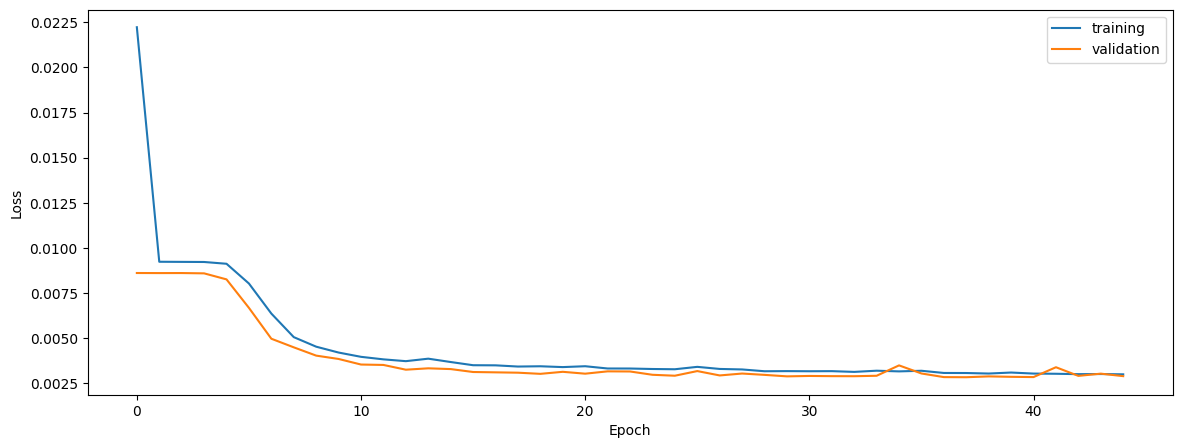

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getPearson, predictInBatches

train.append(predictInBatches(model,train[0],architecture['batch_size']))
val.append(predictInBatches(model,val[0],architecture['batch_size']))
test.append(predictInBatches(model,test[0],architecture['batch_size']))

print('train')
print(getPearson(train[1],train[4]))
print(getPearson(val[1],val[4]))
print(getPearson(test[1],test[4]))

train
0.6126073009178127
0.6181728736209676
0.6299688502487331


In [8]:
print(props['space'])
print(getPearson(train[1],train[4],train[3][0]))
print(getPearson(val[1],val[4],val[3][0]))
print(getPearson(test[1],test[4],test[3][0]))

native
0.6132740459053218
0.6179799582434619
0.632156061580729


In [9]:
print('normalized' if props['space'] == 'native' else 'native')
print(getPearson(train[1][train[2]],train[4][train[2]],train[3][1]))
print(getPearson(val[1][val[2]],val[4][val[2]],val[3][1]))
print(getPearson(test[1][test[2]],test[4][test[2]],test[3][1]))

normalized
0.6253963501365788
0.6401718035268954
0.661180522987439


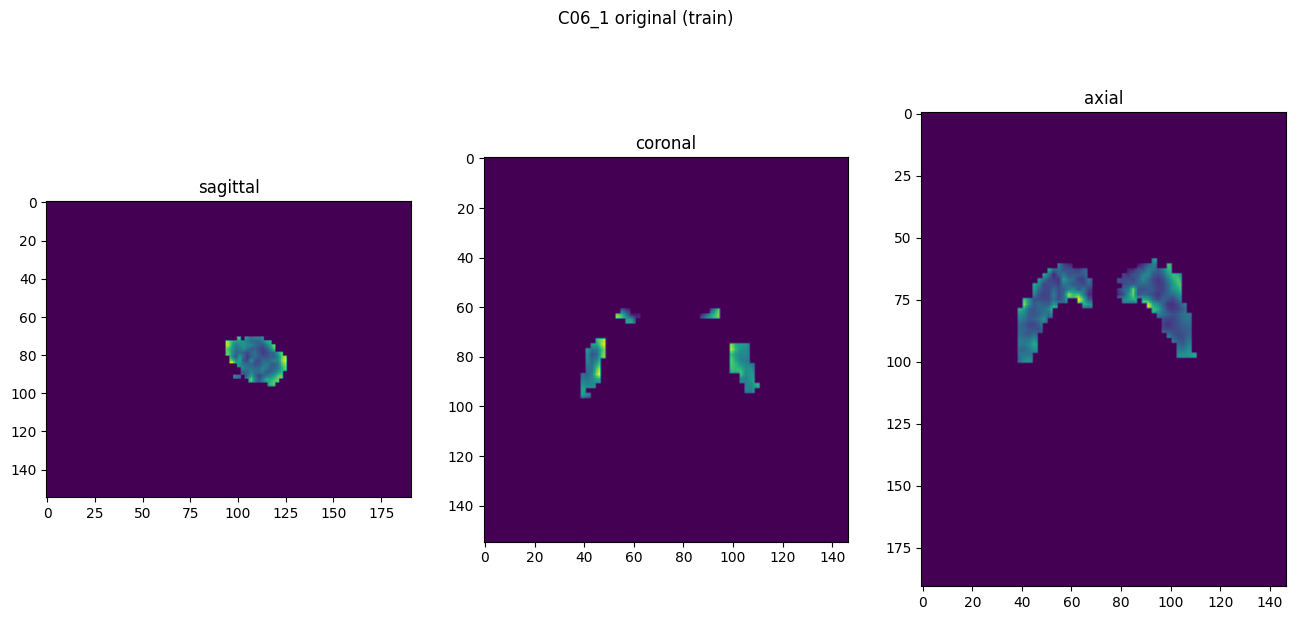

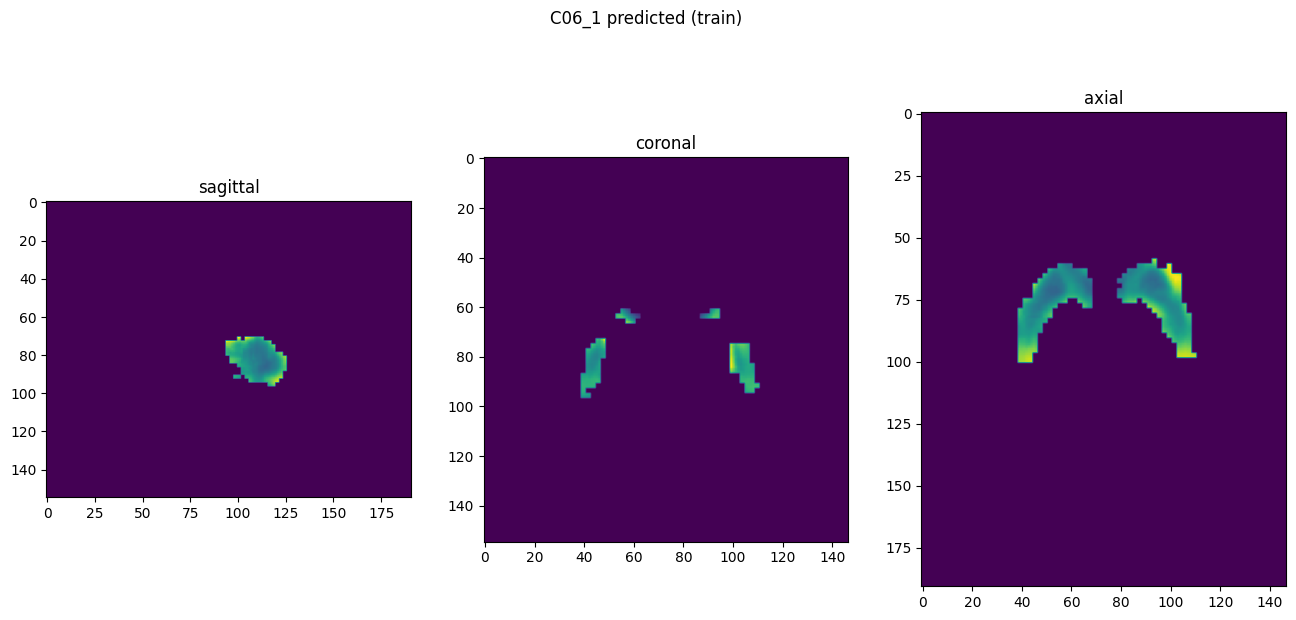

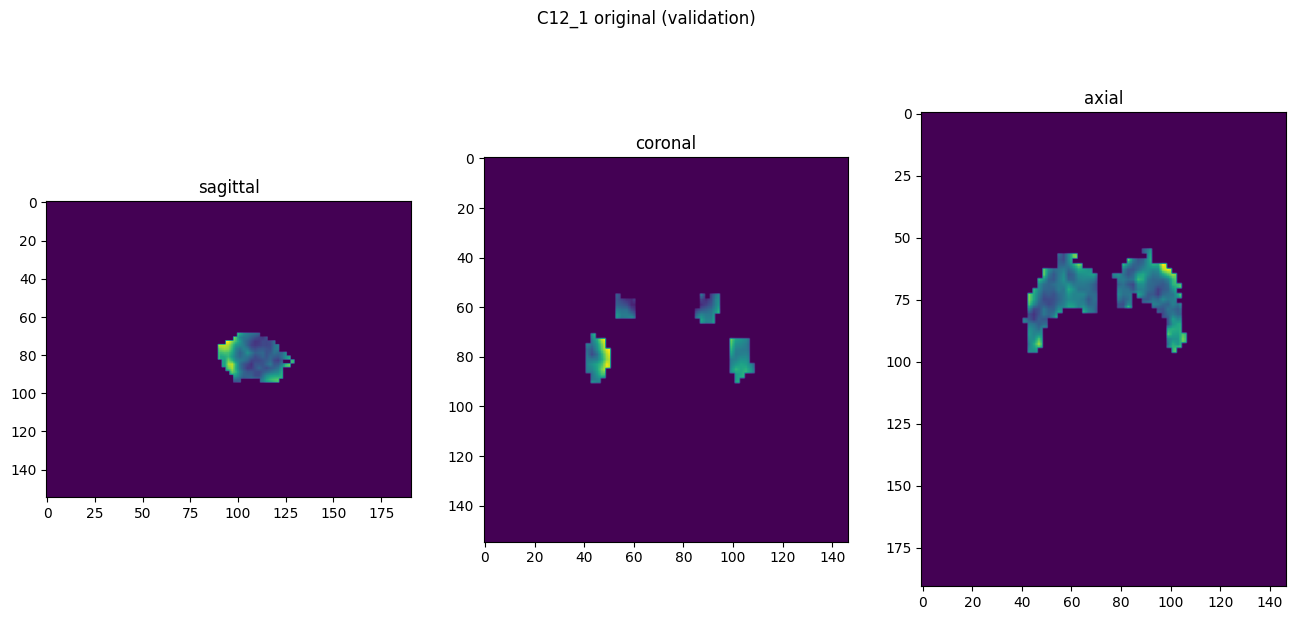

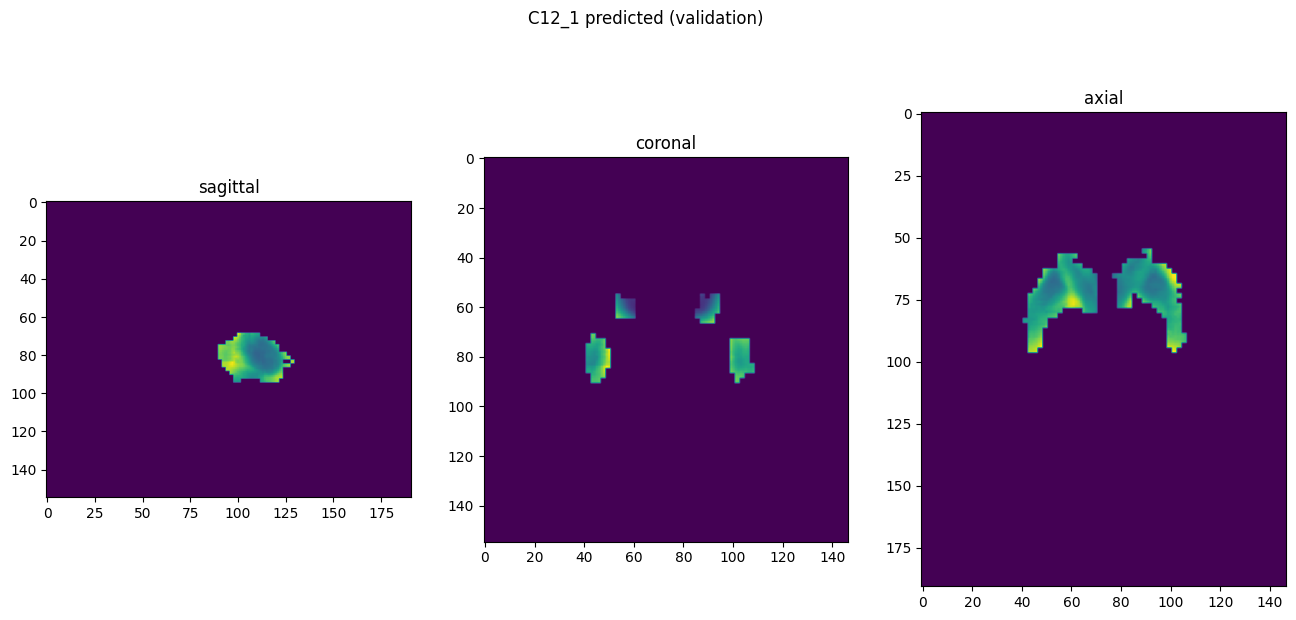

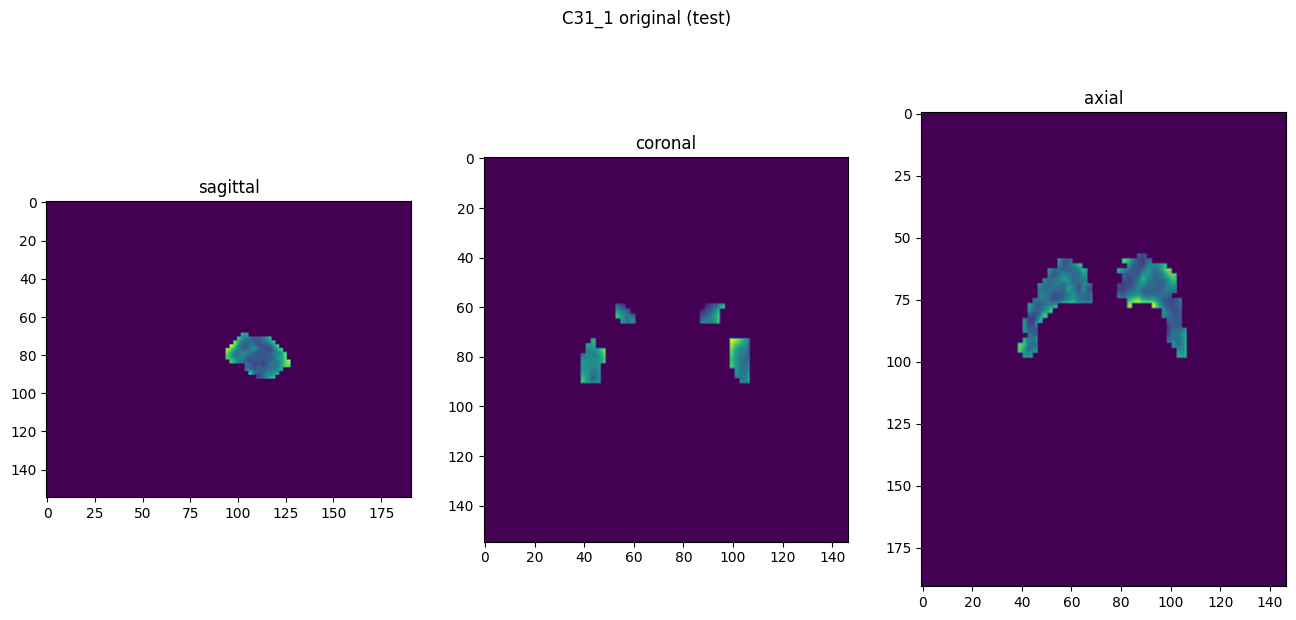

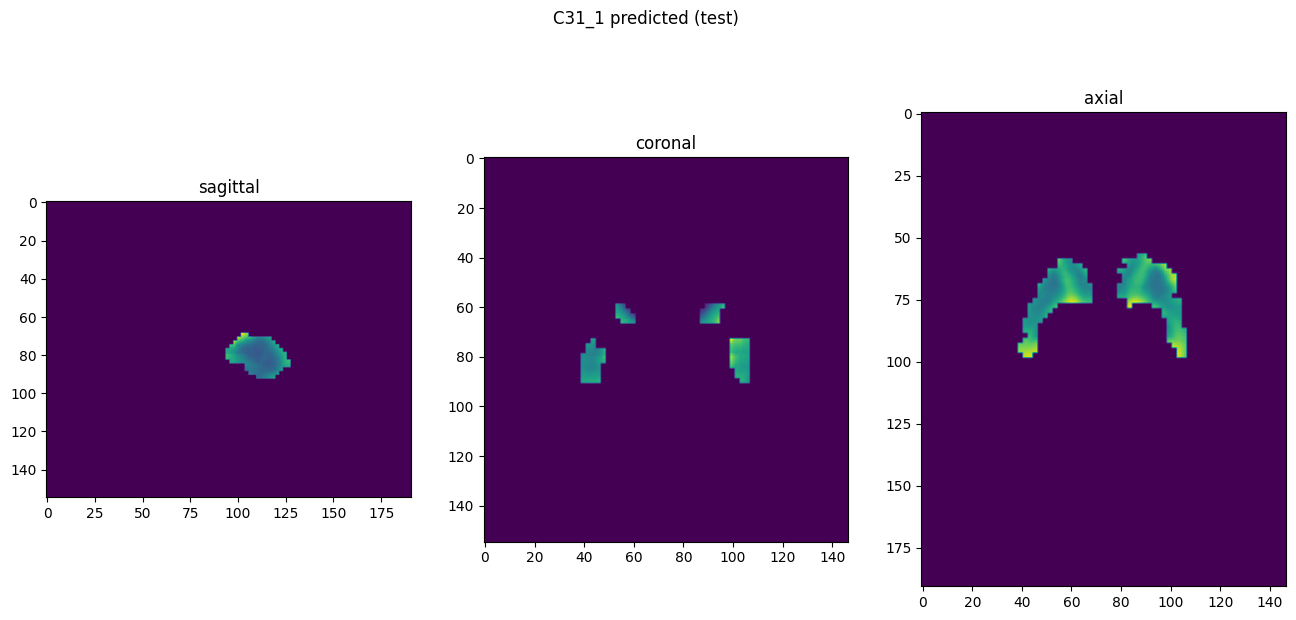

In [10]:
showResults(model, gen, threshold=None, background=False)